# Parte I TF-IDF

# TF-IDF -México

In [2]:
import numpy as np 
import pandas as pd 
import re # lidia con expresiones regulares
import nltk
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup    
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize # sentencia en palabras
from nltk.stem import SnowballStemmer # idioma steam
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm



from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# Any results you write to the current directory are saved as output.
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score 


In [3]:
# Importando los textos
import os

# introducit path datos de entrenamiento

os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\IberLEF19-IroSvA-training-20190331')
train = pd.read_csv('irosva.mx.training.csv');

# introducit path datos de prueba
os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\IberLEF19-IroSvA-test-20190420')
test_nolabel = pd.read_csv('irosva.mx - irosva.mx.test.csv');


# introducit path etiquetas verdaderas de prueba
os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\IberLEF19-IroSvA-test-truth-20190420')
test_label = pd.read_csv('irosva.mx.test.truth.csv');

test_nolabel.head()

,ID,TOPIC,IS_IRONIC,MESSAGE
0,00b72ddf1bc2407aca2d894fcc15858b,divorcioEPN,?,"Indigna la postura de una mujer mexicana, vend..."
1,0191f2511079cc0fdc3c9303dbdb9194,venezuela,?,Sip te traje un llavero! Jajajaja
2,01f162d9a7cc37f3954dca0b73199974,venezuela,?,"Siiii. Rusia, Cuba y China no quieren el petró..."
3,022a4dc5768a616861746743e36881e5,tierraPlana,?,ADORO LOS FINALES FELICES!
4,029041e492841a402d68988d4e07fd97,tierraPlana,?,RT @ElErreCuatro: Los astrónomos sentirán lo m...


In [4]:
test_nolabel.head()

,ID,TOPIC,IS_IRONIC,MESSAGE
0,00b72ddf1bc2407aca2d894fcc15858b,divorcioEPN,?,"Indigna la postura de una mujer mexicana, vend..."
1,0191f2511079cc0fdc3c9303dbdb9194,venezuela,?,Sip te traje un llavero! Jajajaja
2,01f162d9a7cc37f3954dca0b73199974,venezuela,?,"Siiii. Rusia, Cuba y China no quieren el petró..."
3,022a4dc5768a616861746743e36881e5,tierraPlana,?,ADORO LOS FINALES FELICES!
4,029041e492841a402d68988d4e07fd97,tierraPlana,?,RT @ElErreCuatro: Los astrónomos sentirán lo m...


In [5]:
test_label.head()

,ID,TOPIC,IS_IRONIC
0,117e2564e8f70610a92cbcf5d667c587,asuntosConacyt,1
1,2706c1bda8f66136b97f1eb41c81eb39,asuntosConacyt,1
2,271fae76eef136ad339fa5b4b43a1300,asuntosConacyt,1
3,290853214bcd8bfc1e1d42ce91d85781,asuntosConacyt,1
4,29a72a4c42e8cacf9ca225f4834d3da1,asuntosConacyt,1


In [6]:
# Se realiza merge para tener las etiquetas de los datos de prueba

test = pd.merge(test_nolabel, test_label, on='ID')
test.head()

,ID,TOPIC_x,IS_IRONIC_x,MESSAGE,TOPIC_y,IS_IRONIC_y
0,00b72ddf1bc2407aca2d894fcc15858b,divorcioEPN,?,"Indigna la postura de una mujer mexicana, vend...",divorcioEPN,0
1,0191f2511079cc0fdc3c9303dbdb9194,venezuela,?,Sip te traje un llavero! Jajajaja,venezuela,0
2,01f162d9a7cc37f3954dca0b73199974,venezuela,?,"Siiii. Rusia, Cuba y China no quieren el petró...",venezuela,1
3,022a4dc5768a616861746743e36881e5,tierraPlana,?,ADORO LOS FINALES FELICES!,tierraPlana,0
4,029041e492841a402d68988d4e07fd97,tierraPlana,?,RT @ElErreCuatro: Los astrónomos sentirán lo m...,tierraPlana,0


In [7]:
entrenamiento = train["TOPIC"].astype(str).str.cat(train["MESSAGE"].astype(str), sep=' ')
prueba = test["TOPIC_y"].astype(str).str.cat(test["MESSAGE"].astype(str), sep=' ')

Las siguientes funciones realiza pre-proceso de corpus

* review_to_words: con steamed

* review_to_words2: sin steamed

In [8]:
def review_to_words( raw_review ):
    # 1. Remover todo menos letras y comas        
    letters_only = re.sub('[^\w]\d*',  " ", raw_review) 
    # 2. convertir a mínusculas
    words = letters_only.lower().split()                             
    # 3. remover stopwords
    stops = set(stopwords.words("spanish"))                  
    # 3.1 retirando stopwords
    meaningful_words = [w for w in words if not w in stops]   
    # 4 stemming en español
    stemmer = SnowballStemmer('spanish')
    stemmed_text = [stemmer.stem(i) for i in meaningful_words]
    # 5. uniendo documeto
    return( " ".join( stemmed_text ))  


In [9]:
def review_to_words2( raw_review ):
    # 1. Remover todo menos letras y comas       
    letters_only = re.sub('[^\w]\d*',  " ", raw_review) 
    # 2. convertir a mínusculas
    words = letters_only.lower().split()                             
    # 3. remover stopwords
    stops = set(stopwords.words("spanish"))                  
    # 3.1 retirando stopwords
    meaningful_words = [w for w in words if not w in stops]   
    return( " ".join( meaningful_words )) 

* La clases se observan desbalanceadas

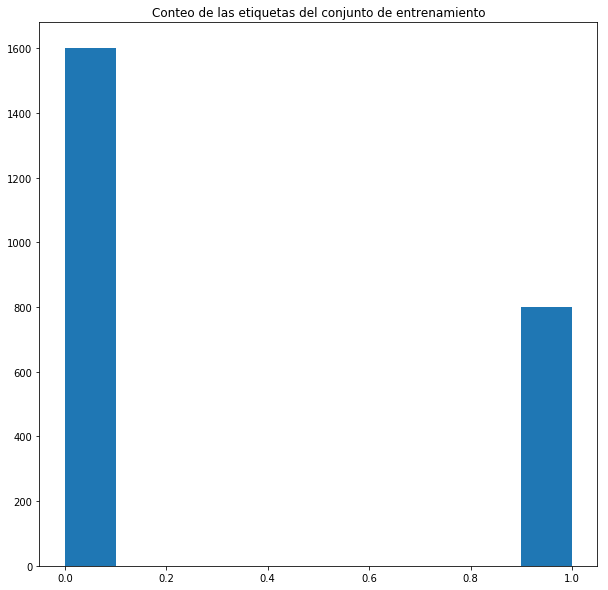

In [443]:
plt.figure(figsize=(10,10))
plt.hist(train['IS_IRONIC'][:], bins=10)
plt. title('Conteo de las etiquetas del conjunto de entrenamiento')
plt.show()

* Las variables que representanBoW TF-IDF, W2vec Google y W2vec Twitter,  de los twits en México.

In [10]:
x_train = train["MESSAGE"]
x_test = test["MESSAGE"]
y_train = train['IS_IRONIC']
y_test = test['IS_IRONIC_y']

* Limpiando corpus de entrenamiento y prueba

In [11]:
#Limpiando datos de entrenamiento
num = x_train.size
# Lista para guardar twits limpios
clean_train = []

for i in range( 0, num):
    clean_train.append(review_to_words(x_train.values[i]))

x_train_mx = clean_train


num= x_test.size

clean_test_train = []

for i in range( 0, num):
    clean_test_train.append( review_to_words(x_test.values[i] ) )

x_test_mx = clean_test_train

Se observa que la proporcióin de las etiquetas se conservan 

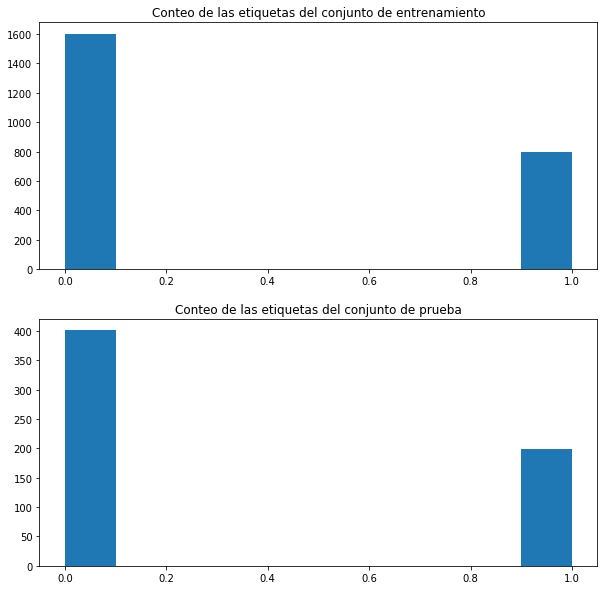

In [446]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.hist(y_train, bins=10)
plt. title('Conteo de las etiquetas del conjunto de entrenamiento')
plt.subplot(212)
plt.hist(y_test, bins=10)
plt. title('Conteo de las etiquetas del conjunto de prueba')
plt.show()

In [12]:
x_train_mx = train["TOPIC"].astype(str).str.cat(x_train_mx, sep=' ')
x_test_mx = test["TOPIC_y"].astype(str).str.cat(x_test_mx, sep=' ')

In [28]:
x_test_mx# Datos de entrenamient y de prueba ya pre-procesados

x_train_mx = pd.Series(x_train_mx)
y_train = pd.Series(y_train)
x_test_mx = pd.Series(x_test_mx)
y_test = pd.Series(y_test)

print(x_train_mx.shape)
print(y_train.shape)
print(x_test_mx.shape)
print(y_test.shape)

(2400,)
(2400,)
(600,)
(600,)


* Representación BoW TF-IDF, datos de entrenamiento y de prueba

In [31]:
vect_mx = TfidfVectorizer(min_df=.01)
x_train_tf_mx = vect_mx.fit_transform(x_train_mx)
x_test_tf_mx = vect_mx.transform(x_test_mx)

x_train_tf_mx = x_train_tf_mx.toarray()
x_test_tf_mx = x_test_tf_mx.toarray()

print(x_train_tf_mx.shape)
print(x_test_tf_mx.shape)

#print(vect_mx.vocabulary_)
#print(x_train_tf_mx[:5])

(2400, 186)
(600, 186)


# Clasificador  NN

* Se utiliza keras para estimar NN

In [179]:
# Bibliotecas
import itertools
import tensorflow as tf # tensorflow

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
# keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras.utils import to_categorical
from keras.preprocessing import text, sequence
from keras import utils

In [180]:
# targets de entrenamiento y de prueba como indicadoras

y_train_mx = to_categorical(y_train)
y_test_mx  = to_categorical(y_test)

num_mx, sz_mx = y_train_mx.shape

print(num_mx)
print(sz_mx)

2400
2


### Selección de modelo

* Seleccionar el número de epocas para evitar el sobre ajuste

In [20]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 5

nn_mx = Sequential()
nn_mx.add(Dense(12, activation='relu'))
nn_mx.add(Dropout(0.25))
nn_mx.add(Dense(sz_mx, activation='softmax'))
nn_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_mx = nn_mx.fit(x_train_tf_mx, 
              y_train_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

W0627 22:42:09.863517   672 deprecation_wrapper.py:119] From C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 22:42:10.631410   672 deprecation_wrapper.py:119] From C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0627 22:42:10.896834   672 deprecation_wrapper.py:119] From C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 22:42:10.929146   672 deprecation_wrapper.py:119] From C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Train on 1920 samples, validate on 480 samples
Epoch 1/5
 - 13s - loss: 0.6793 - acc: 0.5833 - val_loss: 0.5946 - val_acc: 0.8854
Epoch 2/5
 - 0s - loss: 0.6629 - acc: 0.6073 - val_loss: 0.5520 - val_acc: 0.8854
Epoch 3/5
 - 0s - loss: 0.6569 - acc: 0.6135 - val_loss: 0.5429 - val_acc: 0.8854
Epoch 4/5
 - 0s - loss: 0.6455 - acc: 0.6177 - val_loss: 0.5311 - val_acc: 0.8854
Epoch 5/5
 - 0s - loss: 0.6383 - acc: 0.6208 - val_loss: 0.5288 - val_acc: 0.8854
Tiempo de procesamiento (secs):  15.420767784118652


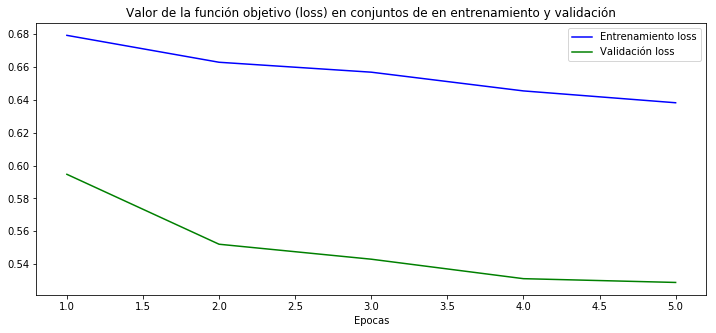

In [21]:
history_dict_mx = history_mx.history
dictkeys_mx=list(history_dict_mx.keys())

loss_values_mx = history_mx.history['loss']
val_loss_values_mx = history_mx.history['val_loss']
epochs_mx = range(1, len(loss_values_mx) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs_mx, loss_values_mx, 'b', label='Entrenamiento loss')
plt.plot(epochs_mx, val_loss_values_mx, 'g', label='Validación loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

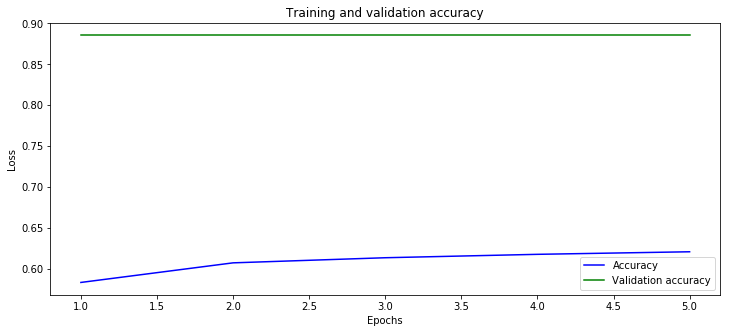

In [24]:
acc_values_mx = history_dict_mx['acc']
val_acc_values_mx = history_dict_mx['val_acc']


plt.figure(figsize=(12,5))
plt.plot(epochs_mx, acc_values_mx, 'b', label='Accuracy')
plt.plot(epochs_mx, val_acc_values_mx, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Como se pueded observar, la función de pérdida en el conjunto de validación alcanza su mínimo alredeor de las épocas 2 o 3, después incrementa su valor. A ese número de épocas, el accuracy también tienen un máximo local.

* Seleccionando el número de nodos

In [39]:
batch_size = 100
epochs = 3 # epocas seleccionadas

list_nn_mx = np.arange( 1, 800, 50) # parámetro de regularización
score_train_mx = np.zeros(len(list_nn_mx)) # almacena acurracy entrenamiento
score_test_mx = np.zeros(len(list_nn_mx)) # almacena acurracy prueba
count = 0
for i in list_nn_mx:
    # Build the model
    nn_mx = Sequential()
    nn_mx.add(Dense(i, activation='relu'))
    nn_mx.add(Dropout(0.25))
    nn_mx.add(Dense(sz_mx, activation='softmax'))
    nn_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
# No se utilizan datos de validación    
    nn_mx.fit(x_train_tf_mx, 
              y_train_mx,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)
  
    temp1_mx = nn_mx.evaluate(x_train_tf_mx, y_train_mx, verbose=0)
    score_train_mx[count] = temp1_mx[1]
    temp2_mx = nn_mx.evaluate(x_test_tf_mx, y_test_mx, verbose=0)
    score_test_mx[count]= temp2_mx[1]
    count = count + 1 

Gráfica acurracy datos de entrenamiento y de prueba

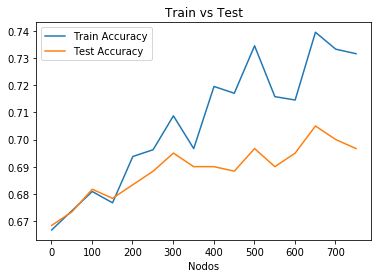

In [40]:
matriz_mx = np.matrix(np.c_[list_nn_mx, score_train_mx, score_test_mx])
models_mx = pd.DataFrame(data = matriz_mx, columns = 
             ['Nodos', 'Train Accuracy', 'Test Accuracy'])
plt.plot(models_mx['Nodos'],models_mx['Train Accuracy'])
plt.plot(models_mx['Nodos'],models_mx['Test Accuracy'])
plt.title('Train vs Test')
plt.xlabel('Nodos')
plt.legend()
plt.show()

In [41]:
models_mx

,Nodos,Train Accuracy,Test Accuracy
0,1.0,0.666667,0.668333
1,51.0,0.673750,0.673333
2,101.0,0.680833,0.681667
3,151.0,0.676667,0.678333
4,201.0,0.693750,0.683333
5,251.0,0.696250,0.688333
6,301.0,0.708750,0.695000
7,351.0,0.696667,0.690000
8,401.0,0.719583,0.690000
9,451.0,0.717083,0.688333


In [336]:
#nodo_mx = list_nn_mx[np.argmax(np.array(models_mx['Test Accuracy']))]
nodo_mx


501


* Diseño final

In [35]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 7 # seleccionadas

nn_mx = Sequential()
nn_mx.add(Dense(nodo_mx, activation='relu'))
nn_mx.add(Dropout(0.25))
nn_mx.add(Dense(sz_mx, activation='softmax'))
nn_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_mx = nn_mx.fit(x_train_tf_mx, 
              y_train_mx, 
              validation_split=.2, #20% de para validad
              batch_size= batch_size, 
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)



Train on 1920 samples, validate on 480 samples
Epoch 1/7
 - 1s - loss: 0.6634 - acc: 0.6083 - val_loss: 0.4964 - val_acc: 0.8854
Epoch 2/7
 - 0s - loss: 0.6230 - acc: 0.6417 - val_loss: 0.5153 - val_acc: 0.8771
Epoch 3/7
 - 0s - loss: 0.5875 - acc: 0.6880 - val_loss: 0.5135 - val_acc: 0.7937
Epoch 4/7
 - 0s - loss: 0.5588 - acc: 0.7089 - val_loss: 0.5101 - val_acc: 0.7688
Epoch 5/7
 - 0s - loss: 0.5366 - acc: 0.7313 - val_loss: 0.5329 - val_acc: 0.7250
Epoch 6/7
 - 0s - loss: 0.5098 - acc: 0.7536 - val_loss: 0.5435 - val_acc: 0.7208
Epoch 7/7
 - 0s - loss: 0.4860 - acc: 0.7656 - val_loss: 0.5837 - val_acc: 0.6833
Tiempo de procesamiento (secs):  1.730325698852539


* Se guarda el modelo seleciconado

In [181]:
from keras.models import load_model
#nn_mx.save('nn_mexico_tfidf')  # Guardar
nn_mx = load_model('nn_mexico_tfidf') # Cargar

In [183]:
results_mx = nn_mx.evaluate(x_test_tf_mx, y_test_mx)
print('Test loss:', results_mx[0])
print('Test accuracy:', results_mx[1])

600/600 [==============================] - 0s 53us/step
Test loss: 0.5971186947822571
Test accuracy: 0.693333334128062


* Visualización del desempeño matriz de confusión


In [184]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
y_pred_mx = nn_mx.predict(x_test_tf_mx).squeeze()
y_test_label_mx = np.argmax(y_test_mx,1) 
y_pred_label_mx = np.argmax(y_pred_mx,1)

# Confusion matrix
C=confusion_matrix(y_test_label_mx , y_pred_label_mx)
print(C)


[[350  51]
 [133  66]]


### Resultados

In [185]:
print('Accuracy score:', results_mx[1])  # nn evaluate keras
print("F1 score", f1_score( y_test_label_mx,  y_pred_label_mx,  average='macro'))
print("F1 weighted", f1_score( y_test_label_mx,  y_pred_label_mx,  average='weighted'))
print("Recall score", recall_score( y_test_label_mx,  y_pred_label_mx,  average='macro'))
print("Precision score", precision_score( y_test_label_mx,  y_pred_label_mx, average='macro'))


Accuracy score: 0.693333334128062
F1 score 0.6047883613036256
F1 weighted 0.6677675315501078
Recall score 0.6022381232847529
Precision score 0.6443701226309921


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test_label_mx, y_pred_label_mx, target_names=['no-ironia','ironia']))

              precision    recall  f1-score   support

   no-ironia       0.72      0.87      0.79       401
      ironia       0.56      0.33      0.42       199

   micro avg       0.69      0.69      0.69       600
   macro avg       0.64      0.60      0.60       600
weighted avg       0.67      0.69      0.67       600



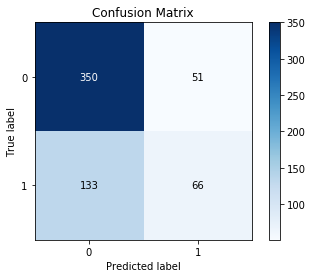

In [458]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_label_mx, y_pred_label_mx)

# Clasificador SVM

* Selección de modelo, parámetro de regularización

In [455]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=1000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.01,10,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(x_train_tf_mx, y_train.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svm_mx = linearSVC.best_estimator_
svm_mx.fit(x_train_tf_mx, y_train.values)
svm_mx.coef_ = svm_mx.named_steps['SVC'].coef_
svm_mx.score(x_train_tf_mx, y_train.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.27}
Tiempo de procesamiento (secs):  255.94659614562988


* Gráfica accuracy datos de entrenamiento y de prueba

In [456]:
prediction_mx=svm_mx.predict(x_test_tf_mx)
print("Acurracy Test",metrics.accuracy_score(prediction_mx, y_test.values))

Acurracy Test 0.6633333333333333


In [457]:
print("Confusion Metrix:\n",metrics.confusion_matrix(y_test.values, prediction_mx)) # matriz de confusión

Confusion Metrix:
 [[270 131]
 [ 71 128]]


In [186]:
from joblib import dump, load
#dump(svm_mx, 'svm_mexico_tfidf.joblib') # Guarda modelos
svm_mx = load('svm_mexico_tfidf.joblib') # Carga modelo

In [187]:
#Prediction
prediction_mx=svm_mx.predict(x_test_tf_mx)
print("Acurracy Test",metrics.accuracy_score(prediction_mx, y_test.values))

Acurracy Test 0.6633333333333333


In [188]:
print("Confusion Metrix:\n",metrics.confusion_matrix(y_test.values, prediction_mx)) # matriz de confusión

Confusion Metrix:
 [[271 130]
 [ 72 127]]


### Resultados

In [189]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

print('Accuracy score:', metrics.accuracy_score(y_test.values,  prediction_mx, ))  # nn evaluate keras
print("F1 score", f1_score(y_test.values,  prediction_mx,  average='macro'))
print("F1 weighted", f1_score(y_test.values,  prediction_mx,   average='weighted'))
print("Recall score", recall_score(y_test.values,  prediction_mx,   average='macro'))
print("Precision score", precision_score(y_test.values,  prediction_mx,  average='macro'))

Accuracy score: 0.6633333333333333
F1 score 0.6427560837577816
F1 weighted 0.6716213921901528
Recall score 0.6570007142946653
Precision score 0.6421254438406825


In [463]:
from sklearn.metrics import classification_report
print(classification_report( y_test.values, prediction_mx, target_names=['no-ironia','ironia']))

              precision    recall  f1-score   support

   no-ironia       0.79      0.68      0.73       401
      ironia       0.49      0.64      0.56       199

   micro avg       0.66      0.66      0.66       600
   macro avg       0.64      0.66      0.64       600
weighted avg       0.69      0.66      0.67       600



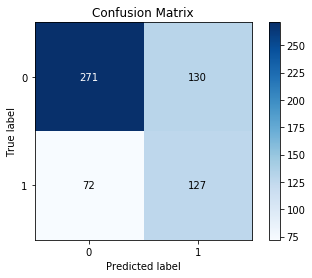

In [464]:
# matriz de confusión

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test.values, prediction_mx)

* Chi2 importancia del término respecto target

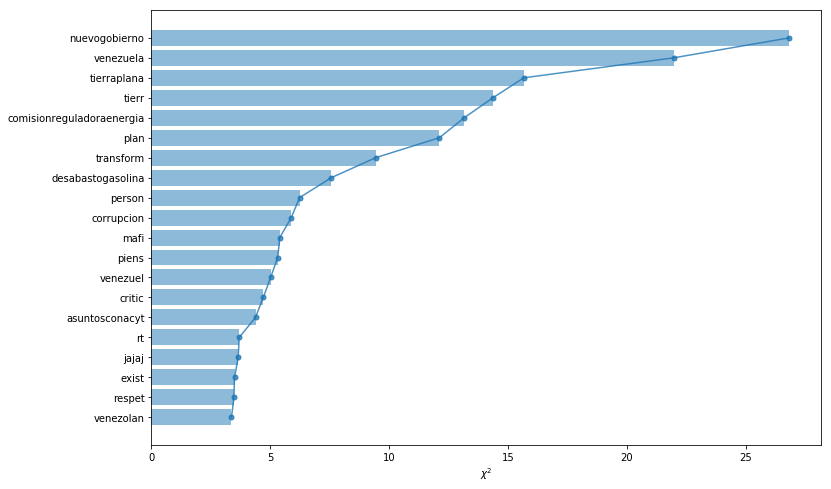

In [48]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
# compute chi2 for each feature
chi2score_mx = chi2(x_train_tf_mx,y_train)[0]


%matplotlib inline
plt.figure(figsize=(12,8))
scores_mx = list(zip(vect_mx.get_feature_names(), chi2score_mx))
chi2_mx = sorted(scores_mx, key=lambda x:x[1])
topchi2_mx = list(zip(*chi2_mx[-20:]))
x_mx = range(len(topchi2_mx[1]))
labels_mx = topchi2_mx[0]
plt.barh(x_mx,topchi2_mx[1], align='center', alpha=0.5)
plt.plot(topchi2_mx[1], x_mx, '-o', markersize=5, alpha=0.8)
plt.yticks(x_mx, labels_mx)
plt.xlabel('$\chi^2$')
plt.show();

# TF-IDF -España

In [108]:
# Importando los textos
import os

# introducit path
os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\IberLEF19-IroSvA-training-20190331')
train_es = pd.read_csv('irosva.es.training.csv');

# introducit path
os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\IberLEF19-IroSvA-test-20190420')
test_es_nolabel = pd.read_csv('irosva.es - irosva.es.test.csv');

# introducit path
os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\IberLEF19-IroSvA-test-truth-20190420')
test_es_label = pd.read_csv('irosva.es.test.truth.csv');

In [109]:
test_es = pd.merge(test_es_nolabel, test_es_label, on='ID')
test_es.head()


,ID,TOPIC_x,IS_IRONIC_x,MESSAGE,TOPIC_y,IS_IRONIC_y
0,002dec9f773cc17edcc7b02acb8e8926,FRANCO,?,► ¿Suspenden exhumación de Francisco Franco? E...,FRANCO,0
1,007342bd6eed6cca55d2587db4504a7a,TIERRAPLANISTAS,?,"@alonsokas1 Por cierto, además de tierraplanis...",TIERRAPLANISTAS,0
2,00a96b4357a8bccbb9bef0cb72097a30,RELATOR,?,#ThisIsTheRealSpain\n La oposición y un sector...,RELATOR,0
3,00c6d1ffc0c371450d61c3d05e424934,FRANCO,?,El cardenal Blázquez dice que nunca apoyó dese...,FRANCO,0
4,0163cd612a33f7f8cf1e9ac3a28ac80c,FRANCO,?,Exhumación Franco: El Supremo puede impedir qu...,FRANCO,0


* Balance en las clases

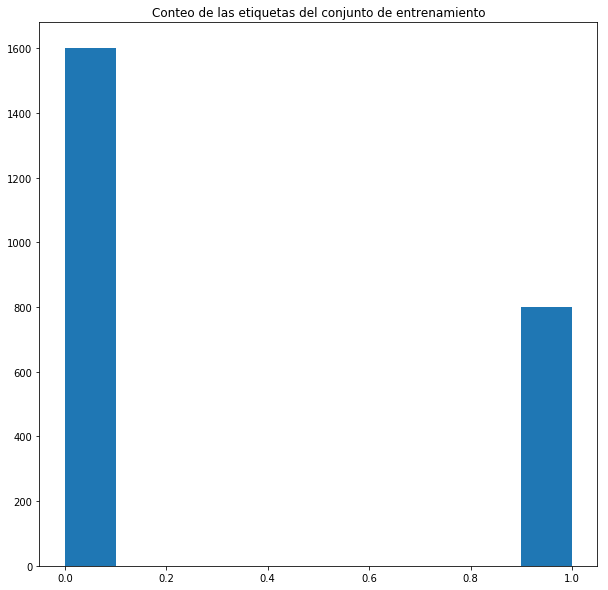

In [467]:
plt.figure(figsize=(10,10))
plt.hist(train_es['IS_IRONIC'][:], bins=10)
plt. title('Conteo de las etiquetas del conjunto de entrenamiento')
plt.show()

* Nombre de las variables que se utilizan par las tres representaciones de los twits de España

In [110]:
x_train_españa = train_es["MESSAGE"]
x_test_españa = test_es["MESSAGE"]
y_train_es = train_es['IS_IRONIC']
y_test_es = test_es['IS_IRONIC_y'] 
print([y_train_es.shape, y_test_es.shape])    

[(2400,), (600,)]


In [111]:
#Limpiando datos de entrenamiento
num = x_train_españa.size

clean_train = []


for i in range( 0, num):

    clean_train.append(review_to_words(x_train_españa.values[i]))

x_train_es = clean_train

#Limpiando datos de prueba
num= x_test_españa.size

clean_test_train = []


for i in range( 0, num):

    clean_test_train.append( review_to_words(x_test_españa.values[i] ) )

x_test_es = clean_test_train

* Conservan proporción 

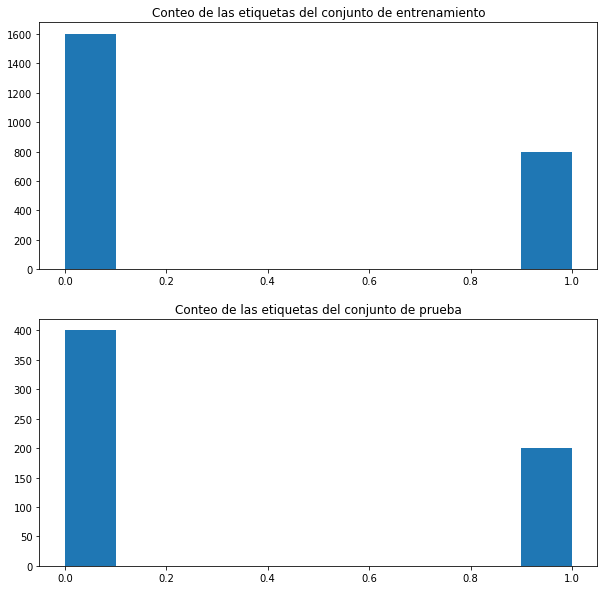

In [28]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.hist(y_train_es, bins=10)
plt. title('Conteo de las etiquetas del conjunto de entrenamiento')
plt.subplot(212)
plt.hist(y_test_es, bins=10)
plt. title('Conteo de las etiquetas del conjunto de prueba')
plt.show()

In [112]:
x_train_es = train_es["TOPIC"].astype(str).str.cat(x_train_es, sep=' ')
x_test_es = test_es["TOPIC_y"].astype(str).str.cat(x_test_es, sep=' ')

In [113]:
x_train_es = pd.Series(x_train_es)
y_train_es = pd.Series(y_train_es)
x_test_es = pd.Series(x_test_es)
y_test_es = pd.Series(y_test_es)

print(x_train_es.shape)
print(y_train_es.shape)
print(x_test_es.shape)
print(y_test_es.shape)

(2400,)
(2400,)
(600,)
(600,)


* Representación Bow TF-IDF

In [114]:
vect_es = TfidfVectorizer()# completo
x_train_tf_es = vect_es.fit_transform(x_train_es)
x_test_tf_es = vect_es.transform(x_test_es)

x_train_tf_es = x_train_tf_es.toarray()
x_test_tf_es = x_test_tf_es.toarray()

print(x_train_tf_es.shape)
print(x_test_tf_es.shape)



(2400, 6944)
(600, 6944)


# Clasificador NN

In [197]:
from keras.utils import to_categorical

y_train_esp = to_categorical(y_train_es)
y_test_esp = to_categorical(y_test_es)

num_es, sz_es = y_train_esp.shape

print(num_es)
print(sz_es)

2400
2


### Selección de modelo

* Seleccionar el número de epocas para evitar el sobre ajuste

In [198]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 10

nn_es = Sequential()
nn_es.add(Dense(512, activation='relu'))
nn_es.add(Dropout(0.25))
nn_es.add(Dense(sz_es, activation='softmax'))
nn_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_es = nn_es.fit(x_train_tf_es, 
              y_train_esp, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 1920 samples, validate on 480 samples
Epoch 1/10
 - 6s - loss: 0.5939 - acc: 0.6766 - val_loss: 0.6579 - val_acc: 0.5854
Epoch 2/10
 - 1s - loss: 0.3787 - acc: 0.8344 - val_loss: 0.7311 - val_acc: 0.5583
Epoch 3/10
 - 1s - loss: 0.1793 - acc: 0.9427 - val_loss: 0.7683 - val_acc: 0.5875
Epoch 4/10
 - 1s - loss: 0.0716 - acc: 0.9875 - val_loss: 0.8906 - val_acc: 0.5833
Epoch 5/10
 - 1s - loss: 0.0318 - acc: 0.9958 - val_loss: 0.8950 - val_acc: 0.5979
Epoch 6/10
 - 1s - loss: 0.0170 - acc: 0.9984 - val_loss: 0.9807 - val_acc: 0.5854
Epoch 7/10
 - 1s - loss: 0.0106 - acc: 0.9990 - val_loss: 0.9905 - val_acc: 0.5958
Epoch 8/10
 - 1s - loss: 0.0076 - acc: 0.9990 - val_loss: 1.0296 - val_acc: 0.5958
Epoch 9/10
 - 1s - loss: 0.0058 - acc: 0.9995 - val_loss: 1.0642 - val_acc: 0.5875
Epoch 10/10
 - 1s - loss: 0.0047 - acc: 0.9995 - val_loss: 1.0939 - val_acc: 0.5896
Tiempo de procesamiento (secs):  12.440585374832153


Gráfica loss values datos de entrenamiento y validación 

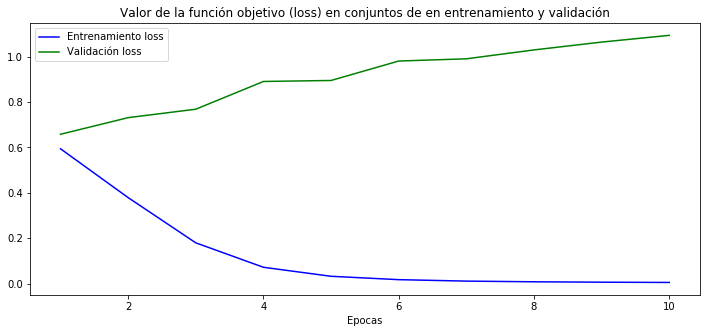

In [63]:
history_dict_es = history_es.history
dictkeys_es=list(history_dict_es.keys())
loss_values_es = history_es.history['loss']
val_loss_values_es = history_es.history['val_loss']
epochs_es = range(1, len(loss_values_es) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs_es, loss_values_es, 'b', label='Entrenamiento loss')
plt.plot(epochs_es, val_loss_values_es, 'g', label='Validación loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

Gráfica accuracy datos de entrenamiento y validación 

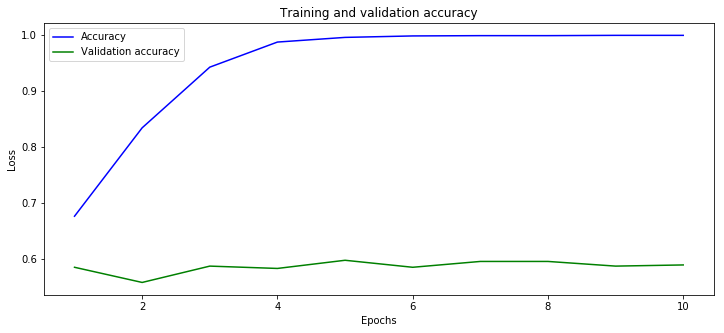

In [64]:
acc_values_es = history_dict_es['acc']
val_acc_values_es = history_dict_es['val_acc']
plt.figure(figsize=(12,5))
plt.plot(epochs_es, acc_values_es, 'b', label='Accuracy')
plt.plot(epochs_es, val_acc_values_es, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

* Seleccionando el número de nodos

In [65]:
batch_size = 100
epochs = 6 # epocas seleccionadas

list_nn_es = np.arange( 1, 800, 50) # parámetro de regularización
score_train_es = np.zeros(len(list_nn_es)) # almacena acurracy entrenamiento
score_test_es = np.zeros(len(list_nn_es)) # almacena acurracy prueba
count = 0
for i in list_nn_es:
    # Build the model
    nn_es = Sequential()
    nn_es.add(Dense(i, activation='relu'))
    nn_es.add(Dropout(0.25))
    nn_es.add(Dense(sz_es, activation='softmax'))
    nn_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
# No se utilizan datos de validación    
    nn_es.fit(x_train_tf_es, 
              y_train_esp,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)
  
    temp1_es = nn_es.evaluate(x_train_tf_es, y_train_esp, verbose=0)
    score_train_es[count] = temp1_es[1]
    temp2_es= nn_es.evaluate(x_test_tf_es, y_test_esp, verbose=0)
    score_test_es[count]= temp2_es[1]
    count = count + 1 

Gráfico acurracy datos de entrenamiento y de prueba

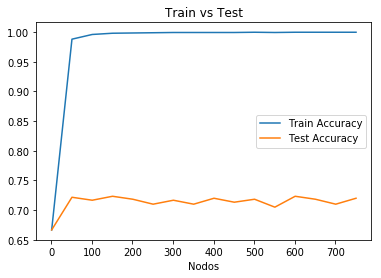

In [66]:
matriz_es = np.matrix(np.c_[list_nn_es, score_train_es, score_test_es])
models_es = pd.DataFrame(data = matriz_es, columns = 
             ['Nodos', 'Train Accuracy', 'Test Accuracy'])
plt.plot(models_es['Nodos'],models_es['Train Accuracy'])
plt.plot(models_es['Nodos'],models_es['Test Accuracy'])
plt.title('Train vs Test')
plt.xlabel('Nodos')
plt.legend()
plt.show()

In [67]:
models_es

,Nodos,Train Accuracy,Test Accuracy
0,1.0,0.666667,0.666667
1,51.0,0.987917,0.721667
2,101.0,0.995833,0.716667
3,151.0,0.997917,0.723333
4,201.0,0.998333,0.718333
5,251.0,0.998750,0.710000
6,301.0,0.999167,0.716667
7,351.0,0.999167,0.710000
8,401.0,0.999167,0.720000
9,451.0,0.999167,0.713333


In [68]:
nodo_es = list_nn_es[np.argmax(np.array(models_es['Test Accuracy']))]
nodo_es

# Se seleccionan 50 nodos
#nodo_es = 50
#nodo_es

151

*  Diseño modelo final

In [73]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 3

nn_es = Sequential()
nn_es.add(Dense(nodo_es, activation='relu'))
nn_es.add(Dropout(0.25))
nn_es.add(Dense(sz_es, activation='softmax'))
nn_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_es = nn_es.fit(x_train_tf_es, 
              y_train_esp, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


Train on 1920 samples, validate on 480 samples
Epoch 1/3
 - 2s - loss: 0.6296 - acc: 0.6573 - val_loss: 0.6463 - val_acc: 0.6542
Epoch 2/3
 - 0s - loss: 0.4678 - acc: 0.7885 - val_loss: 0.6917 - val_acc: 0.5375
Epoch 3/3
 - 0s - loss: 0.3080 - acc: 0.8875 - val_loss: 0.7302 - val_acc: 0.5562
Tiempo de procesamiento (secs):  3.2347073554992676


* Se guarda el modelo

In [199]:
from keras.models import load_model
#nn_es.save('nn_españa_tfidf')  # Guardad el modelo
nn_es = load_model('nn_españa_tfidf') # Cargar el modelo

In [200]:
results_es = nn_es.evaluate(x_test_tf_es, y_test_esp)
print('Test loss:', results_es[0])
print('Test accuracy:', results_es[1])

600/600 [==============================] - 1s 913us/step
Test loss: 0.5398333676656087
Test accuracy: 0.725


In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

y_pred_es = nn_es.predict(x_test_tf_es).squeeze()
y_test_label_es = np.argmax(y_test_esp,1) 
y_pred_label_es = np.argmax(y_pred_es,1)

# Confusion matrix
C=confusion_matrix(y_test_label_es , y_pred_label_es)
print(C)

[[337  63]
 [102  98]]


### Resultados

In [201]:
print('Accuracy score:', results_es[1])  # nn evaluate keras
print("F1 score", f1_score(y_test_label_es,  y_pred_label_es,  average='macro'))
print("F1 weighted", f1_score(y_test_label_es,  y_pred_label_es,   average='weighted'))
print("Recall score", recall_score(y_test_label_es,  y_pred_label_es,  average='macro'))
print("Precision score", precision_score( y_test_label_es,  y_pred_label_es, average='macro'))

Accuracy score: 0.725
F1 score 0.6731367972028435
F1 weighted 0.716536966907577
Recall score 0.66625
Precision score 0.6881747053580272


In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_test_label_es, y_pred_label_es,target_names=['no-ironia','ironia']))

              precision    recall  f1-score   support

   no-ironia       0.77      0.84      0.80       400
      ironia       0.61      0.49      0.54       200

   micro avg       0.72      0.72      0.73       600
   macro avg       0.69      0.67      0.67       600
weighted avg       0.71      0.72      0.72       600



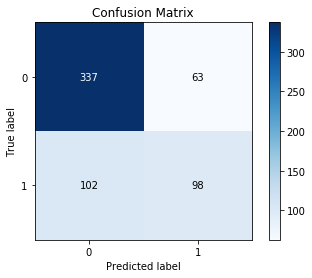

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_label_es, y_pred_label_es)

# Clasificador SVM

* Selección del modelo

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=1000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.001,5,1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(x_train_tf_es, y_train_es.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svm_es = linearSVC.best_estimator_
svm_es.fit(x_train_tf_es, y_train_es.values)
svm_es.coef_ = svm_es.named_steps['SVC'].coef_
svm_es.score(x_train_tf_es, y_train_es.values)
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.001}
Tiempo de procesamiento (secs):  4.632094383239746


Gráfico accuracy de entrenamiento y prueba respecto al parámetro de regularización

* Guardad modelo

In [202]:
from joblib import dump, load
#dump(svm_es, 'svm_epaña_tfidf.joblib') # Guardad modelo
svm_es = load('svm_epaña_tfidf.joblib') # Cargar modelo#

In [203]:
#Prediction
prediction_es=svm_es.predict(x_test_tf_es) # se vuelve a poner esto aquí dado a que se carga el modelo
print("Acurracy Test",metrics.accuracy_score(prediction_es, y_test_es.values))

Acurracy Test 0.715


In [204]:
print("Confusion Metrix:\n",metrics.confusion_matrix(y_test_es.values, prediction_es)) # matriz de confusión

Confusion Metrix:
 [[307  93]
 [ 78 122]]


### Resultados

In [205]:
print('Accuracy score:', metrics.accuracy_score(y_test_es.values, prediction_es, ))  # svm evaluate keras
print("F1 score", f1_score(y_test_es.values, prediction_es,   average='macro'))
print("F1 weighted", f1_score(y_test_es.values, prediction_es,  average='weighted'))
print("Recall score", recall_score(y_test_es.values, prediction_es,   average='macro'))
print("Precision score", precision_score(y_test_es.values, prediction_es,  average='macro'))

Accuracy score: 0.715
F1 score 0.6850587061622284
F1 weighted 0.7174276724733327
Recall score 0.68875
Precision score 0.6824222289338568


In [206]:
from sklearn.metrics import classification_report
print(classification_report( y_test_es.values, prediction_es,target_names=['no-ironia','ironia']))

              precision    recall  f1-score   support

   no-ironia       0.80      0.77      0.78       400
      ironia       0.57      0.61      0.59       200

   micro avg       0.71      0.71      0.71       600
   macro avg       0.68      0.69      0.69       600
weighted avg       0.72      0.71      0.72       600



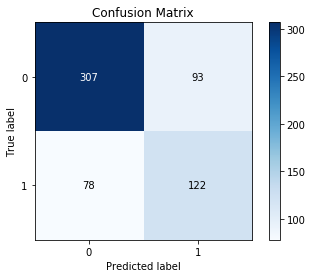

In [486]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_es.values, prediction_es)

In [487]:
from sklearn.feature_selection import chi2
# compute chi2 for each feature
chi2score_es = chi2(x_train_tf_es,y_train_es)[0]

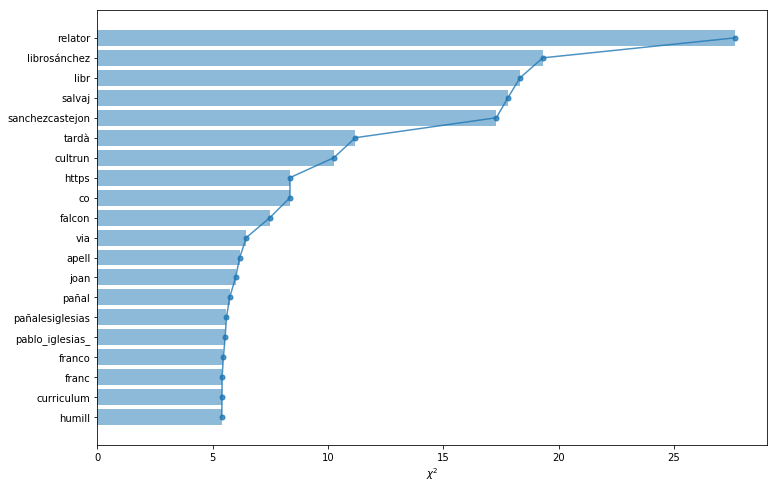

In [488]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
scores_es = list(zip(vect_es.get_feature_names(), chi2score_es))
chi2_es = sorted(scores_es, key=lambda x:x[1])
topchi2_es = list(zip(*chi2_es[-20:]))
x_es = range(len(topchi2_es[1]))
labels_es = topchi2_es[0]
plt.barh(x_es,topchi2_es[1], align='center', alpha=0.5)
plt.plot(topchi2_es[1], x_es, '-o', markersize=5, alpha=0.8)
plt.yticks(x_es, labels_es)
plt.xlabel('$\chi^2$')
plt.show();

# TF-IDF - Cuba

In [207]:
# Importando los textos
import os

# introducit path
os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\IberLEF19-IroSvA-training-20190331')
train_cu = pd.read_csv('irosva.cu.training.csv');

# introducit path
os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\IberLEF19-IroSvA-test-20190420')
test_cu_nolabel = pd.read_csv('irosva.cu - irosva.cu.test.csv');

# introducit path
os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\IberLEF19-IroSvA-test-truth-20190420')
test_cu_label = pd.read_csv('irosva.cu.test.truth.csv');

In [490]:
train_cu.head()

,ID,TOPIC,IS_IRONIC,MESSAGE
0,4fdfed6e794a4c1c1550a2996803ba6e,"TELEVISIÓN DIGITAL, CAJAS DECODIFICADORAS, TEL...",1,magnifico
1,64dc97da772a5d70b62c2c124e12705d,"TELEVISIÓN DIGITAL, CAJAS DECODIFICADORAS, TEL...",1,VIVA EL PAQUETE. Mas pelis clásicas por favor....
2,d66fc3e9a7353a1495a889f34e6371af,"TELEVISIÓN DIGITAL, CAJAS DECODIFICADORAS, TEL...",1,gracias una y mil veces por la programación de...
3,7b303e9eeb0c1ca5c2ec80047dff519b,"TELEVISIÓN DIGITAL, CAJAS DECODIFICADORAS, TEL...",1,LA TV DIGITAL ESTA SIENDO MUY EFICIENTE.
4,fd8a327fe8d642851db4b702069df1f0,"TELEVISIÓN DIGITAL, CAJAS DECODIFICADORAS, TEL...",1,"O sea que los trabajadores de salario medio, l..."


In [491]:
test_cu_nolabel.head()

,ID,TOPIC,IS_IRONIC,MESSAGE
0,00466090f558ec4d1a4b312284aee502,"ECONOMÍA. TURISMOS, HOTELES",?,La oferta es 90 por persona por noche la habit...
1,0069480d19db6f82600e0d34501281d2,"TRANSPORTE, BOTEROS, CHOFERES, ÓMNIBUS, RUTAS",?,"Si vamos a hacer la denuncia, hacedla con todo..."
2,0097b7f8824cf7465f7963aa0b85c98c,"ETECSA, CALIDAD, SERVICIOS",?,?Creo q es una falta d repeto los precios q ti...
3,00d1e2079fc31d88e7a7f5f743e321ea,"NUEVAS TECNOLOGÍAS, INFORMATIZACIÓN DE LA SOCI...",?,"muy buen articulo, espero que nuestra red siga..."
4,00f2c9d7f54f25dba6d0deb88a6fe404,"ETECSA, CALIDAD, SERVICIOS",?,"Yo pagaria los 15 cuc, por algo se empieza, ah..."


In [492]:
test_cu_label.head()

,ID,TOPIC,IS_IRONIC
0,00466090f558ec4d1a4b312284aee502,"ECONOMÍA. TURISMOS, HOTELES",0
1,0069480d19db6f82600e0d34501281d2,"TRANSPORTE, BOTEROS, CHOFERES, ÓMNIBUS, RUTAS",0
2,0097b7f8824cf7465f7963aa0b85c98c,"ETECSA, CALIDAD, SERVICIOS",0
3,00d1e2079fc31d88e7a7f5f743e321ea,"NUEVAS TECNOLOGÍAS, INFORMATIZACIÓN DE LA SOCI...",0
4,00f2c9d7f54f25dba6d0deb88a6fe404,"ETECSA, CALIDAD, SERVICIOS",1


In [208]:
test_cu = pd.merge(test_cu_nolabel, test_cu_label, on='ID')
test_cu.head()

,ID,TOPIC_x,IS_IRONIC_x,MESSAGE,TOPIC_y,IS_IRONIC_y
0,00466090f558ec4d1a4b312284aee502,"ECONOMÍA. TURISMOS, HOTELES",?,La oferta es 90 por persona por noche la habit...,"ECONOMÍA. TURISMOS, HOTELES",0
1,0069480d19db6f82600e0d34501281d2,"TRANSPORTE, BOTEROS, CHOFERES, ÓMNIBUS, RUTAS",?,"Si vamos a hacer la denuncia, hacedla con todo...","TRANSPORTE, BOTEROS, CHOFERES, ÓMNIBUS, RUTAS",0
2,0097b7f8824cf7465f7963aa0b85c98c,"ETECSA, CALIDAD, SERVICIOS",?,?Creo q es una falta d repeto los precios q ti...,"ETECSA, CALIDAD, SERVICIOS",0
3,00d1e2079fc31d88e7a7f5f743e321ea,"NUEVAS TECNOLOGÍAS, INFORMATIZACIÓN DE LA SOCI...",?,"muy buen articulo, espero que nuestra red siga...","NUEVAS TECNOLOGÍAS, INFORMATIZACIÓN DE LA SOCI...",0
4,00f2c9d7f54f25dba6d0deb88a6fe404,"ETECSA, CALIDAD, SERVICIOS",?,"Yo pagaria los 15 cuc, por algo se empieza, ah...","ETECSA, CALIDAD, SERVICIOS",1


* Proporción de clase

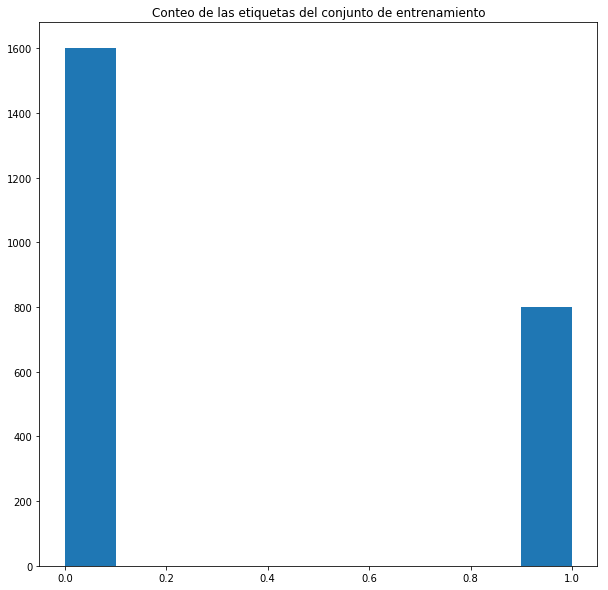

In [494]:
plt.figure(figsize=(10,10))
plt.hist(train_cu['IS_IRONIC'][:], bins=10)
plt. title('Conteo de las etiquetas del conjunto de entrenamiento')
plt.show()

Nombre de las variables que se utilizan para los datos de Cuba

In [209]:
x_train_cuba = train_cu["MESSAGE"]
x_test_cuba = test_cu["MESSAGE"]
y_train_cu = train_cu['IS_IRONIC']
y_test_cu = test_cu['IS_IRONIC_y'] 
print([y_train_cu.shape, y_test_cu.shape])  

[(2400,), (600,)]


* Limpiando Corpus de entrenamiento y de prueba

In [210]:
#Limpiando datos de entrenamiento
num = x_train_cuba.size

clean_train = []


for i in range( 0, num):

    clean_train.append(review_to_words(x_train_cuba.values[i]))

x_train_cu = clean_train

# limpiando datos de entrenamiento
num= x_test_cuba.size

clean_test_train = []


for i in range( 0, num):

    clean_test_train.append( review_to_words(x_test_cuba.values[i] ) )

x_test_cu = clean_test_train

Se conserva la proporción

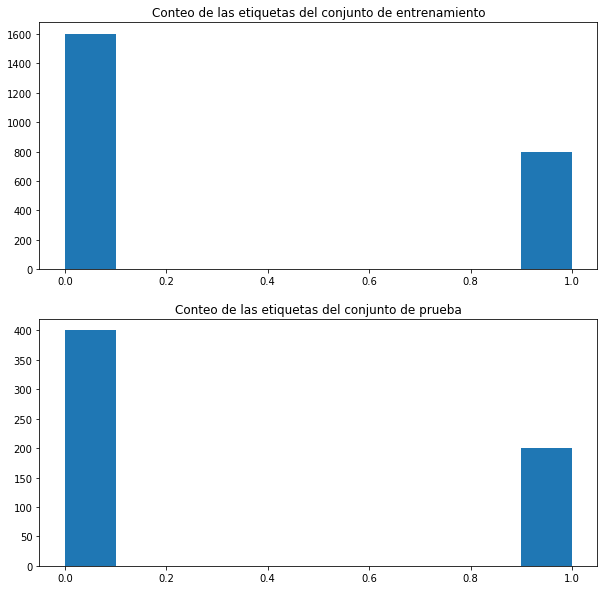

In [497]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.hist(y_train_cu, bins=10)
plt. title('Conteo de las etiquetas del conjunto de entrenamiento')
plt.subplot(212)
plt.hist(y_test_cu, bins=10)
plt. title('Conteo de las etiquetas del conjunto de prueba')
plt.show()

In [211]:
x_train_cu = train_cu["TOPIC"].astype(str).str.cat(x_train_cu, sep=' ')
x_test_cu = test_cu["TOPIC_y"].astype(str).str.cat(x_test_cu, sep=' ')

In [212]:
x_train_cu = pd.Series(x_train_cu)
y_train_cu = pd.Series(y_train_cu)
x_test_cu = pd.Series(x_test_cu)
y_test_cu = pd.Series(y_test_cu)

print(x_train_cu.shape)
print(y_train_cu.shape)
print(x_test_cu.shape)
print(y_test_cu.shape)

(2400,)
(2400,)
(600,)
(600,)


Representación BoW TF-IDF

In [213]:
vect_cu = TfidfVectorizer(min_df=.01)
x_train_tf_cu = vect_cu.fit_transform(x_train_cu)
x_test_tf_cu = vect_cu.transform(x_test_cu)

x_train_tf_cu = x_train_tf_cu.toarray()
x_test_tf_cu = x_test_tf_cu.toarray()

print(x_train_tf_cu.shape)
print(x_test_tf_cu.shape)

(2400, 291)
(600, 291)


# Clasificador NN

In [214]:
from keras.utils import to_categorical

y_train_cub = to_categorical(y_train_cu)
y_test_cub = to_categorical(y_test_cu)

num_cu, sz_cu = y_train_cub.shape

print(num_cu)
print(sz_cu)

2400
2


### Selección de modelo

* Número de epocas

In [212]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 10

nn_cu = Sequential()
nn_cu.add(Dense(200, activation='relu'))
nn_cu.add(Dropout(0.25))
nn_cu.add(Dense(sz_cu, activation='softmax'))
nn_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_cu = nn_cu.fit(x_train_tf_cu, 
              y_train_cub, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 1920 samples, validate on 480 samples
Epoch 1/10
 - 10s - loss: 0.6446 - acc: 0.6495 - val_loss: 0.7582 - val_acc: 0.4646
Epoch 2/10
 - 0s - loss: 0.5731 - acc: 0.6964 - val_loss: 1.1202 - val_acc: 0.4792
Epoch 3/10
 - 0s - loss: 0.5240 - acc: 0.7354 - val_loss: 1.4802 - val_acc: 0.4750
Epoch 4/10
 - 0s - loss: 0.4787 - acc: 0.7635 - val_loss: 1.9527 - val_acc: 0.4396
Epoch 5/10
 - 0s - loss: 0.4506 - acc: 0.7891 - val_loss: 2.2928 - val_acc: 0.4167
Epoch 6/10
 - 0s - loss: 0.4198 - acc: 0.8104 - val_loss: 2.5929 - val_acc: 0.4146
Epoch 7/10
 - 0s - loss: 0.3922 - acc: 0.8359 - val_loss: 2.9269 - val_acc: 0.4167
Epoch 8/10
 - 0s - loss: 0.3653 - acc: 0.8531 - val_loss: 3.2588 - val_acc: 0.4042
Epoch 9/10
 - 0s - loss: 0.3358 - acc: 0.8698 - val_loss: 3.6312 - val_acc: 0.3979
Epoch 10/10
 - 0s - loss: 0.3051 - acc: 0.8880 - val_loss: 3.9124 - val_acc: 0.3896
Tiempo de procesamiento (secs):  13.789531230926514


Gráfico loss values entrenamiento y prueba respecto al número de epocas

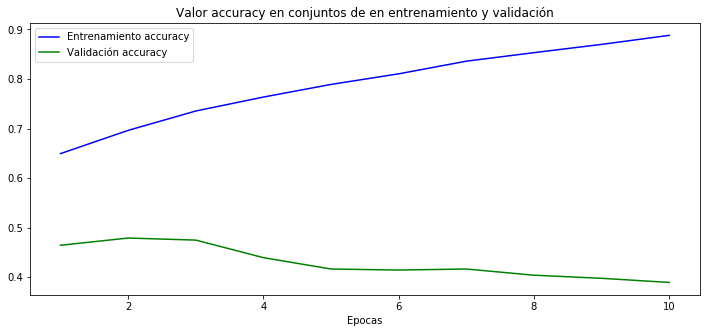

In [213]:
history_dict_cu = history_cu.history
dictkeys_cu=list(history_dict_cu.keys())
loss_values_cu = history_cu.history['acc']
val_loss_values_cu = history_cu.history['val_acc']
epochs_cu = range(1, len(loss_values_cu) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs_cu, loss_values_cu, 'b', label='Entrenamiento accuracy')
plt.plot(epochs_cu, val_loss_values_cu, 'g', label='Validación accuracy')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

Selección de nodos dado las epocas

In [226]:
batch_size = 100
epochs = 3  # epocas seleccionadas

list_nn_cu = np.arange( 1, 800, 50) # parámetro de regularización
score_train_cu = np.zeros(len(list_nn_cu)) # almacena acurracy entrenamiento
score_test_cu = np.zeros(len(list_nn_cu)) # almacena acurracy prueba
count = 0
for i in list_nn_cu:
    # Build the model
    nn_cu = Sequential()
    nn_cu.add(Dense(i, activation='relu'))
    nn_cu.add(Dropout(0.25))
    nn_cu.add(Dense(sz_cu, activation='softmax'))
    nn_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
# No se utilizan datos de validación    
    nn_cu.fit(x_train_tf_cu, 
              y_train_cub,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)
  
    temp1_cu = nn_cu.evaluate(x_train_tf_cu, y_train_cub, verbose=0)
    score_train_cu[count] = temp1_cu[1]
    temp2_cu= nn_cu.evaluate(x_test_tf_cu, y_test_cub, verbose=0)
    score_test_cu[count]= temp2_cu[1]
    count = count + 1 

Gráfico accuracy entrenamiento y prueba respecto al número de nodos

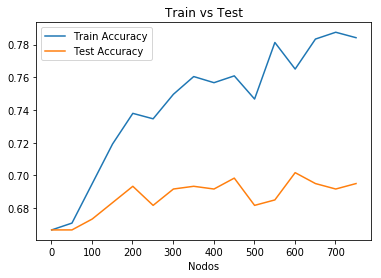

In [227]:
matriz_cu = np.matrix(np.c_[list_nn_cu, score_train_cu, score_test_cu])
models_cu = pd.DataFrame(data = matriz_cu, columns = 
             ['Nodos', 'Train Accuracy', 'Test Accuracy'])
plt.plot(models_cu['Nodos'],models_cu['Train Accuracy'])
plt.plot(models_cu['Nodos'],models_cu['Test Accuracy'])
plt.title('Train vs Test')
plt.xlabel('Nodos')
plt.legend()
plt.show()

In [228]:
models_cu

,Nodos,Train Accuracy,Test Accuracy
0,1.0,0.666667,0.666667
1,51.0,0.670833,0.666667
2,101.0,0.695000,0.673333
3,151.0,0.719167,0.683333
4,201.0,0.737917,0.693333
5,251.0,0.734583,0.681667
6,301.0,0.749583,0.691667
7,351.0,0.760417,0.693333
8,401.0,0.756667,0.691667
9,451.0,0.760833,0.698333


In [371]:
nodo_cu = list_nn_cu[np.argmax(np.array(models_cu['Test Accuracy']))]
nodo_cu

601

* Diseño del modelo

In [108]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 5

nn_cu = Sequential()
nn_cu.add(Dense(nodo_cu, activation='relu'))
nn_cu.add(Dropout(0.25))
nn_cu.add(Dense(sz_cu, activation='softmax'))
nn_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_cu = nn_cu.fit(x_train_tf_cu, 
              y_train_cub, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


Train on 1920 samples, validate on 480 samples
Epoch 1/5
 - 2s - loss: 0.6387 - acc: 0.6583 - val_loss: 0.7554 - val_acc: 0.4604
Epoch 2/5
 - 0s - loss: 0.5678 - acc: 0.6911 - val_loss: 1.1478 - val_acc: 0.4750
Epoch 3/5
 - 0s - loss: 0.5081 - acc: 0.7474 - val_loss: 1.5150 - val_acc: 0.4854
Epoch 4/5
 - 0s - loss: 0.4684 - acc: 0.7729 - val_loss: 2.0142 - val_acc: 0.4208
Epoch 5/5
 - 0s - loss: 0.4319 - acc: 0.8047 - val_loss: 2.3807 - val_acc: 0.4042
Tiempo de procesamiento (secs):  3.1972484588623047


* Guardar el modelo

In [215]:
from keras.models import load_model
#nn_cu.save('nn_cuba_tfidf')  # Guarda modelo
nn_cu = load_model('nn_cuba_tfidf') # Carga modelo

In [216]:
results_cu = nn_cu.evaluate(x_test_tf_cu, y_test_cub)
print('Test loss:', results_cu[0])
print('Test accuracy:', results_cu[1])

600/600 [==============================] - 1s 1ms/step
Test loss: 0.9913563903172811
Test accuracy: 0.6116666674613953


In [217]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
y_pred_cu = nn_cu.predict(x_test_tf_cu).squeeze()
y_test_label_cu = np.argmax(y_test_cub,1) 
y_pred_label_cu = np.argmax(y_pred_cu,1)

# Confusion matrix
C=confusion_matrix(y_test_label_cu , y_pred_label_cu)
print(C)

[[267 133]
 [100 100]]


### Resultados

In [218]:
print('Accuracy score:', results_cu[1])  # nn evaluate keras
print("F1 score", f1_score(y_test_label_cu,  y_pred_label_cu,   average='macro'))
print("F1 weighted", f1_score(y_test_label_cu,  y_pred_label_cu,    average='weighted'))
print("Recall score", recall_score(y_test_label_cu,  y_pred_label_cu,  average='macro'))
print("Precision score", precision_score(y_test_label_cu,  y_pred_label_cu,  average='macro'))


Accuracy score: 0.6116666674613953
F1 score 0.5790563998181331
F1 weighted 0.618110611612784
Recall score 0.58375
Precision score 0.5783524926617628


In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_test_label_cu, y_pred_label_cu,  target_names=['no-ironia','ironia']))

              precision    recall  f1-score   support

   no-ironia       0.73      0.67      0.70       400
      ironia       0.43      0.50      0.46       200

   micro avg       0.61      0.61      0.61       600
   macro avg       0.58      0.58      0.58       600
weighted avg       0.63      0.61      0.62       600



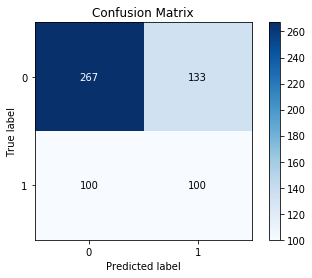

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_label_cu, y_pred_label_cu)

# Clasificador SVM

* Selección de modelo

In [219]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=1000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.1,10,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(x_train_tf_cu, y_train_cu.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svm_cu = linearSVC.best_estimator_
svm_cu.fit(x_train_tf_cu, y_train_cu.values)
svm_cu.coef_ = svm_cu.named_steps['SVC'].coef_
svm_cu.score(x_train_tf_cu, y_train_cu.values)
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.1}
Tiempo de procesamiento (secs):  37.55752992630005


* Guardad modelo

In [220]:
from joblib import dump, load
#dump(svm_cu, 'svm_cuba_tfidf.joblib') # Guardad modelo
svm_cu = load('svm_cuba_tfidf.joblib') # Cargar modelo


In [221]:
prediction_cu=svm_cu.predict(x_test_tf_cu)
print("Acurracy Test",metrics.accuracy_score(prediction_es, y_test_es.values))

Acurracy Test 0.715


In [49]:
print("Confusion Metrix:\n",metrics.confusion_matrix(y_test_cu.values, prediction_cu))

Confusion Metrix:
 [[261 139]
 [ 86 114]]


### Resultados

In [222]:
print('Accuracy score:',metrics.accuracy_score(y_test_cu.values, prediction_cu ))  # svm evaluate keras
print("F1 score", f1_score(y_test_cu.values, prediction_cu ,  average='macro'))
print("F1 weighted", f1_score(y_test_cu.values, prediction_cu ,  average='weighted'))
print("Recall score", recall_score(y_test_cu.values, prediction_cu ,  average='macro'))
print("Precision score", precision_score(y_test_cu.values, prediction_cu ,  average='macro'))

Accuracy score: 0.625
F1 score 0.6010532195005187
F1 weighted 0.6336338732413096
Recall score 0.61125
Precision score 0.6013771343303983


In [62]:
from sklearn.metrics import classification_report
print(classification_report( y_test_cu.values, prediction_cu, target_names=['no-ironia','ironia']))

              precision    recall  f1-score   support

   no-ironia       0.75      0.65      0.70       400
      ironia       0.45      0.57      0.50       200

   micro avg       0.62      0.62      0.62       600
   macro avg       0.60      0.61      0.60       600
weighted avg       0.65      0.62      0.63       600



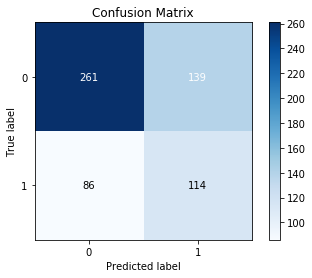

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_cu.values, prediction_cu)

Selección de tperminos $\chi^2$

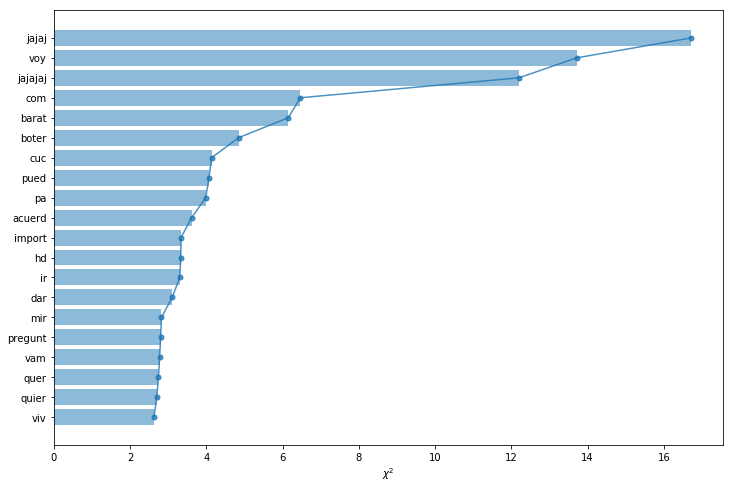

In [245]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
# compute chi2 for each feature
chi2score_cu = chi2(x_train_tf_cu,y_train_cu)[0]


%matplotlib inline
plt.figure(figsize=(12,8))
scores_cu = list(zip(vect_cu.get_feature_names(), chi2score_cu))
chi2_cu = sorted(scores_cu, key=lambda x:x[1])
topchi2_cu = list(zip(*chi2_cu[-20:]))
x_cu = range(len(topchi2_cu[1]))
labels_cu = topchi2_cu[0]
plt.barh(x_es,topchi2_cu[1], align='center', alpha=0.5)
plt.plot(topchi2_cu[1], x_cu, '-o', markersize=5, alpha=0.8)
plt.yticks(x_cu, labels_cu)
plt.xlabel('$\chi^2$')
plt.show();

# Parte II Word2Vec



# Word2vec Google


In [223]:
# Bibliotecas
import numpy as np 
import pandas as pd 
import re # lidia con expresiones regulares
import nltk
from bs4 import BeautifulSoup    
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize # sentencia en palabras
from nltk.stem import SnowballStemmer # idioma steam
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
import os
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
#path = get_tmpfile("word2vec.model")
#import gensim
from time import time
import multiprocessing
#cores = multiprocessing.cpu_count() 
#import gensim
#from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

* Cargar modelo word2vec google

In [224]:
# Load Google's pre-trained Word2Vec model.
os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\word2vec Google news')
modelo_google = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


* Función que tokeniza datos de entrenamiento y prueba, extra sus caracteristicas y toma la respectiva media

In [225]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # i si el vector está vacio introdicir ceros de la dimensión necesaria
        self.dim = len(word2vec.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

### Word2vec google México

In [69]:
x_train.head()
print(x_train.shape)

(2400,)


In [70]:
x_test.head()
print(x_test.shape)

(600,)


* Limpiar corpus de entrenamiento y de prueba.

Nota: bajo esta representación no se utiliza stemmead

In [226]:
 #Limpiando datos de entrenamiento
num= x_train.size

clean_train = []

for i in range( 0, num):

    clean_train.append( review_to_words(x_train.values[i] ) )

x_train_w2vgoogle_mx = clean_train

In [72]:
x_train_w2vgoogle_mx[0]

'ric econom pobr objet'

In [227]:
#Limpiando datos de prueba
num= x_test.size

clean_test = []

for i in range( 0, num):

    clean_test.append( review_to_words(x_test.values[i] ) )

x_test_w2vgoogle_mx = clean_test


In [74]:
x_test_w2vgoogle_mx[0]

'indign postur muj mexican vend años ser espos telenovel llam espos presid cambi ser complic corrupcion cas blanc diner acas prostitu'

In [228]:
x_train_w2vgoogle_mx = train["TOPIC"].astype(str).str.cat(x_train_w2vgoogle_mx, sep=' ')
x_test_w2vgoogle_mx = test["TOPIC_y"].astype(str).str.cat(x_test_w2vgoogle_mx, sep=' ')


In [76]:
x_train_w2vgoogle_mx[0]

'asuntosConacyt ric econom pobr objet'

* Word2Vec Google caracteristicas media (w2v avg)

In [229]:
mean_embedding_vectorizer_google_mx = MeanEmbeddingVectorizer(modelo_google)
mean_emb_train_w2vgoogle_mx = mean_embedding_vectorizer_google_mx.fit_transform(x_train_w2vgoogle_mx)

mean_emb_test_w2vgoogle_mx = mean_embedding_vectorizer_google_mx.fit_transform(x_test_w2vgoogle_mx)

C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


### Clasificador NN

In [230]:
from keras.utils import to_categorical

y_train_w2vgoogle_mx = to_categorical(y_train)
y_test_w2vgoogle_mx  = to_categorical(y_test)

num_mx, sz_mx = y_train_w2vgoogle_mx.shape

print(num_mx)
print(sz_mx)

2400
2


### Selección de modelos
* Número de epocas

In [285]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 10

nn_w2vgoogle_mx = Sequential()
nn_w2vgoogle_mx.add(Dense(100, activation='relu'))
nn_w2vgoogle_mx.add(Dropout(0.25))
nn_w2vgoogle_mx.add(Dense(sz_mx, activation='softmax'))
nn_w2vgoogle_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vgoogle_mx = nn_w2vgoogle_mx.fit(mean_emb_train_w2vgoogle_mx, 
              y_train_w2vgoogle_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 1920 samples, validate on 480 samples
Epoch 1/10
 - 11s - loss: 0.6722 - acc: 0.6096 - val_loss: 0.5098 - val_acc: 0.8854
Epoch 2/10
 - 0s - loss: 0.6478 - acc: 0.6359 - val_loss: 0.4954 - val_acc: 0.8854
Epoch 3/10
 - 0s - loss: 0.6337 - acc: 0.6469 - val_loss: 0.5443 - val_acc: 0.8604
Epoch 4/10
 - 0s - loss: 0.6188 - acc: 0.6656 - val_loss: 0.4945 - val_acc: 0.8646
Epoch 5/10
 - 0s - loss: 0.6053 - acc: 0.6766 - val_loss: 0.6019 - val_acc: 0.7687
Epoch 6/10
 - 0s - loss: 0.5930 - acc: 0.6865 - val_loss: 0.5363 - val_acc: 0.8208
Epoch 7/10
 - 0s - loss: 0.5775 - acc: 0.6953 - val_loss: 0.5183 - val_acc: 0.8333
Epoch 8/10
 - 0s - loss: 0.5623 - acc: 0.7156 - val_loss: 0.4184 - val_acc: 0.8708
Epoch 9/10
 - 0s - loss: 0.5610 - acc: 0.7073 - val_loss: 0.4788 - val_acc: 0.8604
Epoch 10/10
 - 0s - loss: 0.5410 - acc: 0.7328 - val_loss: 0.4509 - val_acc: 0.8625
Tiempo de procesamiento (secs):  13.271068811416626


Gráfico loss values de entrenamiento y validación respecto a las epocas

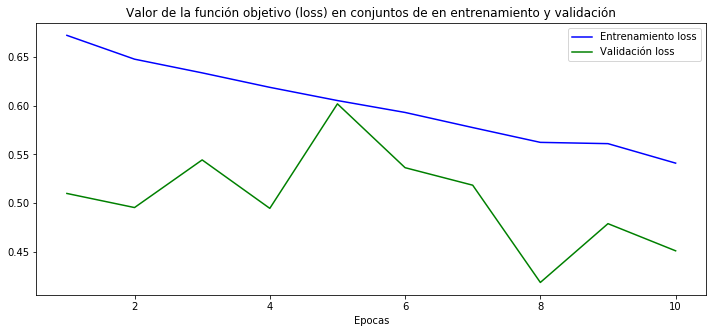

In [286]:
history_dict_w2vgoogle_mx = history_w2vgoogle_mx.history
dictkeys_w2vgoogle_mx=list(history_dict_w2vgoogle_mx.keys())
dictkeys_w2vgoogle_mx
loss_values_w2vgoogle_mx = history_w2vgoogle_mx.history['loss']
val_loss_values_w2vgoogle_mx = history_w2vgoogle_mx.history['val_loss']
epochs_w2vgoogle_mx = range(1, len(loss_values_w2vgoogle_mx) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs_w2vgoogle_mx, loss_values_w2vgoogle_mx, 'b', label='Entrenamiento loss')
plt.plot(epochs_w2vgoogle_mx, val_loss_values_w2vgoogle_mx, 'g', label='Validación loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

Seleccionando el número de nodos

In [287]:
batch_size = 100
epochs = 5 # epocas seleccionadas

list_nn_w2vgoogle_mx = np.arange( 1, 200, 50) # parámetro de regularización
score_train_w2vgoogle_mx = np.zeros(len(list_nn_w2vgoogle_mx)) # almacena acurr_w2vgoogle_mx entrenamiento
score_test_w2vgoogle_mx = np.zeros(len(list_nn_w2vgoogle_mx)) # almacena acurracy prueba
count = 0
for i in list_nn_w2vgoogle_mx:
    # Build the model
    nn_w2vgoogle_mx = Sequential()
    nn_w2vgoogle_mx.add(Dense(i, activation='relu'))
    nn_w2vgoogle_mx.add(Dropout(0.25))
    nn_w2vgoogle_mx.add(Dense(sz_mx, activation='softmax'))
    nn_w2vgoogle_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
# No se utilizan datos de validación    
    nn_w2vgoogle_mx.fit(mean_emb_train_w2vgoogle_mx, 
              y_train_w2vgoogle_mx,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)
  
    temp1_w2vgoogle_mx = nn_w2vgoogle_mx.evaluate(mean_emb_train_w2vgoogle_mx, y_train_w2vgoogle_mx, verbose=0)
    score_train_w2vgoogle_mx[count] = temp1_w2vgoogle_mx[1]
    temp2_w2vgoogle_mx = nn_w2vgoogle_mx.evaluate(mean_emb_test_w2vgoogle_mx, y_test_w2vgoogle_mx, verbose=0)
    score_test_w2vgoogle_mx[count]= temp2_w2vgoogle_mx[1]
    count = count + 1 

Gráfico accuracy datos de entrenamiento y prueba respecto al número de nodos

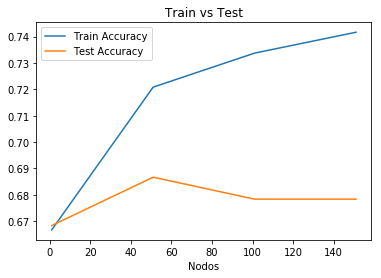

In [288]:
matriz_w2vgoogle_mx = np.matrix(np.c_[list_nn_w2vgoogle_mx, score_train_w2vgoogle_mx, score_test_w2vgoogle_mx])
models_w2vgoogle_mx = pd.DataFrame(data = matriz_w2vgoogle_mx, columns = 
             ['Nodos', 'Train Accuracy', 'Test Accuracy'])
plt.plot(models_w2vgoogle_mx['Nodos'],models_w2vgoogle_mx['Train Accuracy'])
plt.plot(models_w2vgoogle_mx['Nodos'],models_w2vgoogle_mx['Test Accuracy'])
plt.title('Train vs Test')
plt.xlabel('Nodos')
plt.legend()
plt.show()

In [289]:
models_w2vgoogle_mx

,Nodos,Train Accuracy,Test Accuracy
0,1.0,0.666667,0.668333
1,51.0,0.720833,0.686667
2,101.0,0.733750,0.678333
3,151.0,0.741667,0.678333


In [143]:
# Número de nodos seleccionados
nodo_w2vgoogle_mx=51

* Diseño final

In [144]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 5

nn_w2vgoogle_mx = Sequential()
nn_w2vgoogle_mx.add(Dense(nodo_w2vgoogle_mx, activation='relu'))
nn_w2vgoogle_mx.add(Dropout(0.25))
nn_w2vgoogle_mx.add(Dense(sz_mx, activation='softmax'))
nn_w2vgoogle_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vgoogle_mx = nn_w2vgoogle_mx.fit(mean_emb_train_w2vgoogle_mx, 
              y_train_w2vgoogle_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


Train on 1920 samples, validate on 480 samples
Epoch 1/5
 - 4s - loss: 0.6711 - acc: 0.6107 - val_loss: 0.5061 - val_acc: 0.8854
Epoch 2/5
 - 0s - loss: 0.6498 - acc: 0.6255 - val_loss: 0.4891 - val_acc: 0.8854
Epoch 3/5
 - 0s - loss: 0.6383 - acc: 0.6432 - val_loss: 0.5238 - val_acc: 0.8688
Epoch 4/5
 - 0s - loss: 0.6251 - acc: 0.6578 - val_loss: 0.4817 - val_acc: 0.8771
Epoch 5/5
 - 1s - loss: 0.6157 - acc: 0.6656 - val_loss: 0.5610 - val_acc: 0.8000
Tiempo de procesamiento (secs):  6.839789867401123


* Guardar de modelo

In [231]:
from keras.models import load_model
#nn_w2vgoogle_mx.save('nn_mexico_w2vgoogle')  # Guardar modelo
nn_w2vgoogle_mx = load_model('nn_mexico_w2vgoogle') # Cargar modelo

In [232]:
results_w2vgoogle_mx = nn_w2vgoogle_mx.evaluate(mean_emb_test_w2vgoogle_mx, y_test_w2vgoogle_mx)
print('Test loss:', results_w2vgoogle_mx[0])
print('Test accuracy:', results_w2vgoogle_mx[1])

600/600 [==============================] - 0s 821us/step
Test loss: 0.6330192804336547
Test accuracy: 0.676666665871938


In [233]:
y_pred_w2vgoogle_mx = nn_w2vgoogle_mx.predict(mean_emb_test_w2vgoogle_mx).squeeze()

import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

y_test_label_w2vgoogle_mx = np.argmax(y_test_w2vgoogle_mx,1) 
y_pred_label_w2vgoogle_mx = np.argmax(y_pred_w2vgoogle_mx,1)

# Confusion matrix
C=confusion_matrix(y_test_label_w2vgoogle_mx , y_pred_label_w2vgoogle_mx)
print(C)


[[336  65]
 [129  70]]


### Resultados

In [234]:

print('Accuracy score:', results_w2vgoogle_mx[1])  # nn evaluate keras
print("F1 score", f1_score( y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx, average='macro'))
print("F1 weighted", f1_score( y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,   average='weighted'))
print("Recall score", recall_score( y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,   average='macro'))
print("Precision score", precision_score( y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,  average='macro'))



Accuracy score: 0.676666665871938
F1 score 0.5975716004480647
F1 weighted 0.6576362747945219
Recall score 0.5948320154387899
Precision score 0.6205495818399044


In [235]:

from sklearn.metrics import classification_report
print(classification_report(y_test_label_w2vgoogle_mx, y_pred_label_w2vgoogle_mx, target_names=['no-ironia','ironia']))


              precision    recall  f1-score   support

   no-ironia       0.72      0.84      0.78       401
      ironia       0.52      0.35      0.42       199

   micro avg       0.68      0.68      0.68       600
   macro avg       0.62      0.59      0.60       600
weighted avg       0.65      0.68      0.66       600



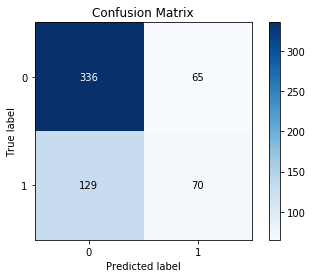

In [85]:

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_label_w2vgoogle_mx, y_pred_label_w2vgoogle_mx)

# Clasificador SVM

* Selección de modelo

In [466]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=3000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.1,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(mean_emb_train_w2vgoogle_mx, y_train.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_w2vgoogle_mx = linearSVC.best_estimator_
svc_w2vgoogle_mx.fit(mean_emb_train_w2vgoogle_mx, y_train.values)
svc_w2vgoogle_mx.coef_ = svc_w2vgoogle_mx.named_steps['SVC'].coef_
svc_w2vgoogle_mx.score(mean_emb_train_w2vgoogle_mx, y_train.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 1.4000000000000001}
Tiempo de procesamiento (secs):  132.83149933815002


Gráfico acurracy datos de entrenamiento y de prueba respecto al parámetro de rugularización

* Guardar modelo

In [236]:
from joblib import dump, load
#dump(svc_w2vgoogle_mx, 'svc_w2vgoogle_mx.joblib') 
svc_w2vgoogle_mx = load('svc_w2vgoogle_mx.joblib') 


In [64]:
prediction_w2vgoogle_mx=svc_w2vgoogle_mx.predict(mean_emb_test_w2vgoogle_mx)
print("Confusion Metrix:\n",metrics.confusion_matrix(y_test.values, prediction_w2vgoogle_mx))

Confusion Metrix:
 [[278 123]
 [ 85 114]]


### Resultados

In [237]:
print('Accuracy score:', metrics.accuracy_score( y_test.values, prediction_w2vgoogle_mx,))  # nn evaluate keras
print("F1 score", f1_score(y_test.values, prediction_w2vgoogle_mx,  average='macro'))
print("F1 weighted", f1_score(y_test.values, prediction_w2vgoogle_mx, average='weighted'))
print("Recall score", recall_score(y_test.values, prediction_w2vgoogle_mx,  average='macro'))
print("Precision score", precision_score(y_test.values, prediction_w2vgoogle_mx, average='macro'))

Accuracy score: 0.6533333333333333
F1 score 0.6253422354579952
F1 weighted 0.6598190755239606
Recall score 0.633065577262873
Precision score 0.6234264393067614


In [238]:
from sklearn.metrics import classification_report
print(classification_report(y_test.values, prediction_w2vgoogle_mx,  target_names=['no-ironia','ironia']))




              precision    recall  f1-score   support

   no-ironia       0.77      0.69      0.73       401
      ironia       0.48      0.57      0.52       199

   micro avg       0.65      0.65      0.65       600
   macro avg       0.62      0.63      0.63       600
weighted avg       0.67      0.65      0.66       600



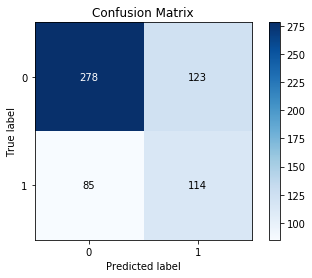

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test.values, prediction_w2vgoogle_mx)



# Word2vec google  España

In [91]:
x_train_españa.head()
print(x_train_españa.shape)


(2400,)


In [92]:
x_test_españa.head()
print(x_test_españa.shape)

(600,)


* Limpiando corpus de entrenamiento y de prueba

In [239]:
#Limpiando datos de entrenamiento
num= x_train_españa.size

clean_train_es = []


for i in range( 0, num):

    clean_train_es.append( review_to_words2(x_train_españa.values[i] ) )

x_train_w2vgoogle_es = clean_train_es

In [240]:
#Limpiando datos de prueba
num= x_test_españa.size
# Lista para guardar twits limpios
clean_test_es = []


for i in range( 0, num):

    clean_test_es.append( review_to_words2(x_test_españa.values[i] ) )

x_test_w2vgoogle_es = clean_test_es


In [241]:
x_train_w2vgoogle_es = train_es["TOPIC"].astype(str).str.cat(x_train_w2vgoogle_es, sep=' ')
x_test_w2vgoogle_es = test_es["TOPIC_y"].astype(str).str.cat(x_test_w2vgoogle_es, sep=' ')

In [96]:
x_train_w2vgoogle_es[10]

'TARDÀ escuchando joan tardà carnecrudaradio febrero sé preguntarse haría psoe si pedro sánchez cárcel ocurre descorcharía cava bueno'

In [97]:
x_test_w2vgoogle_es[10]

'FRANCO decisión conoce día después auto paralizara permiso urbanístico exhumación dictador https t co nmg4terh9m'

* Representación Word2vec average

In [242]:
mean_embedding_vectorizer_google_es = MeanEmbeddingVectorizer(modelo_google)
mean_emb_train_w2vgoogle_es = mean_embedding_vectorizer_google_es.fit_transform(x_train_w2vgoogle_es)

mean_emb_test_w2vgoogle_es = mean_embedding_vectorizer_google_es.fit_transform(x_test_w2vgoogle_es)

C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


### Clasificador NN

In [243]:
from keras.utils import to_categorical

y_train_w2vgoogle_es = to_categorical(y_train_es)
y_test_w2vgoogle_es  = to_categorical(y_test_es)

num_es, sz_es = y_train_w2vgoogle_es.shape

print(num_es)
print(sz_es)

2400
2


### Selección de modelo

* Número de epocas

In [313]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 5

nn_w2vgoogle_es = Sequential()
nn_w2vgoogle_es.add(Dense(512, activation='relu'))
nn_w2vgoogle_es.add(Dropout(0.25))
nn_w2vgoogle_es.add(Dense(sz_es, activation='softmax'))
nn_w2vgoogle_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vgoogle_es = nn_w2vgoogle_es.fit(mean_emb_train_w2vgoogle_es, 
              y_train_w2vgoogle_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 1920 samples, validate on 480 samples
Epoch 1/5
 - 15s - loss: 0.5929 - acc: 0.6820 - val_loss: 0.6702 - val_acc: 0.6354
Epoch 2/5
 - 0s - loss: 0.5595 - acc: 0.7318 - val_loss: 0.6631 - val_acc: 0.6167
Epoch 3/5
 - 0s - loss: 0.5362 - acc: 0.7422 - val_loss: 0.7379 - val_acc: 0.5625
Epoch 4/5
 - 0s - loss: 0.5126 - acc: 0.7568 - val_loss: 0.6844 - val_acc: 0.6417
Epoch 5/5
 - 0s - loss: 0.5170 - acc: 0.7521 - val_loss: 0.7277 - val_acc: 0.6417
Tiempo de procesamiento (secs):  15.89423394203186


Gráfico datos de entrenamiento y validación loss values respecto epocas

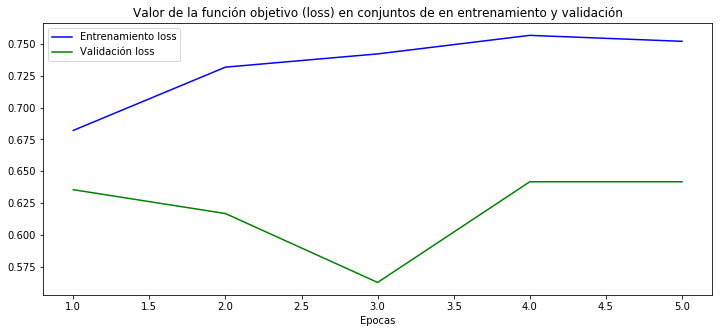

In [315]:
history_dict_w2vgoogle_es = history_w2vgoogle_es.history
dictkeys_w2vgoogle_es=list(history_dict_w2vgoogle_es.keys())
dictkeys_w2vgoogle_es

loss_values_w2vgoogle_es = history_w2vgoogle_es.history['acc']
val_loss_values_w2vgoogle_es = history_w2vgoogle_es.history['val_acc']
epochs_w2vgoogle_es = range(1, len(loss_values_w2vgoogle_es) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs_w2vgoogle_es, loss_values_w2vgoogle_es, 'b', label='Entrenamiento loss')
plt.plot(epochs_w2vgoogle_es, val_loss_values_w2vgoogle_es, 'g', label='Validación loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

* Selección del número de nodos

In [316]:
batch_size = 100
epochs = 2 # epocas seleccionadas

list_nn_w2vgoogle_es= np.arange( 1, 500, 50) # parámetro de regularización
score_train_w2vgoogle_es = np.zeros(len(list_nn_w2vgoogle_es)) # almacena acurr_w2vgoogle_mx entrenamiento
score_test_w2vgoogle_es = np.zeros(len(list_nn_w2vgoogle_es)) # almacena acurracy prueba
count = 0
for i in list_nn_w2vgoogle_es:
    # Build the model
    nn_w2vgoogle_es = Sequential()
    nn_w2vgoogle_es.add(Dense(i, activation='relu'))
    nn_w2vgoogle_es.add(Dropout(0.25))
    nn_w2vgoogle_es.add(Dense(sz_es, activation='softmax'))
    nn_w2vgoogle_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
# No se utilizan datos de validación    
    nn_w2vgoogle_es.fit(mean_emb_train_w2vgoogle_es, 
              y_train_w2vgoogle_es,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)
  
    temp1_w2vgoogle_es = nn_w2vgoogle_es.evaluate(mean_emb_train_w2vgoogle_es, y_train_w2vgoogle_es, verbose=0)
    score_train_w2vgoogle_es[count] = temp1_w2vgoogle_es[1]
    temp2_w2vgoogle_es = nn_w2vgoogle_es.evaluate(mean_emb_test_w2vgoogle_es, y_test_w2vgoogle_es, verbose=0)
    score_test_w2vgoogle_es[count]= temp2_w2vgoogle_es[1]
    count = count + 1 

Gráfica accuracy entrenameinto y prueba respecto número de nodos

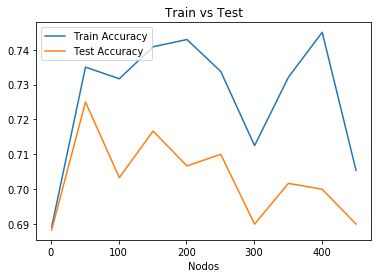

In [317]:
matriz_w2vgoogle_es = np.matrix(np.c_[list_nn_w2vgoogle_es, score_train_w2vgoogle_es, score_test_w2vgoogle_es])
models_w2vgoogle_es = pd.DataFrame(data = matriz_w2vgoogle_es, columns = 
             ['Nodos', 'Train Accuracy', 'Test Accuracy'])
plt.plot(models_w2vgoogle_es['Nodos'],models_w2vgoogle_es['Train Accuracy'])
plt.plot(models_w2vgoogle_es['Nodos'],models_w2vgoogle_es['Test Accuracy'])
plt.title('Train vs Test')
plt.xlabel('Nodos')
plt.legend()
plt.show()

In [318]:
models_w2vgoogle_es

,Nodos,Train Accuracy,Test Accuracy
0,1.0,0.689167,0.688333
1,51.0,0.735000,0.725000
2,101.0,0.731667,0.703333
3,151.0,0.740833,0.716667
4,201.0,0.742917,0.706667
5,251.0,0.733750,0.710000
6,301.0,0.712500,0.690000
7,351.0,0.732083,0.701667
8,401.0,0.745000,0.700000
9,451.0,0.705417,0.690000


In [319]:
# número de nodos seleccionados
nodo_w2vgoogle_es=151

* Diseño final

In [320]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 2

nn_w2vgoogle_es = Sequential()
nn_w2vgoogle_es.add(Dense(nodo_w2vgoogle_es, activation='relu'))
nn_w2vgoogle_es.add(Dropout(0.25))
nn_w2vgoogle_es.add(Dense(sz_es, activation='softmax'))
nn_w2vgoogle_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vgoogle_es = nn_w2vgoogle_es.fit(mean_emb_train_w2vgoogle_es, 
              y_train_w2vgoogle_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


Train on 1920 samples, validate on 480 samples
Epoch 1/2
 - 13s - loss: 0.6030 - acc: 0.6716 - val_loss: 0.6699 - val_acc: 0.6062
Epoch 2/2
 - 0s - loss: 0.5621 - acc: 0.7302 - val_loss: 0.6676 - val_acc: 0.6167
Tiempo de procesamiento (secs):  13.689913272857666


* Guardar modelo seleccionado

In [244]:
from keras.models import load_model
#nn_w2vgoogle_es.save('nn_españa_w2vgoogle')  # Guardar modelo
nn_w2vgoogle_es = load_model('nn_españa_w2vgoogle') # Cargar modelo

In [245]:
results_w2vgoogle_es = nn_w2vgoogle_es.evaluate(mean_emb_test_w2vgoogle_es, y_test_w2vgoogle_es)
print('Test loss:', results_w2vgoogle_es[0])
print('Test accuracy:', results_w2vgoogle_es[1])

600/600 [==============================] - 0s 632us/step
Test loss: 0.5817617440223694
Test accuracy: 0.698333334128062


In [246]:
y_pred_w2vgoogle_es = nn_w2vgoogle_es.predict(mean_emb_test_w2vgoogle_es).squeeze()

import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

y_test_label_w2vgoogle_es = np.argmax(y_test_w2vgoogle_es,1) 
y_pred_label_w2vgoogle_es = np.argmax(y_pred_w2vgoogle_es,1)

# Confusion matrix
C=confusion_matrix(y_test_label_w2vgoogle_es , y_pred_label_w2vgoogle_es)
print(C)


[[350  50]
 [131  69]]


### Resultados

In [247]:
print('Accuracy score:', results_w2vgoogle_es[1])  # nn evaluate keras
print("F1 score", f1_score(y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,  average='macro'))
print("F1 weighted", f1_score(y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,  average='weighted'))
print("Recall score", recall_score(y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,   average='macro'))
print("Precision score", precision_score(y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,   average='macro'))


Accuracy score: 0.698333334128062
F1 score 0.6135767633673618
F1 weighted 0.6739017241972347
Recall score 0.61
Precision score 0.6537413302119185


In [248]:
from sklearn.metrics import classification_report
print(classification_report(y_test_label_w2vgoogle_es, y_pred_label_w2vgoogle_es,target_names=['no-ironia','ironia']))

              precision    recall  f1-score   support

   no-ironia       0.73      0.88      0.79       400
      ironia       0.58      0.34      0.43       200

   micro avg       0.70      0.70      0.70       600
   macro avg       0.65      0.61      0.61       600
weighted avg       0.68      0.70      0.67       600



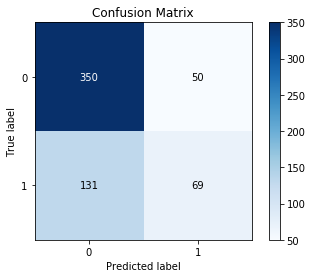

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_label_w2vgoogle_es, y_pred_label_w2vgoogle_es)


# Clasificador SVM

* Selección del modelo

In [191]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=3000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.1,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(mean_emb_train_w2vgoogle_es, y_train_es.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_w2vgoogle_es = linearSVC.best_estimator_
svc_w2vgoogle_es.fit(mean_emb_train_w2vgoogle_es, y_train_es.values)
svc_w2vgoogle_es.coef_ = svc_w2vgoogle_es.named_steps['SVC'].coef_
svc_w2vgoogle_es.score(mean_emb_train_w2vgoogle_es, y_train_es.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)


{'SVC__C': 0.1}
Tiempo de procesamiento (secs):  28.22266721725464


* Gráfica accuracy datos de entrenamiento y de prueba respecto al parámetro de regularización

* Guardar el modelo

In [249]:
from joblib import dump, load
#dump(svc_w2vgoogle_es, 'svc_w2vgoogle_es.joblib') # Guardar modelo
svc_w2vgoogle_es = load('svc_w2vgoogle_es.joblib') # Cargar modelo

In [250]:
prediction_w2vgoogle_es=svc_w2vgoogle_es.predict(mean_emb_test_w2vgoogle_es)
print("Acurracy Test",metrics.accuracy_score(prediction_w2vgoogle_es, y_test_es.values))

Acurracy Test 0.6916666666666667


In [251]:
print("Confusion Metrix:\n",metrics.confusion_matrix(y_test_es.values, prediction_w2vgoogle_es))

Confusion Metrix:
 [[299 101]
 [ 84 116]]


### Resultados

In [252]:
print('Accuracy score:', metrics.accuracy_score(y_test_es.values, prediction_w2vgoogle_es))  # nn evaluate keras
print("F1 score", f1_score(y_test_es.values, prediction_w2vgoogle_es,  average='macro'))
print("F1 weighted", f1_score(y_test_es.values, prediction_w2vgoogle_es,  average='weighted'))
print("Recall score", recall_score(y_test_es.values, prediction_w2vgoogle_es,  average='macro'))
print("Precision score", precision_score(y_test_es.values, prediction_w2vgoogle_es,  average='macro'))

Accuracy score: 0.6916666666666667
F1 score 0.6600420812775067
F1 weighted 0.6946044696809603
Recall score 0.6637500000000001
Precision score 0.6576205315782508


In [253]:
from sklearn.metrics import classification_report
print(classification_report( y_test_es.values, prediction_w2vgoogle_es, target_names=['no-ironia','ironia']))


              precision    recall  f1-score   support

   no-ironia       0.78      0.75      0.76       400
      ironia       0.53      0.58      0.56       200

   micro avg       0.69      0.69      0.69       600
   macro avg       0.66      0.66      0.66       600
weighted avg       0.70      0.69      0.69       600



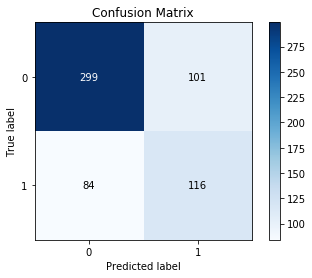

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_es.values, prediction_w2vgoogle_es)

# Word2vec google Cuba

In [112]:
x_train_cuba.head()
print(x_train_cuba.shape)

(2400,)


In [113]:
x_test_cuba.head()
print(x_test_cuba.shape)

(600,)


* Limpieza de datos

In [254]:
#Limpiando datos de entrenamiento
num= x_train_cuba.size

clean_train_cu = []

for i in range( 0, num):

    clean_train_cu.append( review_to_words2(x_train_cuba.values[i] ) )
x_train_w2vgoogle_cu = clean_train_cu

In [255]:
#Limpiando datos de prueba
num= x_test_cuba.size

clean_test_cu = []

for i in range( 0, num):
    clean_test_cu.append( review_to_words2(x_test_cuba.values[i] ) )
    
x_test_w2vgoogle_cu = clean_test_cu

In [256]:
x_train_w2vgoogle_cu = train_cu["TOPIC"].astype(str).str.cat(x_train_w2vgoogle_cu, sep=' ')
x_test_w2vgoogle_cu = test_cu["TOPIC_y"].astype(str).str.cat(x_test_w2vgoogle_cu, sep=' ')

In [117]:
x_train_w2vgoogle_cu[0]

'TELEVISIÓN DIGITAL, CAJAS DECODIFICADORAS, TELEVISIÓN CUBANA, AUDIOVISUALES magnifico'

In [118]:
x_test_w2vgoogle_cu[0]

'ECONOMÍA. TURISMOS, HOTELES oferta persona noche habitación doble hoy febrero precio normal así oferta buena'

* Representación W2vec Google average

In [257]:
mean_embedding_vectorizer_google_cu = MeanEmbeddingVectorizer(modelo_google)
mean_emb_train_w2vgoogle_cu = mean_embedding_vectorizer_google_cu.fit_transform(x_train_w2vgoogle_cu)
mean_emb_test_w2vgoogle_cu = mean_embedding_vectorizer_google_cu.fit_transform(x_test_w2vgoogle_cu)

C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


 #  Clasificador NN

In [258]:
from keras.utils import to_categorical

y_train_w2vgoogle_cu = to_categorical(y_train_cu)
y_test_w2vgoogle_cu  = to_categorical(y_test_cu)

num_cu, sz_cu = y_train_w2vgoogle_cu.shape

print(num_cu)
print(sz_cu)

2400
2


### Selección de modelos

* Número de nodos

In [166]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 10

nn_w2vgoogle_cu = Sequential()
nn_w2vgoogle_cu.add(Dense(100, activation='relu'))
nn_w2vgoogle_cu.add(Dropout(0.25))
nn_w2vgoogle_cu.add(Dense(sz_cu, activation='softmax'))
nn_w2vgoogle_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vgoogle_cu = nn_w2vgoogle_cu.fit(mean_emb_train_w2vgoogle_cu, 
              y_train_w2vgoogle_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 1920 samples, validate on 480 samples
Epoch 1/10
 - 1s - loss: 0.6600 - acc: 0.6286 - val_loss: 0.5935 - val_acc: 0.7521
Epoch 2/10
 - 0s - loss: 0.6323 - acc: 0.6609 - val_loss: 0.6373 - val_acc: 0.6833
Epoch 3/10
 - 0s - loss: 0.6257 - acc: 0.6589 - val_loss: 0.6188 - val_acc: 0.7104
Epoch 4/10
 - 0s - loss: 0.6182 - acc: 0.6719 - val_loss: 0.7117 - val_acc: 0.5938
Epoch 5/10
 - 0s - loss: 0.6066 - acc: 0.6812 - val_loss: 0.8953 - val_acc: 0.4250
Epoch 6/10
 - 0s - loss: 0.6015 - acc: 0.6880 - val_loss: 0.8363 - val_acc: 0.4646
Epoch 7/10
 - 0s - loss: 0.5896 - acc: 0.6969 - val_loss: 0.9041 - val_acc: 0.4417
Epoch 8/10
 - 0s - loss: 0.5855 - acc: 0.7036 - val_loss: 0.9716 - val_acc: 0.4479
Epoch 9/10
 - 0s - loss: 0.5844 - acc: 0.6948 - val_loss: 0.9933 - val_acc: 0.4542
Epoch 10/10
 - 0s - loss: 0.5740 - acc: 0.7042 - val_loss: 1.1088 - val_acc: 0.4438
Tiempo de procesamiento (secs):  2.8403916358947754


Gráfica accuracy datos de entrebamiento y de validación respecto al número de epocas

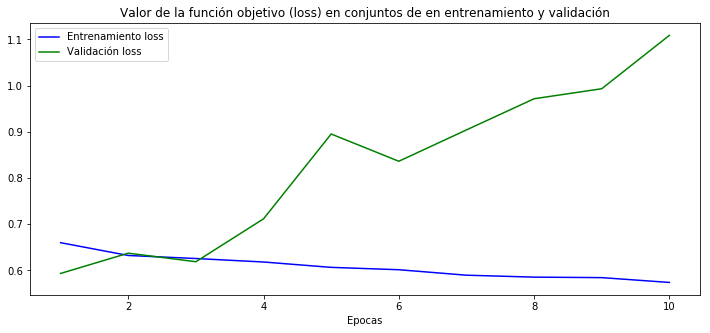

In [167]:
history_dict_w2vgoogle_cu = history_w2vgoogle_cu.history
dictkeys_w2vgoogle_cu=list(history_dict_w2vgoogle_cu.keys())
loss_values_w2vgoogle_cu = history_w2vgoogle_cu.history['loss']
val_loss_values_w2vgoogle_cu = history_w2vgoogle_cu.history['val_loss']
epochs_w2vgoogle_cu = range(1, len(loss_values_w2vgoogle_cu) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs_w2vgoogle_cu, loss_values_w2vgoogle_cu, 'b', label='Entrenamiento loss')
plt.plot(epochs_w2vgoogle_cu, val_loss_values_w2vgoogle_cu, 'g', label='Validación loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

* selección del número de nodos

In [184]:
batch_size = 100
epochs = 3 # epocas seleccionadas

list_nn_w2vgoogle_cu= np.arange( 1, 800, 50) # parámetro de regularización
score_train_w2vgoogle_cu = np.zeros(len(list_nn_w2vgoogle_cu)) # almacena acurr_w2vgoogle_mx entrenamiento
score_test_w2vgoogle_cu = np.zeros(len(list_nn_w2vgoogle_cu)) # almacena acurracy prueba
count = 0
for i in list_nn_w2vgoogle_cu:
    # Build the model
    nn_w2vgoogle_cu = Sequential()
    nn_w2vgoogle_cu.add(Dense(i, activation='relu'))
    nn_w2vgoogle_cu.add(Dropout(0.25))
    nn_w2vgoogle_cu.add(Dense(sz_cu, activation='softmax'))
    nn_w2vgoogle_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
# No se utilizan datos de validación    
    nn_w2vgoogle_cu.fit(mean_emb_train_w2vgoogle_cu, 
              y_train_w2vgoogle_cu,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)
  
    temp1_w2vgoogle_cu = nn_w2vgoogle_cu.evaluate(mean_emb_train_w2vgoogle_cu, y_train_w2vgoogle_cu, verbose=0)
    score_train_w2vgoogle_cu[count] = temp1_w2vgoogle_cu[1]
    temp2_w2vgoogle_cu = nn_w2vgoogle_cu.evaluate(mean_emb_test_w2vgoogle_cu, y_test_w2vgoogle_cu, verbose=0)
    score_test_w2vgoogle_cu[count]= temp2_w2vgoogle_cu[1]
    count = count + 1 

Gráfico accuracy datos de entrenamiento y de prueba respecto al número de nodos

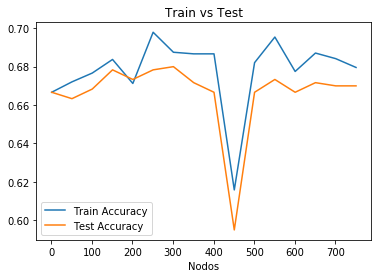

In [185]:
matriz_w2vgoogle_cu = np.matrix(np.c_[list_nn_w2vgoogle_cu, score_train_w2vgoogle_cu, score_test_w2vgoogle_cu])
models_w2vgoogle_cu = pd.DataFrame(data = matriz_w2vgoogle_cu, columns = 
             ['Nodos', 'Train Accuracy', 'Test Accuracy'])
plt.plot(models_w2vgoogle_cu['Nodos'],models_w2vgoogle_cu['Train Accuracy'])
plt.plot(models_w2vgoogle_cu['Nodos'],models_w2vgoogle_cu['Test Accuracy'])
plt.title('Train vs Test')
plt.xlabel('Nodos')
plt.legend()
plt.show()

In [186]:
models_w2vgoogle_cu

,Nodos,Train Accuracy,Test Accuracy
0,1.0,0.666667,0.666667
1,51.0,0.672083,0.663333
2,101.0,0.676667,0.668333
3,151.0,0.683750,0.678333
4,201.0,0.671250,0.673333
5,251.0,0.697917,0.678333
6,301.0,0.687500,0.680000
7,351.0,0.686667,0.671667
8,401.0,0.686667,0.666667
9,451.0,0.615833,0.595000


* Diseño final

In [183]:
nodo_w2vgoogle_cu=351#Número de nodos seleccionados

In [184]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 5

nn_w2vgoogle_cu = Sequential()
nn_w2vgoogle_cu.add(Dense(nodo_w2vgoogle_cu, activation='relu'))
nn_w2vgoogle_cu.add(Dropout(0.25))
nn_w2vgoogle_cu.add(Dense(sz_cu, activation='softmax'))
nn_w2vgoogle_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vgoogle_cu = nn_w2vgoogle_cu.fit(mean_emb_train_w2vgoogle_cu, 
              y_train_w2vgoogle_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


Train on 1920 samples, validate on 480 samples
Epoch 1/5
 - 3s - loss: 0.6486 - acc: 0.6422 - val_loss: 0.6183 - val_acc: 0.7063
Epoch 2/5
 - 0s - loss: 0.6229 - acc: 0.6719 - val_loss: 0.7912 - val_acc: 0.4313
Epoch 3/5
 - 0s - loss: 0.6159 - acc: 0.6646 - val_loss: 0.6464 - val_acc: 0.7104
Epoch 4/5
 - 0s - loss: 0.6070 - acc: 0.6885 - val_loss: 0.8108 - val_acc: 0.4792
Epoch 5/5
 - 0s - loss: 0.6019 - acc: 0.6786 - val_loss: 1.0152 - val_acc: 0.4271
Tiempo de procesamiento (secs):  3.7814528942108154


* Guardando modelo

In [259]:
from keras.models import load_model
#nn_w2vgoogle_cu.save('nn_cuba_w2vgoogle')  # Guardar modelo
nn_w2vgoogle_cu = load_model('nn_cuba_w2vgoogle') # Cargar modelo

In [260]:
results_w2vgoogle_cu = nn_w2vgoogle_cu.evaluate(mean_emb_test_w2vgoogle_cu, y_test_w2vgoogle_cu)
print('Test loss:', results_w2vgoogle_cu[0])
print('Test accuracy:', results_w2vgoogle_cu[1])

600/600 [==============================] - 0s 688us/step
Test loss: 0.7300734051068624
Test accuracy: 0.5749999992052715


In [87]:
y_pred_w2vgoogle_cu = nn_w2vgoogle_cu.predict(mean_emb_test_w2vgoogle_cu).squeeze()

import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

y_test_label_w2vgoogle_cu = np.argmax(y_test_w2vgoogle_cu,1) 
y_pred_label_w2vgoogle_cu = np.argmax(y_pred_w2vgoogle_cu,1)

# Confusion matrix
C=confusion_matrix(y_test_label_w2vgoogle_cu , y_pred_label_w2vgoogle_cu)
print(C)


[[235 165]
 [ 90 110]]


### Reusltados

In [261]:
print('Accuracy score:', results_w2vgoogle_cu[1])  # nn evaluate keras
print("F1 score", f1_score(y_test_label_w2vgoogle_cu, y_pred_label_w2vgoogle_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_label_w2vgoogle_cu, y_pred_label_w2vgoogle_cu,    average='weighted'))
print("Recall score", recall_score(y_test_label_w2vgoogle_cu, y_pred_label_w2vgoogle_cu,    average='macro'))
print("Precision score", precision_score(y_test_label_w2vgoogle_cu, y_pred_label_w2vgoogle_cu,   average='macro'))

from sklearn.metrics import classification_report
print(classification_report(y_test_label_w2vgoogle_es, y_pred_label_w2vgoogle_es, target_names=['no-ironia','ironia']))



Accuracy score: 0.5749999992052715
F1 score 0.5557168784029038
F1 weighted 0.5865698729582578
Recall score 0.5687500000000001
Precision score 0.5615384615384615
              precision    recall  f1-score   support

   no-ironia       0.73      0.88      0.79       400
      ironia       0.58      0.34      0.43       200

   micro avg       0.70      0.70      0.70       600
   macro avg       0.65      0.61      0.61       600
weighted avg       0.68      0.70      0.67       600



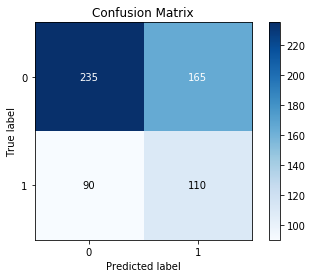

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(  y_test_label_w2vgoogle_cu, y_pred_label_w2vgoogle_cu)

# Clasificador SVM

* Selección de modelo

In [213]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.01,.2,.01)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(mean_emb_train_w2vgoogle_cu, y_train_cu.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_w2vgoogle_cu = linearSVC.best_estimator_
svc_w2vgoogle_cu.fit(mean_emb_train_w2vgoogle_cu, y_train_cu.values)
svc_w2vgoogle_cu.coef_ = svc_w2vgoogle_cu.named_steps['SVC'].coef_
svc_w2vgoogle_cu.score(mean_emb_train_w2vgoogle_cu, y_train_cu.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.04}
Tiempo de procesamiento (secs):  6.082455396652222


Gráfica ccuracy datos de entrenamiento y de prueba respecto al parámetro de regularización

* modelo seleccionado

In [262]:
from joblib import dump, load
#dump(svc_w2vgoogle_cu, 'svc_w2vgoogle_cu.joblib')   
svc_w2vgoogle_cu = load('svc_w2vgoogle_cu.joblib') 
prediction_w2vgoogle_cu=svc_w2vgoogle_cu.predict(mean_emb_test_w2vgoogle_cu)

In [90]:
print("Confusion Metrix:\n",metrics.confusion_matrix(y_test_cu.values, prediction_w2vgoogle_cu))

Confusion Metrix:
 [[256 144]
 [ 80 120]]


### Resultados

In [263]:
print('Accuracy score:', metrics.accuracy_score(y_test_cu.values, prediction_w2vgoogle_cu))  # nn evaluate keras
print("F1 score", f1_score(y_test_cu.values, prediction_w2vgoogle_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_cu.values, prediction_w2vgoogle_cu,  average='weighted'))
print("Recall score", recall_score(y_test_cu.values, prediction_w2vgoogle_cu,  average='macro'))
print("Precision score", precision_score(y_test_cu.values, prediction_w2vgoogle_cu,  average='macro'))

Accuracy score: 0.6266666666666667
F1 score 0.6064467766116941
F1 weighted 0.6361819090454772
Recall score 0.62
Precision score 0.6082251082251082


In [129]:
from sklearn.metrics import classification_report
print(classification_report( y_test_cu.values, prediction_w2vgoogle_cu, target_names=['no-ironia','ironia']))

              precision    recall  f1-score   support

   no-ironia       0.76      0.64      0.70       400
      ironia       0.45      0.60      0.52       200

   micro avg       0.63      0.63      0.63       600
   macro avg       0.61      0.62      0.61       600
weighted avg       0.66      0.63      0.64       600



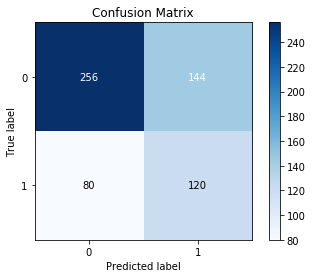

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_cu.values, prediction_w2vgoogle_cu)

In [264]:
del modelo_google

 # Word2vec Twitter 

* Cargar modelo entrenado

In [265]:
import os
os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos\\word2vec-twitter-master')


In [158]:
#pip install virtualenv

In [159]:
#pip install -r requirements.txt 

In [160]:
#pip install word2vecReaderUtils 

* La intalación y procedimiento se relaiza en base a Word2Vec 400M Tweets Embedding model based on https://www.fredericgodin.com/software/ y loretoparisi: Word2Vec 400M Tweets Embedding model based on https://www.fredericgodin.com/software/

* La siguientes dos funciones cargan el modelo pr-entreado " Word2Vec 400M Tweets Embedding model"

In [266]:
# %load word2vecReaderUtils.py
#!/usr/bin/env python
#
# Copyright (C) 2010 Radim Rehurek <radimrehurek@seznam.cz>
# Licensed under the GNU LGPL v2.1 - http://www.gnu.org/licenses/lgpl.html

"""
This module contains various general utility functions.
"""

from __future__ import with_statement

import logging
logger = logging.getLogger('gensim.utils')

try:
    from html.entities import name2codepoint as n2cp
except ImportError:
    from htmlentitydefs import name2codepoint as n2cp
try:
    import cPickle as _pickle
except ImportError:
    import pickle as _pickle

import re
import unicodedata
import os
import random
import itertools
import tempfile
from functools import wraps # for `synchronous` function lock
import multiprocessing
import shutil
import sys
import traceback
from contextlib import contextmanager

import numpy
import scipy.sparse

if sys.version_info[0] >= 3:
    unicode = str

from six import iteritems, u, string_types
from six.moves import xrange

try:
    from pattern.en import parse
    logger.info("'pattern' package found; utils.lemmatize() is available for English")
    HAS_PATTERN = True
except ImportError:
    HAS_PATTERN = False


PAT_ALPHABETIC = re.compile('(((?![\d])\w)+)', re.UNICODE)
RE_HTML_ENTITY = re.compile(r'&(#?)(x?)(\w+);', re.UNICODE)



def synchronous(tlockname):
    """
    A decorator to place an instance-based lock around a method.

    Adapted from http://code.activestate.com/recipes/577105-synchronization-decorator-for-class-methods/
    """
    def _synched(func):
        @wraps(func)
        def _synchronizer(self, *args, **kwargs):
            tlock = getattr(self, tlockname)
            logger.debug("acquiring lock %r for %s" % (tlockname, func.func_name))

            with tlock: # use lock as a context manager to perform safe acquire/release pairs
                logger.debug("acquired lock %r for %s" % (tlockname, func.func_name))
                result = func(self, *args, **kwargs)
                logger.debug("releasing lock %r for %s" % (tlockname, func.func_name))
                return result
        return _synchronizer
    return _synched


class NoCM(object):
    def acquire(self):
        pass
    def release(self):
        pass
    def __enter__(self):
        pass
    def __exit__(self, type, value, traceback):
        pass
nocm = NoCM()


@contextmanager
def file_or_filename(input):
    """
    Return a file-like object ready to be read from the beginning. `input` is either
    a filename (gz/bz2 also supported) or a file-like object supporting seek.

    """
    if isinstance(input, string_types):
        # input was a filename: open as text file
        with smart_open(input) as fin:
            yield fin
    else:
        input.seek(0)
        yield input


def deaccent(text):
    """
    Remove accentuation from the given string. Input text is either a unicode string or utf8 encoded bytestring.

    Return input string with accents removed, as unicode.

    >>> deaccent("Šéf chomutovských komunistů dostal poštou bílý prášek")
    u'Sef chomutovskych komunistu dostal postou bily prasek'

    """
    if not isinstance(text, unicode):
        # assume utf8 for byte strings, use default (strict) error handling
        text = text.decode('utf8')
    norm = unicodedata.normalize("NFD", text)
    result = u('').join(ch for ch in norm if unicodedata.category(ch) != 'Mn')
    return unicodedata.normalize("NFC", result)


def copytree_hardlink(source, dest):
    """
    Recursively copy a directory ala shutils.copytree, but hardlink files
    instead of copying. Available on UNIX systems only.
    """
    copy2 = shutil.copy2
    try:
        shutil.copy2 = os.link
        shutil.copytree(source, dest)
    finally:
        shutil.copy2 = copy2


def tokenize(text, lowercase=False, deacc=False, errors="strict", to_lower=False, lower=False):
    """
    Iteratively yield tokens as unicode strings, optionally also lowercasing them
    and removing accent marks.

    Input text may be either unicode or utf8-encoded byte string.

    The tokens on output are maximal contiguous sequences of alphabetic
    characters (no digits!).

    >>> list(tokenize('Nic nemůže letět rychlostí vyšší, než 300 tisíc kilometrů za sekundu!', deacc = True))
    [u'Nic', u'nemuze', u'letet', u'rychlosti', u'vyssi', u'nez', u'tisic', u'kilometru', u'za', u'sekundu']

    """
    lowercase = lowercase or to_lower or lower
    text = to_unicode(text, errors=errors)
    if lowercase:
        text = text.lower()
    if deacc:
        text = deaccent(text)
    for match in PAT_ALPHABETIC.finditer(text):
        yield match.group()


def simple_preprocess(doc, deacc=False, min_len=2, max_len=15):
    """
    Convert a document into a list of tokens.

    This lowercases, tokenizes, stems, normalizes etc. -- the output are final
    tokens = unicode strings, that won't be processed any further.

    """
    tokens = [token for token in tokenize(doc, lower=True, deacc=deacc, errors='ignore')
            if min_len <= len(token) <= max_len and not token.startswith('_')]
    return tokens


def any2utf8(text, errors='strict', encoding='utf8'):
    """Convert a string (unicode or bytestring in `encoding`), to bytestring in utf8."""
    if isinstance(text, unicode):
        return text.encode('utf8')
    # do bytestring -> unicode -> utf8 full circle, to ensure valid utf8
    return unicode(text, encoding, errors=errors).encode('utf8')
to_utf8 = any2utf8


def any2unicode(text, encoding='utf8', errors='strict'):
    """Convert a string (bytestring in `encoding` or unicode), to unicode."""
    if isinstance(text, unicode):
        return text
    return unicode(text, encoding, errors=errors)
to_unicode = any2unicode


class SaveLoad(object):
    """
    Objects which inherit from this class have save/load functions, which un/pickle
    them to disk.

    This uses pickle for de/serializing, so objects must not contain
    unpicklable attributes, such as lambda functions etc.

    """
    @classmethod
    def load(cls, fname, mmap=None):
        """
        Load a previously saved object from file (also see `save`).

        If the object was saved with large arrays stored separately, you can load
        these arrays via mmap (shared memory) using `mmap='r'`. Default: don't use
        mmap, load large arrays as normal objects.

        """
        logger.info("loading %s object from %s" % (cls.__name__, fname))
        subname = lambda suffix: fname + '.' + suffix + '.npy'
        obj = unpickle(fname)
        for attrib in getattr(obj, '__numpys', []):
            logger.info("loading %s from %s with mmap=%s" % (attrib, subname(attrib), mmap))
            setattr(obj, attrib, numpy.load(subname(attrib), mmap_mode=mmap))
        for attrib in getattr(obj, '__scipys', []):
            logger.info("loading %s from %s with mmap=%s" % (attrib, subname(attrib), mmap))
            sparse = unpickle(subname(attrib))
            sparse.data = numpy.load(subname(attrib) + '.data.npy', mmap_mode=mmap)
            sparse.indptr = numpy.load(subname(attrib) + '.indptr.npy', mmap_mode=mmap)
            sparse.indices = numpy.load(subname(attrib) + '.indices.npy', mmap_mode=mmap)
            setattr(obj, attrib, sparse)
        for attrib in getattr(obj, '__ignoreds', []):
            logger.info("setting ignored attribute %s to None" % (attrib))
            setattr(obj, attrib, None)
        return obj

    def save(self, fname, separately=None, sep_limit=10 * 1024**2, ignore=frozenset()):
        """
        Save the object to file (also see `load`).

        If `separately` is None, automatically detect large numpy/scipy.sparse arrays
        in the object being stored, and store them into separate files. This avoids
        pickle memory errors and allows mmap'ing large arrays back on load efficiently.

        You can also set `separately` manually, in which case it must be a list of attribute
        names to be stored in separate files. The automatic check is not performed in this case.

        `ignore` is a set of attribute names to *not* serialize (file handles, caches etc). On
        subsequent load() these attributes will be set to None.

        """
        logger.info("saving %s object under %s, separately %s" % (self.__class__.__name__, fname, separately))
        subname = lambda suffix: fname + '.' + suffix + '.npy'
        tmp = {}
        if separately is None:
            separately = []
            for attrib, val in iteritems(self.__dict__):
                if isinstance(val, numpy.ndarray) and val.size >= sep_limit:
                    separately.append(attrib)
                elif isinstance(val, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)) and val.nnz >= sep_limit:
                    separately.append(attrib)

        # whatever's in `separately` or `ignore` at this point won't get pickled anymore
        for attrib in separately + list(ignore):
            if hasattr(self, attrib):
                tmp[attrib] = getattr(self, attrib)
                delattr(self, attrib)

        try:
            numpys, scipys, ignoreds = [], [], []
            for attrib, val in iteritems(tmp):
                if isinstance(val, numpy.ndarray) and attrib not in ignore:
                    numpys.append(attrib)
                    logger.info("storing numpy array '%s' to %s" % (attrib, subname(attrib)))
                    numpy.save(subname(attrib), numpy.ascontiguousarray(val))
                elif isinstance(val, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)) and attrib not in ignore:
                    scipys.append(attrib)
                    logger.info("storing scipy.sparse array '%s' under %s" % (attrib, subname(attrib)))
                    numpy.save(subname(attrib) + '.data.npy', val.data)
                    numpy.save(subname(attrib) + '.indptr.npy', val.indptr)
                    numpy.save(subname(attrib) + '.indices.npy', val.indices)
                    data, indptr, indices = val.data, val.indptr, val.indices
                    val.data, val.indptr, val.indices = None, None, None
                    try:
                        pickle(val, subname(attrib)) # store array-less object
                    finally:
                        val.data, val.indptr, val.indices = data, indptr, indices
                else:
                    logger.info("not storing attribute %s" % (attrib))
                    ignoreds.append(attrib)
            self.__dict__['__numpys'] = numpys
            self.__dict__['__scipys'] = scipys
            self.__dict__['__ignoreds'] = ignoreds
            pickle(self, fname)
        finally:
            # restore the attributes
            for attrib, val in iteritems(tmp):
                setattr(self, attrib, val)
#endclass SaveLoad


def identity(p):
    """Identity fnc, for flows that don't accept lambda (picking etc)."""
    return p


def get_max_id(corpus):
    """
    Return the highest feature id that appears in the corpus.

    For empty corpora (no features at all), return -1.

    """
    maxid = -1
    for document in corpus:
        maxid = max(maxid, max([-1] + [fieldid for fieldid, _ in document])) # [-1] to avoid exceptions from max(empty)
    return maxid


class FakeDict(object):
    """
    Objects of this class act as dictionaries that map integer->str(integer), for
    a specified range of integers <0, num_terms).

    This is meant to avoid allocating real dictionaries when `num_terms` is huge, which
    is a waste of memory.

    """
    def __init__(self, num_terms):
        self.num_terms = num_terms


    def __str__(self):
        return "FakeDict(num_terms=%s)" % self.num_terms


    def __getitem__(self, val):
        if 0 <= val < self.num_terms:
            return str(val)
        raise ValueError("internal id out of bounds (%s, expected <0..%s))" %
                         (val, self.num_terms))

    def iteritems(self):
        for i in xrange(self.num_terms):
            yield i, str(i)

    def keys(self):
        """
        Override the dict.keys() function, which is used to determine the maximum
        internal id of a corpus = the vocabulary dimensionality.

        HACK: To avoid materializing the whole `range(0, self.num_terms)`, this returns
        the highest id = `[self.num_terms - 1]` only.

        """
        return [self.num_terms - 1]

    def __len__(self):
        return self.num_terms

    def get(self, val, default=None):
        if 0 <= val < self.num_terms:
            return str(val)
        return default


def dict_from_corpus(corpus):
    """
    Scan corpus for all word ids that appear in it, then construct and return a mapping
    which maps each ``wordId -> str(wordId)``.

    This function is used whenever *words* need to be displayed (as opposed to just
    their ids) but no wordId->word mapping was provided. The resulting mapping
    only covers words actually used in the corpus, up to the highest wordId found.

    """
    num_terms = 1 + get_max_id(corpus)
    id2word = FakeDict(num_terms)
    return id2word


def is_corpus(obj):
    """
    Check whether `obj` is a corpus. Return (is_corpus, new) 2-tuple, where
    `new is obj` if `obj` was an iterable, or `new` yields the same sequence as
    `obj` if it was an iterator.

    `obj` is a corpus if it supports iteration over documents, where a document
    is in turn anything that acts as a sequence of 2-tuples (int, float).

    Note: An "empty" corpus (empty input sequence) is ambiguous, so in this case the
    result is forcefully defined as `is_corpus=False`.

    """
    try:
        if 'Corpus' in obj.__class__.__name__: # the most common case, quick hack
            return True, obj
    except:
        pass
    try:
        if hasattr(obj, 'next'):
            # the input is an iterator object, meaning once we call next()
            # that element could be gone forever. we must be careful to put
            # whatever we retrieve back again
            doc1 = next(obj)
            obj = itertools.chain([doc1], obj)
        else:
            doc1 = next(iter(obj)) # empty corpus is resolved to False here
        if len(doc1) == 0: # sparse documents must have a __len__ function (list, tuple...)
            return True, obj # the first document is empty=>assume this is a corpus
        id1, val1 = next(iter(doc1)) # if obj is a numpy array, it resolves to False here
        id1, val1 = int(id1), float(val1) # must be a 2-tuple (integer, float)
    except:
        return False, obj
    return True, obj



def get_my_ip():
    """
    Try to obtain our external ip (from the pyro nameserver's point of view)

    This tries to sidestep the issue of bogus `/etc/hosts` entries and other
    local misconfigurations, which often mess up hostname resolution.

    If all else fails, fall back to simple `socket.gethostbyname()` lookup.

    """
    import socket
    try:
        import Pyro4
        # we know the nameserver must exist, so use it as our anchor point
        ns = Pyro4.naming.locateNS()
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        s.connect((ns._pyroUri.host, ns._pyroUri.port))
        result, port = s.getsockname()
    except:
        try:
            # see what ifconfig says about our default interface
            import commands
            result = commands.getoutput("ifconfig").split("\n")[1].split()[1][5:]
            if len(result.split('.')) != 4:
                raise Exception()
        except:
            # give up, leave the resolution to gethostbyname
            result = socket.gethostbyname(socket.gethostname())
    return result


class RepeatCorpus(SaveLoad):
    """
    Used in the tutorial on distributed computing and likely not useful anywhere else.

    """
    def __init__(self, corpus, reps):
        """
        Wrap a `corpus` as another corpus of length `reps`. This is achieved by
        repeating documents from `corpus` over and over again, until the requested
        length `len(result)==reps` is reached. Repetition is done
        on-the-fly=efficiently, via `itertools`.

        >>> corpus = [[(1, 0.5)], []] # 2 documents
        >>> list(RepeatCorpus(corpus, 5)) # repeat 2.5 times to get 5 documents
        [[(1, 0.5)], [], [(1, 0.5)], [], [(1, 0.5)]]

        """
        self.corpus = corpus
        self.reps = reps

    def __iter__(self):
        return itertools.islice(itertools.cycle(self.corpus), self.reps)

class ClippedCorpus(SaveLoad):
    def __init__(self, corpus, max_docs=None):
        """
        Return a corpus that is the "head" of input iterable `corpus`.

        Any documents after `max_docs` are ignored. This effectively limits the
        length of the returned corpus to <= `max_docs`. Set `max_docs=None` for
        "no limit", effectively wrapping the entire input corpus.

        """
        self.corpus = corpus
        self.max_docs = max_docs

    def __iter__(self):
        return itertools.islice(self.corpus, self.max_docs)

    def __len__(self):
        return min(self.max_docs, len(self.corpus))

def decode_htmlentities(text):
    """
    Decode HTML entities in text, coded as hex, decimal or named.

    Adapted from http://github.com/sku/python-twitter-ircbot/blob/321d94e0e40d0acc92f5bf57d126b57369da70de/html_decode.py

    >>> u = u'E tu vivrai nel terrore - L&#x27;aldil&#xE0; (1981)'
    >>> print(decode_htmlentities(u).encode('UTF-8'))
    E tu vivrai nel terrore - L'aldilà (1981)
    >>> print(decode_htmlentities("l&#39;eau"))
    l'eau
    >>> print(decode_htmlentities("foo &lt; bar"))
    foo < bar

    """
    def substitute_entity(match):
        ent = match.group(3)
        if match.group(1) == "#":
            # decoding by number
            if match.group(2) == '':
                # number is in decimal
                return unichr(int(ent))
            elif match.group(2) == 'x':
                # number is in hex
                return unichr(int('0x' + ent, 16))
        else:
            # they were using a name
            cp = n2cp.get(ent)
            if cp:
                return unichr(cp)
            else:
                return match.group()

    try:
        return RE_HTML_ENTITY.sub(substitute_entity, text)
    except:
        # in case of errors, return input
        # e.g., ValueError: unichr() arg not in range(0x10000) (narrow Python build)
        return text


def chunkize_serial(iterable, chunksize, as_numpy=False):
    """
    Return elements from the iterable in `chunksize`-ed lists. The last returned
    element may be smaller (if length of collection is not divisible by `chunksize`).

    >>> print(list(grouper(range(10), 3)))
    [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]

    """
    import numpy
    it = iter(iterable)
    while True:
        if as_numpy:
            # convert each document to a 2d numpy array (~6x faster when transmitting
            # chunk data over the wire, in Pyro)
            wrapped_chunk = [[numpy.array(doc) for doc in itertools.islice(it, int(chunksize))]]
        else:
            wrapped_chunk = [list(itertools.islice(it, int(chunksize)))]
        if not wrapped_chunk[0]:
            break
        # memory opt: wrap the chunk and then pop(), to avoid leaving behind a dangling reference
        yield wrapped_chunk.pop()

grouper = chunkize_serial



class InputQueue(multiprocessing.Process):
    def __init__(self, q, corpus, chunksize, maxsize, as_numpy):
        super(InputQueue, self).__init__()
        self.q = q
        self.maxsize = maxsize
        self.corpus = corpus
        self.chunksize = chunksize
        self.as_numpy = as_numpy

    def run(self):
        if self.as_numpy:
            import numpy # don't clutter the global namespace with a dependency on numpy
        it = iter(self.corpus)
        while True:
            chunk = itertools.islice(it, self.chunksize)
            if self.as_numpy:
                # HACK XXX convert documents to numpy arrays, to save memory.
                # This also gives a scipy warning at runtime:
                # "UserWarning: indices array has non-integer dtype (float64)"
                wrapped_chunk = [[numpy.asarray(doc) for doc in chunk]]
            else:
                wrapped_chunk = [list(chunk)]

            if not wrapped_chunk[0]:
                self.q.put(None, block=True)
                break

            try:
                qsize = self.q.qsize()
            except NotImplementedError:
                qsize = '?'
            logger.debug("prepared another chunk of %i documents (qsize=%s)" %
                        (len(wrapped_chunk[0]), qsize))
            self.q.put(wrapped_chunk.pop(), block=True)
#endclass InputQueue


if os.name == 'nt':
    logger.info("detected Windows; aliasing chunkize to chunkize_serial")

    def chunkize(corpus, chunksize, maxsize=0, as_numpy=False):
        for chunk in chunkize_serial(corpus, chunksize, as_numpy=as_numpy):
            yield chunk
else:
    def chunkize(corpus, chunksize, maxsize=0, as_numpy=False):
        """
        Split a stream of values into smaller chunks.
        Each chunk is of length `chunksize`, except the last one which may be smaller.
        A once-only input stream (`corpus` from a generator) is ok, chunking is done
        efficiently via itertools.

        If `maxsize > 1`, don't wait idly in between successive chunk `yields`, but
        rather keep filling a short queue (of size at most `maxsize`) with forthcoming
        chunks in advance. This is realized by starting a separate process, and is
        meant to reduce I/O delays, which can be significant when `corpus` comes
        from a slow medium (like harddisk).

        If `maxsize==0`, don't fool around with parallelism and simply yield the chunksize
        via `chunkize_serial()` (no I/O optimizations).

        >>> for chunk in chunkize(range(10), 4): print(chunk)
        [0, 1, 2, 3]
        [4, 5, 6, 7]
        [8, 9]

        """
        assert chunksize > 0

        if maxsize > 0:
            q = multiprocessing.Queue(maxsize=maxsize)
            worker = InputQueue(q, corpus, chunksize, maxsize=maxsize, as_numpy=as_numpy)
            worker.daemon = True
            worker.start()
            while True:
                chunk = [q.get(block=True)]
                if chunk[0] is None:
                    break
                yield chunk.pop()
        else:
            for chunk in chunkize_serial(corpus, chunksize, as_numpy=as_numpy):
                yield chunk


def make_closing(base, **attrs):
    """
    Add support for `with Base(attrs) as fout:` to the base class if it's missing.
    The base class' `close()` method will be called on context exit, to always close the file properly.

    This is needed for gzip.GzipFile, bz2.BZ2File etc in older Pythons (<=2.6), which otherwise
    raise "AttributeError: GzipFile instance has no attribute '__exit__'".

    """
    if not hasattr(base, '__enter__'):
        attrs['__enter__'] = lambda self: self
    if not hasattr(base, '__exit__'):
        attrs['__exit__'] = lambda self, type, value, traceback: self.close()
    return type('Closing' + base.__name__, (base, object), attrs)


def smart_open(fname, mode='rb'):
    _, ext = os.path.splitext(fname)
    if ext == '.bz2':
        from bz2 import BZ2File
        return make_closing(BZ2File)(fname, mode)
    if ext == '.gz':
        from gzip import GzipFile
        return make_closing(GzipFile)(fname, mode)
    return open(fname, mode)


def pickle(obj, fname, protocol=-1):
    """Pickle object `obj` to file `fname`."""
    with smart_open(fname, 'wb') as fout: # 'b' for binary, needed on Windows
        _pickle.dump(obj, fout, protocol=protocol)


def unpickle(fname):
    """Load pickled object from `fname`"""
    with smart_open(fname) as f:
        return _pickle.load(f)


def revdict(d):
    """
    Reverse a dictionary mapping.

    When two keys map to the same value, only one of them will be kept in the
    result (which one is kept is arbitrary).

    """
    return dict((v, k) for (k, v) in iteritems(d))


def toptexts(query, texts, index, n=10):
    """
    Debug fnc to help inspect the top `n` most similar documents (according to a
    similarity index `index`), to see if they are actually related to the query.

    `texts` is any object that can return something insightful for each document
    via `texts[docid]`, such as its fulltext or snippet.

    Return a list of 3-tuples (docid, doc's similarity to the query, texts[docid]).

    """
    sims = index[query] # perform a similarity query against the corpus
    sims = sorted(enumerate(sims), key=lambda item: -item[1])

    result = []
    for topid, topcosine in sims[:n]: # only consider top-n most similar docs
        result.append((topid, topcosine, texts[topid]))
    return result


def randfname(prefix='gensim'):
    randpart = hex(random.randint(0, 0xffffff))[2:]
    return os.path.join(tempfile.gettempdir(), prefix + randpart)


def upload_chunked(server, docs, chunksize=1000, preprocess=None):
    """
    Memory-friendly upload of documents to a SimServer (or Pyro SimServer proxy).

    Use this function to train or index large collections -- avoid sending the
    entire corpus over the wire as a single Pyro in-memory object. The documents
    will be sent in smaller chunks, of `chunksize` documents each.

    """
    start = 0
    for chunk in grouper(docs, chunksize):
        end = start + len(chunk)
        logger.info("uploading documents %i-%i" % (start, end - 1))
        if preprocess is not None:
            pchunk = []
            for doc in chunk:
                doc['tokens'] = preprocess(doc['text'])
                del doc['text']
                pchunk.append(doc)
            chunk = pchunk
        server.buffer(chunk)
        start = end


def getNS():
    """
    Return a Pyro name server proxy. If there is no name server running,
    start one on 0.0.0.0 (all interfaces), as a background process.

    """
    import Pyro4
    try:
        return Pyro4.locateNS()
    except Pyro4.errors.NamingError:
        logger.info("Pyro name server not found; starting a new one")
    os.system("python -m Pyro4.naming -n 0.0.0.0 &")
    # TODO: spawn a proper daemon ala http://code.activestate.com/recipes/278731/ ?
    # like this, if there's an error somewhere, we'll never know... (and the loop
    # below will block). And it probably doesn't work on windows, either.
    while True:
        try:
            return Pyro4.locateNS()
        except:
            pass


def pyro_daemon(name, obj, random_suffix=False, ip=None, port=None):
    """
    Register object with name server (starting the name server if not running
    yet) and block until the daemon is terminated. The object is registered under
    `name`, or `name`+ some random suffix if `random_suffix` is set.

    """
    if random_suffix:
        name += '.' + hex(random.randint(0, 0xffffff))[2:]
    import Pyro4
    with getNS() as ns:
        with Pyro4.Daemon(ip or get_my_ip(), port or 0) as daemon:
            # register server for remote access
            uri = daemon.register(obj, name)
            ns.remove(name)
            ns.register(name, uri)
            logger.info("%s registered with nameserver (URI '%s')" % (name, uri))
            daemon.requestLoop()


if HAS_PATTERN:
    def lemmatize(content, allowed_tags=re.compile('(NN|VB|JJ|RB)'), light=False, stopwords=frozenset()):
        """
        This function is only available when the optional 'pattern' package is installed.

        Use the English lemmatizer from `pattern` to extract tokens in
        their base form=lemma, e.g. "are, is, being" -> "be" etc.
        This is a smarter version of stemming, taking word context into account.

        Only considers nouns, verbs, adjectives and adverbs by default (=all other lemmas are discarded).

        >>> lemmatize('Hello World! How is it going?! Nonexistentword, 21')
        ['world/NN', 'be/VB', 'go/VB', 'nonexistentword/NN']

        >>> lemmatize('The study ranks high.')
        ['study/NN', 'rank/VB', 'high/JJ']

        >>> lemmatize('The ranks study hard.')
        ['rank/NN', 'study/VB', 'hard/RB']

        """
        if light:
            import warnings
            warnings.warn("The light flag is no longer supported by pattern.")

        # tokenization in `pattern` is weird; it gets thrown off by non-letters,
        # producing '==relate/VBN' or '**/NN'... try to preprocess the text a little
        # FIXME this throws away all fancy parsing cues, including sentence structure,
        # abbreviations etc.
        content = u(' ').join(tokenize(content, lower=True, errors='ignore'))

        parsed = parse(content, lemmata=True, collapse=False)
        result = []
        for sentence in parsed:
            for token, tag, _, _, lemma in sentence:
                if 2 <= len(lemma) <= 15 and not lemma.startswith('_') and lemma not in stopwords:
                    if allowed_tags.match(tag):
                        lemma += "/" + tag[:2]
                        result.append(lemma.encode('utf8'))
        return result
#endif HAS_PATTERN

In [267]:
# %load word2vecReader.py
import logging
import word2vecReaderUtils as utils
from numpy import exp, dot, zeros, outer, random, dtype, float32 as REAL,\
    uint32, seterr, array, uint8, vstack, argsort, fromstring, sqrt, newaxis,\
    ndarray, empty, sum as np_sum, prod
from six import string_types
from gensim import matutils

class Vocab(object):
    """A single vocabulary item, used internally for constructing binary trees (incl. both word leaves and inner nodes)."""
    def __init__(self, **kwargs):
        self.count = 0
        self.__dict__.update(kwargs)

    def __lt__(self, other):  # used for sorting in a priority queue
        return self.count < other.count

    def __str__(self):
        vals = ['%s:%r' % (key, self.__dict__[key]) for key in sorted(self.__dict__) if not key.startswith('_')]
        return "<" + ', '.join(vals) + ">"
    
class Word2Vec:
    """
    Class for training, using and evaluating neural networks described in https://code.google.com/p/word2vec/

    The model can be stored/loaded via its `save()` and `load()` methods, or stored/loaded in a format
    compatible with the original word2vec implementation via `save_word2vec_format()` and `load_word2vec_format()`.

    """
    def __init__(self, sentences=None, size=100, alpha=0.025, window=5, min_count=5,
        sample=0, seed=1, workers=1, min_alpha=0.0001, sg=1, hs=1, negative=0, cbow_mean=0):
        """
        Initialize the model from an iterable of `sentences`. Each sentence is a
        list of words (unicode strings) that will be used for training.

        The `sentences` iterable can be simply a list, but for larger corpora,
        consider an iterable that streams the sentences directly from disk/network.
        See :class:`BrownCorpus`, :class:`Text8Corpus` or :class:`LineSentence` in
        this module for such examples.

        If you don't supply `sentences`, the model is left uninitialized -- use if
        you plan to initialize it in some other way.

        `sg` defines the training algorithm. By default (`sg=1`), skip-gram is used. Otherwise, `cbow` is employed.

        `size` is the dimensionality of the feature vectors.

        `window` is the maximum distance between the current and predicted word within a sentence.

        `alpha` is the initial learning rate (will linearly drop to zero as training progresses).

        `seed` = for the random number generator.

        `min_count` = ignore all words with total frequency lower than this.

        `sample` = threshold for configuring which higher-frequency words are randomly downsampled;
            default is 0 (off), useful value is 1e-5.

        `workers` = use this many worker threads to train the model (=faster training with multicore machines).

        `hs` = if 1 (default), hierarchical sampling will be used for model training (else set to 0).

        `negative` = if > 0, negative sampling will be used, the int for negative
        specifies how many "noise words" should be drawn (usually between 5-20).

        `cbow_mean` = if 0 (default), use the sum of the context word vectors. If 1, use the mean.
        Only applies when cbow is used.

        """
        self.vocab = {}  # mapping from a word (string) to a Vocab object
        self.index2word = []  # map from a word's matrix index (int) to word (string)
        self.sg = int(sg)
        self.table = None # for negative sampling --> this needs a lot of RAM! consider setting back to None before saving
        self.layer1_size = int(size)
        #if size % 4 != 0:
        #    logger.warning("consider setting layer size to a multiple of 4 for greater performance")
        self.alpha = float(alpha)
        self.window = int(window)
        self.seed = seed
        self.min_count = min_count
        self.sample = sample
        self.workers = workers
        self.min_alpha = min_alpha
        self.hs = hs
        self.negative = negative
        self.cbow_mean = int(cbow_mean)
        if sentences is not None:
            self.build_vocab(sentences)
            self.train(sentences)
            
    @classmethod
    def load_word2vec_format(cls, fname, fvocab=None, binary=False, norm_only=True):
        """
        Load the input-hidden weight matrix from the original C word2vec-tool format.

        Note that the information stored in the file is incomplete (the binary tree is missing),
        so while you can query for word similarity etc., you cannot continue training
        with a model loaded this way.

        `binary` is a boolean indicating whether the data is in binary word2vec format.
        `norm_only` is a boolean indicating whether to only store normalised word2vec vectors in memory.
        Word counts are read from `fvocab` filename, if set (this is the file generated
        by `-save-vocab` flag of the original C tool).
        """
        counts = None
        if fvocab is not None:
            #logger.info("loading word counts from %s" % (fvocab))
            counts = {}
            with utils.smart_open(fvocab) as fin:
                for line in fin:
                    word, count = utils.to_unicode(line).strip().split()
                    counts[word] = int(count)

        #logger.info("loading projection weights from %s" % (fname))
        with utils.smart_open(fname) as fin:
            header = utils.to_unicode(fin.readline())
            vocab_size, layer1_size = map(int, header.split())  # throws for invalid file format
            result = Word2Vec(size=layer1_size)
            result.syn0 = zeros((vocab_size, layer1_size), dtype=REAL)
            if binary:
                binary_len = dtype(REAL).itemsize * layer1_size
                for line_no in xrange(vocab_size):
                    # mixed text and binary: read text first, then binary
                    word = []
                    while True:
                        ch = fin.read(1)
                        if ch == b' ':
                            break
                        if ch != b'\n':  # ignore newlines in front of words (some binary files have newline, some don't)
                            word.append(ch)
                    word = utils.to_unicode(b''.join(word),encoding='latin-1')

                    if counts is None:
                        result.vocab[word] = Vocab(index=line_no, count=vocab_size - line_no)
                    elif word in counts:
                        result.vocab[word] = Vocab(index=line_no, count=counts[word])
                    else:
                        #logger.warning("vocabulary file is incomplete")
                        result.vocab[word] = Vocab(index=line_no, count=None)
                    result.index2word.append(word)
                    result.syn0[line_no] = fromstring(fin.read(binary_len), dtype=REAL)
            else:
                for line_no, line in enumerate(fin):
                    parts = utils.to_unicode(line).split()
                    if len(parts) != layer1_size + 1:
                        raise ValueError("invalid vector on line %s (is this really the text format?)" % (line_no))
                    word, weights = parts[0], map(REAL, parts[1:])
                    if counts is None:
                        result.vocab[word] = Vocab(index=line_no, count=vocab_size - line_no)
                    elif word in counts:
                        result.vocab[word] = Vocab(index=line_no, count=counts[word])
                    else:
                        #logger.warning("vocabulary file is incomplete")
                        result.vocab[word] = Vocab(index=line_no, count=None)
                    result.index2word.append(word)
                    result.syn0[line_no] = weights
        #logger.info("loaded %s matrix from %s" % (result.syn0.shape, fname))
        result.init_sims(norm_only)
        return result
    
    def init_sims(self, replace=False):
        """
        Precompute L2-normalized vectors.

        If `replace` is set, forget the original vectors and only keep the normalized
        ones = saves lots of memory!

        Note that you **cannot continue training** after doing a replace. The model becomes
        effectively read-only = you can call `most_similar`, `similarity` etc., but not `train`.

        """
        if getattr(self, 'syn0norm', None) is None or replace:
            #logger.info("precomputing L2-norms of word weight vectors")
            if replace:
                for i in xrange(self.syn0.shape[0]):
                    self.syn0[i, :] /= sqrt((self.syn0[i, :] ** 2).sum(-1))
                self.syn0norm = self.syn0
                if hasattr(self, 'syn1'):
                    del self.syn1
            else:
                self.syn0norm = (self.syn0 / sqrt((self.syn0 ** 2).sum(-1))[..., newaxis]).astype(REAL)
                
    def __getitem__(self, word):

        return self.syn0[self.vocab[word].index]


    def __contains__(self, word):
        return word in self.vocab

    def most_similar(self, positive=[], negative=[], topn=10):


        if isinstance(positive, string_types) and not negative:
            # allow calls like most_similar('dog'), as a shorthand for most_similar(['dog'])
            positive = [positive]

        # add weights for each word, if not already present; default to 1.0 for positive and -1.0 for negative words
        positive = [(word, 1.0) if isinstance(word, string_types + (ndarray,))
                                else word for word in positive]
        negative = [(word, -1.0) if isinstance(word, string_types + (ndarray,))
                                 else word for word in negative]

        # compute the weighted average of all words
        all_words, mean = set(), []
        for word, weight in positive + negative:
            if isinstance(word, ndarray):
                mean.append(weight * word)
            elif word in self.vocab:
                mean.append(weight * self.syn0norm[self.vocab[word].index])
                all_words.add(self.vocab[word].index)
            else:
                raise KeyError("word '%s' not in vocabulary" % word)
        if not mean:
            raise ValueError("cannot compute similarity with no input")
        mean = matutils.unitvec(array(mean).mean(axis=0)).astype(REAL)

        dists = dot(self.syn0norm, mean)
        if not topn:
            return dists
        best = argsort(dists)[::-1][:topn + len(all_words)]
        # ignore (don't return) words from the input
        result = [(self.index2word[sim], float(dists[sim]), self.syn0[sim]) for sim in best if sim not in all_words]
        return result[:topn]

    def most_similar_cosmul(self, positive=[], negative=[], topn=10):

        self.init_sims()

        if isinstance(positive, string_types) and not negative:
            # allow calls like most_similar_cosmul('dog'), as a shorthand for most_similar_cosmul(['dog'])
            positive = [positive]

        all_words = set()

        def word_vec(word):
            if isinstance(word, ndarray):
                return word
            elif word in self.vocab:
                all_words.add(self.vocab[word].index)
                return self.syn0norm[self.vocab[word].index]
            else:
                raise KeyError("word '%s' not in vocabulary" % word)

        positive = [word_vec(word) for word in positive]
        negative = [word_vec(word) for word in negative]
        if not positive:
            raise ValueError("cannot compute similarity with no input")

        # equation (4) of Levy & Goldberg "Linguistic Regularities...",
        # with distances shifted to [0,1] per footnote (7)
        pos_dists = [((1 + dot(self.syn0norm, term)) / 2) for term in positive]
        neg_dists = [((1 + dot(self.syn0norm, term)) / 2) for term in negative]
        dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)

        if not topn:
            return dists
        best = argsort(dists)[::-1][:topn + len(all_words)]
        # ignore (don't return) words from the input
        result = [(self.index2word[sim], float(dists[sim],)) for sim in best if sim not in all_words]
        return result[:topn]
    
if __name__ == "__main__":

    model_path = "./word2vec_twitter_model.bin"
    print("Loading the model, this can take some time...")
    model = Word2Vec.load_word2vec_format(model_path, binary=True)
    print("The vocabulary size is: "+str(len(model.vocab)))


Loading the model, this can take some time...


C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:142: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


The vocabulary size is: 3039345


* Modelo entrenado 

In [201]:
model # model ya te lo da la función anterior

In [136]:
 model.syn0.shape # tamaño

(3039345, 400)

In [268]:
modelo_twitter=model
modelo_twitter

In [269]:
# Bibliotecas
import numpy as np 
import pandas as pd 
import re # lidia con expresiones regulares
import nltk
from bs4 import BeautifulSoup    
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize # sentencia en palabras
from nltk.stem import SnowballStemmer # idioma steam
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm


## word2vec twitter México

In [139]:
x_train.head()
print(x_train.shape)

(2400,)


In [140]:
x_test.head()
print(x_test.shape)

(600,)


* Pre-proceso corpus de entrenamiento y de prueba

In [270]:
#Limpiando datos de entrenamiento
num= x_train.size

clean_train = []


for i in range( 0, num):

    clean_train.append( review_to_words2(x_train.values[i] ) )

x_train_w2vtwit_mx = clean_train

In [271]:
#Limpiando datos de prueba
num= x_test.size

clean_test = []


for i in range( 0, num):

    clean_test.append( review_to_words2(x_test.values[i] ) )

x_test_w2vtwit_mx = clean_test

In [272]:
x_train_w2vtwit_mx = train["TOPIC"].astype(str).str.cat(x_train_w2vtwit_mx, sep=' ')
x_test_w2vtwit_mx = test["TOPIC_y"].astype(str).str.cat(x_test_w2vtwit_mx, sep=' ')

In [103]:
x_train_w2vtwit_mx[0]

'asuntosConacyt rica económicamente pobre objetividad'

In [104]:
x_test_w2vtwit_mx[0]

'divorcioEPN indigna postura mujer mexicana venderse años ser esposa telenovela llamada esposa preside cambio ser cómplice corrupción casas blancas dinero acaso prostitución'

* Word2Vec Twitter Avg

In [273]:
mean_embedding_vectorizer_twitter_mx = MeanEmbeddingVectorizer(modelo_twitter)
mean_emb_train_w2vtwit_mx = mean_embedding_vectorizer_twitter_mx.fit_transform(x_train_w2vtwit_mx)

mean_emb_test_w2vtwit_mx = mean_embedding_vectorizer_twitter_mx.fit_transform(x_test_w2vtwit_mx)

In [274]:
print(mean_emb_train_w2vtwit_mx.shape)
print(mean_emb_test_w2vtwit_mx.shape)

(2400, 400)
(600, 400)


### Clasificador NN

In [275]:
from keras.utils import to_categorical

y_train_w2vtwit_mx = to_categorical(y_train)
y_test_w2vtwit_mx  = to_categorical(y_test)

In [276]:
num_mx, sz_mx = y_train_w2vtwit_mx.shape

print(num_mx)
print(sz_mx)

2400
2


* Selección de modelo

In [109]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 5

nn_w2vtwit_mx = Sequential()
nn_w2vtwit_mx.add(Dense(512, activation='relu'))
nn_w2vtwit_mx.add(Dropout(0.25))
nn_w2vtwit_mx.add(Dense(sz_mx, activation='softmax'))
nn_w2vtwit_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vtwit_mx = nn_w2vtwit_mx.fit(mean_emb_train_w2vtwit_mx, 
              y_train_w2vtwit_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

W0625 01:00:53.243121  9968 deprecation_wrapper.py:119] From C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 01:00:55.097902  9968 deprecation_wrapper.py:119] From C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0625 01:00:55.478055  9968 deprecation_wrapper.py:119] From C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 01:00:55.481060  9968 deprecation_wrapper.py:119] From C:\Users\h_air\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Train on 1920 samples, validate on 480 samples
Epoch 1/5
 - 19s - loss: 0.6676 - acc: 0.6000 - val_loss: 0.4717 - val_acc: 0.8854
Epoch 2/5
 - 0s - loss: 0.6591 - acc: 0.6198 - val_loss: 0.5276 - val_acc: 0.8854
Epoch 3/5
 - 0s - loss: 0.6479 - acc: 0.6349 - val_loss: 0.5920 - val_acc: 0.8729
Epoch 4/5
 - 0s - loss: 0.6377 - acc: 0.6490 - val_loss: 0.3760 - val_acc: 0.8854
Epoch 5/5
 - 0s - loss: 0.6480 - acc: 0.6333 - val_loss: 0.7345 - val_acc: 0.3729
Tiempo de procesamiento (secs):  23.04626750946045


Gráfica loss values entrenamiento y validación respecto al número de epocas

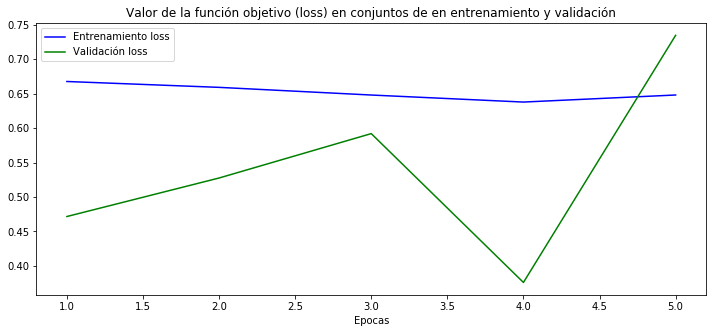

In [113]:
history_dict_w2vtwit_mx= history_w2vtwit_mx.history
dictkeys_w2vtwit_mx=list(history_dict_w2vtwit_mx.keys())
loss_values_w2vtwit_mx = history_w2vtwit_mx.history['loss']
val_loss_values_w2vtwit_mx= history_w2vtwit_mx.history['val_loss']
epochs_w2vtwit_mx = range(1, len(loss_values_w2vtwit_mx) + 1)

plt.figure(figsize=(12,5))
plt.plot(epochs_w2vtwit_mx, loss_values_w2vtwit_mx, 'b', label='Entrenamiento loss')
plt.plot(epochs_w2vtwit_mx, val_loss_values_w2vtwit_mx, 'g', label='Validación loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

* Selección del número de epocas

In [114]:
batch_size = 100
epochs = 3 # epocas seleccionadas

list_nn_w2vtwit_mx = np.arange( 1, 800, 50) # parámetro de regularización
score_train_w2vtwit_mx = np.zeros(len(list_nn_w2vtwit_mx)) # almacena acurr_w2vgoogle_mx entrenamiento
score_test_w2vtwit_mx = np.zeros(len(list_nn_w2vtwit_mx)) # almacena acurracy prueba
count = 0
for i in list_nn_w2vtwit_mx:
    # Build the model
    nn_w2vtwit_mx = Sequential()
    nn_w2vtwit_mx.add(Dense(i, activation='relu'))
    nn_w2vtwit_mx.add(Dropout(0.25))
    nn_w2vtwit_mx.add(Dense(sz_mx, activation='softmax'))
    nn_w2vtwit_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
# No se utilizan datos de validación    
    nn_w2vtwit_mx.fit(mean_emb_train_w2vtwit_mx, 
              y_train_w2vtwit_mx,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)
  
    temp1_w2vtwit_mx = nn_w2vtwit_mx.evaluate(mean_emb_train_w2vtwit_mx, y_train_w2vtwit_mx, verbose=0)
    score_train_w2vtwit_mx[count] = temp1_w2vtwit_mx[1]
    temp2_w2vtwit_mx = nn_w2vtwit_mx.evaluate(mean_emb_test_w2vtwit_mx, y_test_w2vtwit_mx, verbose=0)
    score_test_w2vtwit_mx[count]= temp2_w2vtwit_mx[1]
    count = count + 1 

Gráfica accuracy datos de entrenamienro y de prueba respecto al número de epocas

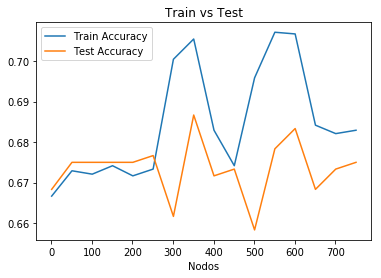

In [116]:
matriz_w2vtwit_mx = np.matrix(np.c_[list_nn_w2vtwit_mx, score_train_w2vtwit_mx, score_test_w2vtwit_mx])
models_w2vtwit_mx = pd.DataFrame(data = matriz_w2vtwit_mx, columns = 
             ['Nodos', 'Train Accuracy', 'Test Accuracy'])
plt.plot(models_w2vtwit_mx['Nodos'],models_w2vtwit_mx['Train Accuracy'])
plt.plot(models_w2vtwit_mx['Nodos'],models_w2vtwit_mx['Test Accuracy'])
plt.title('Train vs Test')
plt.xlabel('Nodos')
plt.legend()
plt.show()

In [117]:
models_w2vtwit_mx

,Nodos,Train Accuracy,Test Accuracy
0,1.0,0.666667,0.668333
1,51.0,0.672917,0.675000
2,101.0,0.672083,0.675000
3,151.0,0.674167,0.675000
4,201.0,0.671667,0.675000
5,251.0,0.673333,0.676667
6,301.0,0.700417,0.661667
7,351.0,0.705417,0.686667
8,401.0,0.682917,0.671667
9,451.0,0.674167,0.673333


In [241]:
#nodo_w2vgoogle_mx = list_nn_w2vgoogle_mx[np.argmax(np.array(models_w2vgoogle_mx['Test Accuracy']))]
nodo_w2vtwit_mx=351 # Número de nodos seleccionados

* Diseño final

In [247]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 6

nn_w2vtwit_mx = Sequential()
nn_w2vtwit_mx.add(Dense(nodo_w2vtwit_mx, activation='relu'))
nn_w2vtwit_mx.add(Dropout(0.25))
nn_w2vtwit_mx.add(Dense(sz_mx, activation='softmax'))
nn_w2vtwit_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vtwit_mx = nn_w2vtwit_mx.fit(mean_emb_train_w2vtwit_mx, 
              y_train_w2vtwit_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 1920 samples, validate on 480 samples
Epoch 1/6
 - 2s - loss: 0.6681 - acc: 0.5984 - val_loss: 0.4649 - val_acc: 0.8854
Epoch 2/6
 - 0s - loss: 0.6586 - acc: 0.6182 - val_loss: 0.5298 - val_acc: 0.8854
Epoch 3/6
 - 0s - loss: 0.6503 - acc: 0.6312 - val_loss: 0.6091 - val_acc: 0.8729
Epoch 4/6
 - 0s - loss: 0.6388 - acc: 0.6396 - val_loss: 0.3952 - val_acc: 0.8854
Epoch 5/6
 - 0s - loss: 0.6429 - acc: 0.6375 - val_loss: 0.7079 - val_acc: 0.4500
Epoch 6/6
 - 0s - loss: 0.6318 - acc: 0.6526 - val_loss: 0.6592 - val_acc: 0.6250
Tiempo de procesamiento (secs):  3.2391672134399414


* Guardar modelos

In [277]:
from keras.models import load_model
#nn_w2vtwit_mx.save('nn_mexico_w2vtwit')  # Guardar modelos
nn_w2vtwit_mx = load_model('nn_mexico_w2vtwit') # Cargar modelos

In [278]:
results_w2vtwit_mx = nn_w2vtwit_mx.evaluate(mean_emb_test_w2vtwit_mx, y_test_w2vtwit_mx)
print('Test loss:', results_w2vtwit_mx[0])
print('Test accuracy:', results_w2vtwit_mx[1])


600/600 [==============================] - 1s 2ms/step
Test loss: 0.6610420449574789
Test accuracy: 0.6083333341280619


In [279]:

y_pred_w2vtwit_mx = nn_w2vtwit_mx.predict(mean_emb_test_w2vtwit_mx).squeeze()

import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

y_test_label_w2vtwit_mx = np.argmax(y_test_w2vtwit_mx,1) 
y_pred_label_w2vtwit_mx = np.argmax(y_pred_w2vtwit_mx,1)


# Confusion matrix
C=confusion_matrix(y_test_label_w2vtwit_mx, y_pred_label_w2vtwit_mx)
print(C)

[[285 116]
 [119  80]]


### Resultados

In [280]:
print('Accuracy score:', results_w2vtwit_mx[1])  # nn evaluate keras
print("F1 score", f1_score( y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx, average='macro'))
print("F1 weighted", f1_score( y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,   average='weighted'))
print("Recall score", recall_score( y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,   average='macro'))
print("Precision score", precision_score( y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,  average='macro'))


Accuracy score: 0.6083333341280619
F1 score 0.5565689126503657
F1 weighted 0.6075758052257777
Recall score 0.5563666211356032
Precision score 0.5568044049302889


In [112]:
from sklearn.metrics import classification_report
print(classification_report(y_test_label_w2vtwit_mx, y_pred_label_w2vtwit_mx, target_names=['no-ironia','ironia']))


              precision    recall  f1-score   support

   no-ironia       0.71      0.71      0.71       401
      ironia       0.41      0.40      0.41       199

   micro avg       0.61      0.61      0.61       600
   macro avg       0.56      0.56      0.56       600
weighted avg       0.61      0.61      0.61       600



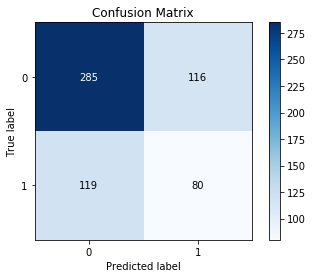

In [254]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_label_w2vtwit_mx, y_pred_label_w2vtwit_mx)

# Clasificador SVM

* Selección de modelos

In [265]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=3000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.1,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(mean_emb_train_w2vtwit_mx, y_train.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_w2vtwit_mx = linearSVC.best_estimator_
svc_w2vtwit_mx.fit(mean_emb_train_w2vtwit_mx, y_train.values)
svc_w2vtwit_mx.coef_ = svc_w2vgoogle_mx.named_steps['SVC'].coef_
svc_w2vtwit_mx.score(mean_emb_train_w2vtwit_mx, y_train.values)

{'SVC__C': 1.7000000000000002}


0.7283333333333334

* Guardar modelo

In [281]:
from joblib import dump, load
#dump(svc_w2vtwit_mx, 'svc__w2vtwit_mx_mx.joblib')  # Guardar modelo
svc_w2vtwit_mx = load('svc__w2vtwit_mx_mx.joblib') # Cargar modelo
prediction_w2vtwit_mx=svc_w2vtwit_mx.predict(mean_emb_test_w2vtwit_mx)
print("Acurracy Test",metrics.accuracy_score(prediction_w2vtwit_mx, y_test.values))

Acurracy Test 0.6533333333333333


In [282]:
print("Confusion Metrix:\n",metrics.confusion_matrix(y_test.values, prediction_w2vtwit_mx))

Confusion Metrix:
 [[277 124]
 [ 84 115]]


### Resultados

In [283]:
print('Accuracy score:', metrics.accuracy_score( y_test.values, prediction_w2vtwit_mx))  # nn evaluate keras
print("F1 score", f1_score(y_test.values, prediction_w2vtwit_mx,  average='macro'))
print("F1 weighted", f1_score(y_test.values, prediction_w2vtwit_mx, average='weighted'))
print("Recall score", recall_score(y_test.values, prediction_w2vtwit_mx,  average='macro'))
print("Precision score", precision_score(y_test.values, prediction_w2vtwit_mx, average='macro'))

Accuracy score: 0.6533333333333333
F1 score 0.6260741379930248
F1 weighted 0.6600639988494589
Recall score 0.6343312572839259
Precision score 0.6242422837538683


In [269]:
from sklearn.metrics import classification_report
print(classification_report(y_test.values, prediction_w2vtwit_mx,  target_names=['no-ironia','ironia']))

              precision    recall  f1-score   support

   no-ironia       0.77      0.69      0.73       401
      ironia       0.48      0.58      0.53       199

   micro avg       0.65      0.65      0.65       600
   macro avg       0.62      0.63      0.63       600
weighted avg       0.67      0.65      0.66       600



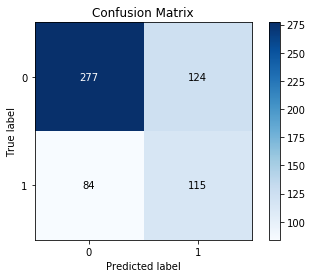

In [158]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test.values, prediction_w2vtwit_mx)

## word2vec twitter España

In [159]:
x_train_españa.head()
print(x_train_españa.shape)

(2400,)


In [160]:
x_test_españa.head()
print(x_test_españa.shape)

(600,)


* Limpiar corpus de entrenamiento y de prueba

In [284]:
#Limpiando datos de entrenamiento
num= x_train_españa.size

clean_train_es = []


for i in range( 0, num):

    clean_train_es.append( review_to_words2(x_train_españa.values[i] ) )

x_train_w2vtwit_es = clean_train_es

In [285]:
#Limpiando datos de prueba
num= x_test_españa.size
# Lista para guardar twits limpios
clean_test_es = []


for i in range( 0, num):

    clean_test_es.append( review_to_words2(x_test_españa.values[i] ) )

x_test_w2vtwit_es = clean_test_es

In [286]:
x_train_w2vtwit_es = train_es["TOPIC"].astype(str).str.cat(x_train_w2vtwit_es, sep=' ')
x_test_w2vtwit_es = test_es["TOPIC_y"].astype(str).str.cat(x_test_w2vtwit_es, sep=' ')

In [164]:
x_train_w2vtwit_es[0]

'TARDÀ armandoruido007 anti_merma50 joantarda vez joan tarda van llamarle tarda callarle boca'

In [165]:
x_test_w2vtwit_es[0]

'FRANCO suspenden exhumación francisco franco caso da giro inesperado https t co laosjulo5v https t co knnbtfuonr'

* Modelo W2V Twitter Avg

In [287]:
mean_embedding_vectorizer_twitter_es = MeanEmbeddingVectorizer(modelo_twitter)
mean_emb_train_w2vtwit_es = mean_embedding_vectorizer_twitter_es.fit_transform(x_train_w2vtwit_es)

mean_emb_test_w2vtwit_es = mean_embedding_vectorizer_twitter_es.fit_transform(x_test_w2vtwit_es)

print(mean_emb_train_w2vtwit_es.shape)
print(mean_emb_test_w2vtwit_es.shape)

(2400, 400)
(600, 400)


### Clasificador NN

In [288]:
from keras.utils import to_categorical

y_train_w2vtwit_es = to_categorical(y_train_es)
y_test_w2vtwit_es  = to_categorical(y_test_es)

num_es, sz_es = y_train_w2vtwit_es.shape

print(num_es)
print(sz_es)


2400
2


* Selecicón de modelo

In [201]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 5

nn_w2vtwit_es = Sequential()
nn_w2vtwit_es.add(Dense(512, activation='relu'))
nn_w2vtwit_es.add(Dropout(0.25))
nn_w2vtwit_es.add(Dense(sz_es, activation='softmax'))
nn_w2vtwit_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vtwit_es = nn_w2vtwit_es.fit(mean_emb_train_w2vtwit_es, 
              y_train_w2vtwit_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 1920 samples, validate on 480 samples
Epoch 1/5
 - 3s - loss: 0.6021 - acc: 0.6776 - val_loss: 0.6725 - val_acc: 0.6188
Epoch 2/5
 - 0s - loss: 0.5617 - acc: 0.7219 - val_loss: 0.6780 - val_acc: 0.5625
Epoch 3/5
 - 0s - loss: 0.5387 - acc: 0.7474 - val_loss: 0.7285 - val_acc: 0.5250
Epoch 4/5
 - 0s - loss: 0.5264 - acc: 0.7464 - val_loss: 0.7045 - val_acc: 0.6354
Epoch 5/5
 - 0s - loss: 0.5267 - acc: 0.7375 - val_loss: 0.7531 - val_acc: 0.6417
Tiempo de procesamiento (secs):  3.270796060562134


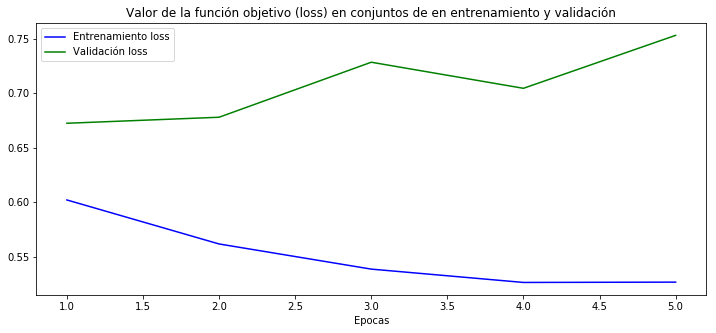

In [144]:
history_dict_w2vtwit_es = history_w2vtwit_es.history
dictkeys_w2vtwit_es=list(history_dict_w2vtwit_es.keys())
loss_values_w2vtwit_es = history_w2vtwit_es.history['loss']
val_loss_values_w2vtwit_es = history_w2vtwit_es.history['val_loss']
epochs_w2vtwit_es = range(1, len(loss_values_w2vtwit_es) + 1)

plt.figure(figsize=(12,5))
plt.plot(epochs_w2vtwit_es, loss_values_w2vtwit_es, 'b', label='Entrenamiento loss')
plt.plot(epochs_w2vtwit_es, val_loss_values_w2vtwit_es, 'g', label='Validación loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

* Selección del número de nodos

In [145]:
batch_size = 100
epochs = 3 # epocas seleccionadas

list_nn_w2vtwit_es= np.arange( 1, 800, 50) # parámetro de regularización
score_train_w2vtwit_es = np.zeros(len(list_nn_w2vtwit_es)) # almacena acurr_w2vtwit_mx entrenamiento
score_test_w2vtwit_es = np.zeros(len(list_nn_w2vtwit_es)) # almacena acurracy prueba
count = 0
for i in list_nn_w2vtwit_es:
    # Build the model
    nn_w2vtwit_es = Sequential()
    nn_w2vtwit_es.add(Dense(i, activation='relu'))
    nn_w2vtwit_es.add(Dropout(0.25))
    nn_w2vtwit_es.add(Dense(sz_es, activation='softmax'))
    nn_w2vtwit_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
# No se utilizan datos de validación    
    nn_w2vtwit_es.fit(mean_emb_train_w2vtwit_es, 
              y_train_w2vtwit_es,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)
  
    temp1_w2vtwit_es = nn_w2vtwit_es.evaluate(mean_emb_train_w2vtwit_es, y_train_w2vtwit_es, verbose=0)
    score_train_w2vtwit_es[count] = temp1_w2vtwit_es[1]
    temp2_w2vtwit_es = nn_w2vtwit_es.evaluate(mean_emb_test_w2vtwit_es, y_test_w2vtwit_es, verbose=0)
    score_test_w2vtwit_es[count]= temp2_w2vtwit_es[1]
    count = count + 1 

Gráfica accuracy datos de entrenamietno y de prueba respecto al número de nodos

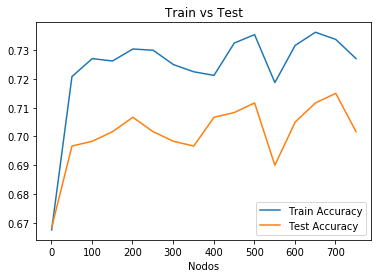

In [146]:
matriz_w2vtwit_es = np.matrix(np.c_[list_nn_w2vtwit_es, score_train_w2vtwit_es, score_test_w2vtwit_es])
models_w2vtwit_es = pd.DataFrame(data = matriz_w2vtwit_es, columns = 
             ['Nodos', 'Train Accuracy', 'Test Accuracy'])
plt.plot(models_w2vtwit_es['Nodos'],models_w2vtwit_es['Train Accuracy'])
plt.plot(models_w2vtwit_es['Nodos'],models_w2vtwit_es['Test Accuracy'])
plt.title('Train vs Test')
plt.xlabel('Nodos')
plt.legend()
plt.show()

In [147]:
models_w2vtwit_es

,Nodos,Train Accuracy,Test Accuracy
0,1.0,0.667500,0.668333
1,51.0,0.720833,0.696667
2,101.0,0.727083,0.698333
3,151.0,0.726250,0.701667
4,201.0,0.730417,0.706667
5,251.0,0.730000,0.701667
6,301.0,0.725000,0.698333
7,351.0,0.722500,0.696667
8,401.0,0.721250,0.706667
9,451.0,0.732500,0.708333


In [170]:
#nodo_w2vtwit_mx = list_nn_w2vtwit_mx[np.argmax(np.array(models_w2vtwit_mx['Test Accuracy']))]
nodo_w2vtwit_es=151 # Selección del número de nodos

* Diseño final

In [171]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 3

nn_w2vtwit_es = Sequential()
nn_w2vtwit_es.add(Dense(nodo_w2vtwit_es, activation='relu'))
nn_w2vtwit_es.add(Dropout(0.25))
nn_w2vtwit_es.add(Dense(sz_es, activation='softmax'))
nn_w2vtwit_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vtwit_es = nn_w2vtwit_es.fit(mean_emb_train_w2vtwit_es, 
              y_train_w2vtwit_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 1920 samples, validate on 480 samples
Epoch 1/3
 - 3s - loss: 0.6219 - acc: 0.6521 - val_loss: 0.6532 - val_acc: 0.6521
Epoch 2/3
 - 0s - loss: 0.5686 - acc: 0.7172 - val_loss: 0.6756 - val_acc: 0.5771
Epoch 3/3
 - 0s - loss: 0.5492 - acc: 0.7328 - val_loss: 0.6879 - val_acc: 0.5479
Tiempo de procesamiento (secs):  3.3132855892181396


* Guardar modelo

In [289]:
from keras.models import load_model
#nn_w2vtwit_es.save('nn_españa_w2vtwit')  # Guardar modelo
nn_w2vtwit_es = load_model('nn_españa_w2vtwit') # Cargar modelo

In [290]:
results_w2vtwit_es = nn_w2vtwit_es.evaluate(mean_emb_test_w2vtwit_es, y_test_w2vtwit_es)
print('Test loss:', results_w2vtwit_es[0])
print('Test accuracy:', results_w2vtwit_es[1])

y_pred_w2vtwit_es = nn_w2vtwit_es.predict(mean_emb_test_w2vtwit_es).squeeze()


600/600 [==============================] - 1s 2ms/step
Test loss: 0.5863975771268208
Test accuracy: 0.6733333333333333


In [291]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

y_test_label_w2vtwit_es = np.argmax(y_test_w2vtwit_es,1) 
y_pred_label_w2vtwit_es = np.argmax(y_pred_w2vtwit_es,1)

# Confusion matrix
C=confusion_matrix(y_test_label_w2vtwit_es , y_pred_label_w2vtwit_es)
print(C)

[[311  89]
 [107  93]]


### Resultados

In [292]:
print('Accuracy score:', results_w2vtwit_es[1])  # nn evaluate keras
print("F1 score", f1_score(y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,  average='macro'))
print("F1 weighted", f1_score(y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,  average='weighted'))
print("Recall score", recall_score(y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,   average='macro'))
print("Precision score", precision_score(y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,   average='macro'))

Accuracy score: 0.6733333333333333
F1 score 0.6236510964042039
F1 weighted 0.6692311302841393
Recall score 0.62125
Precision score 0.6275040748724959


In [174]:
from sklearn.metrics import classification_report
print(classification_report(y_test_label_w2vtwit_es, y_pred_label_w2vtwit_es,target_names=['no-ironia','ironia']))


              precision    recall  f1-score   support

   no-ironia       0.74      0.78      0.76       400
      ironia       0.51      0.47      0.49       200

   micro avg       0.67      0.67      0.67       600
   macro avg       0.63      0.62      0.62       600
weighted avg       0.67      0.67      0.67       600



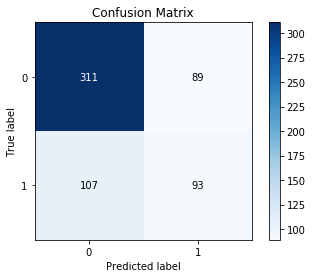

In [288]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_label_w2vtwit_es, y_pred_label_w2vtwit_es)

### Clasificador SVM

In [289]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=3000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.1,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(mean_emb_train_w2vtwit_es, y_train_es.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_w2vtwit_es = linearSVC.best_estimator_
svc_w2vtwit_es.fit(mean_emb_train_w2vtwit_es, y_train_es.values)
svc_w2vtwit_es.coef_ = svc_w2vtwit_es.named_steps['SVC'].coef_
svc_w2vtwit_es.score(mean_emb_train_w2vtwit_es, y_train_es.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)


{'SVC__C': 0.1}
Tiempo de procesamiento (secs):  15.205628156661987


In [124]:
from joblib import dump, load
#dump(svc_w2vtwit_es, 'svc_w2vtwit_es.joblib') 
svc_w2vtwit_es = load('svc_w2vtwit_es.joblib') 
prediction_w2vtwit_es=svc_w2vtwit_es.predict(mean_emb_test_w2vtwit_es)
print("Acurracy Test",metrics.accuracy_score(prediction_w2vtwit_es, y_test_es.values))

Acurracy Test 0.6616666666666666


In [293]:
print("Confusion Metrix:\n",metrics.confusion_matrix(y_test_es.values, prediction_w2vtwit_es))

Confusion Metrix:
 [[247 153]
 [ 50 150]]


### Resultados

In [294]:
print('Accuracy score:', metrics.accuracy_score(y_test_es.values, prediction_w2vtwit_es))  # nn evaluate keras
print("F1 score", f1_score(y_test_es.values, prediction_w2vtwit_es,  average='macro'))
print("F1 weighted", f1_score(y_test_es.values, prediction_w2vtwit_es,  average='weighted'))
print("Recall score", recall_score(y_test_es.values, prediction_w2vtwit_es,  average='macro'))
print("Precision score", precision_score(y_test_es.values, prediction_w2vtwit_es,  average='macro'))

Accuracy score: 0.6616666666666666
F1 score 0.6525866322866245
F1 weighted 0.6713083526578454
Recall score 0.6837500000000001
Precision score 0.6633496683001634


In [178]:
from sklearn.metrics import classification_report
print(classification_report( y_test_es.values, prediction_w2vtwit_es, target_names=['no-ironia','ironia']))


              precision    recall  f1-score   support

   no-ironia       0.83      0.62      0.71       400
      ironia       0.50      0.75      0.60       200

   micro avg       0.66      0.66      0.66       600
   macro avg       0.66      0.68      0.65       600
weighted avg       0.72      0.66      0.67       600



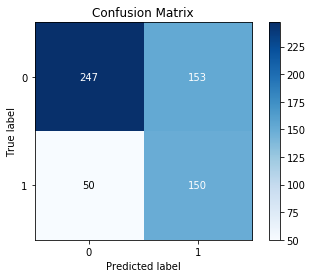

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_es.values, prediction_w2vtwit_es)

## word2vec twitter Cuba

In [184]:
x_train_cuba.head()
print(x_train_cuba.shape)

(2400,)


In [185]:
x_test_cuba.head()
print(x_test_cuba.shape)

(600,)


* Limpieza del corpus de entrenamiento y de prueba

In [295]:
#Limpiando datos de entrenamiento
num= x_train_cuba.size

clean_train_cu = []

for i in range( 0, num):

    clean_train_cu.append( review_to_words2(x_train_cuba.values[i] ) )
x_train_w2vtwit_cu = clean_train_cu

In [296]:
#Limpiando datos de prueba
num= x_test_cuba.size

clean_test_cu = []

for i in range( 0, num):
    clean_test_cu.append( review_to_words2(x_test_cuba.values[i] ) )
    
x_test_w2vtwit_cu = clean_test_cu

In [297]:
x_train_w2vtwit_cu = train_cu["TOPIC"].astype(str).str.cat(x_train_w2vtwit_cu, sep=' ')
x_test_w2vtwit_cu = test_cu["TOPIC_y"].astype(str).str.cat(x_test_w2vtwit_cu, sep=' ')

In [189]:
x_train_w2vtwit_cu[0]

'TELEVISIÓN DIGITAL, CAJAS DECODIFICADORAS, TELEVISIÓN CUBANA, AUDIOVISUALES magnifico'

In [190]:
x_test_w2vtwit_cu[0]

'ECONOMÍA. TURISMOS, HOTELES oferta persona noche habitación doble hoy febrero precio normal así oferta buena'

* W2V Twitter Avg

In [298]:
mean_embedding_vectorizer_twitter_cu = MeanEmbeddingVectorizer(modelo_twitter)
mean_emb_train_w2vtwit_cu = mean_embedding_vectorizer_twitter_cu.fit_transform(x_train_w2vtwit_cu)
mean_emb_test_w2vtwit_cu = mean_embedding_vectorizer_twitter_cu.fit_transform(x_test_w2vtwit_cu)
print(mean_emb_train_w2vtwit_cu.shape)
print(mean_emb_test_w2vtwit_cu.shape)

(2400, 400)
(600, 400)


### Clasificador NN

In [299]:
from keras.utils import to_categorical

y_train_w2vtwit_cu = to_categorical(y_train_cu)
y_test_w2vtwit_cu  = to_categorical(y_test_cu)

num_cu, sz_cu = y_train_w2vtwit_cu.shape

print(num_cu)
print(sz_cu)

2400
2


* Selección del múmero de epocas

In [306]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 5

nn_w2vtwit_cu = Sequential()
nn_w2vtwit_cu.add(Dense(512, activation='relu'))
nn_w2vtwit_cu.add(Dropout(0.25))
nn_w2vtwit_cu.add(Dense(sz_cu, activation='softmax'))
nn_w2vtwit_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vtwit_cu = nn_w2vtwit_cu.fit(mean_emb_train_w2vtwit_cu, 
              y_train_w2vtwit_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 1920 samples, validate on 480 samples
Epoch 1/5
 - 5s - loss: 0.6534 - acc: 0.6432 - val_loss: 0.5701 - val_acc: 0.7583
Epoch 2/5
 - 0s - loss: 0.6409 - acc: 0.6490 - val_loss: 0.5973 - val_acc: 0.7542
Epoch 3/5
 - 0s - loss: 0.6323 - acc: 0.6510 - val_loss: 0.5659 - val_acc: 0.7583
Epoch 4/5
 - 0s - loss: 0.6258 - acc: 0.6578 - val_loss: 0.6204 - val_acc: 0.6979
Epoch 5/5
 - 0s - loss: 0.6147 - acc: 0.6646 - val_loss: 0.7955 - val_acc: 0.3667
Tiempo de procesamiento (secs):  6.610992193222046


 Gráfica loss values datos de entrenamiento y validación respecto al número de epocas

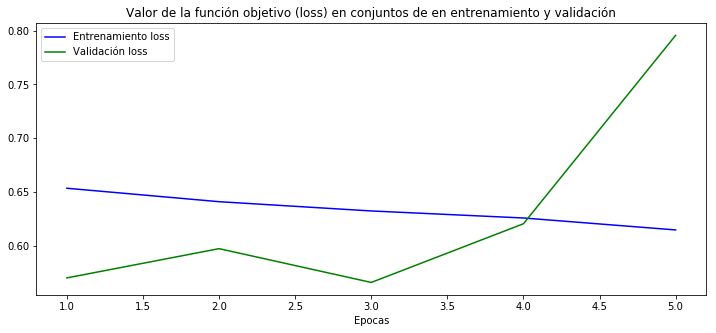

In [307]:
history_dict_w2vtwit_cu = history_w2vtwit_cu.history
dictkeys_w2vtwit_cu=list(history_dict_w2vtwit_cu.keys())
loss_values_w2vtwit_cu = history_w2vtwit_cu.history['loss']
val_loss_values_w2vtwit_cu = history_w2vtwit_cu.history['val_loss']
epochs_w2vtwit_cu = range(1, len(loss_values_w2vtwit_cu) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs_w2vtwit_cu, loss_values_w2vtwit_cu, 'b', label='Entrenamiento loss')
plt.plot(epochs_w2vtwit_cu, val_loss_values_w2vtwit_cu, 'g', label='Validación loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

* Selección del número de nodos

In [308]:
batch_size = 100
epochs = 3 # epocas seleccionadas

list_nn_w2vtwit_cu= np.arange( 1, 800, 50) # parámetro de regularización
score_train_w2vtwit_cu = np.zeros(len(list_nn_w2vtwit_cu)) # almacena acurr_w2vtwit_mx entrenamiento
score_test_w2vtwit_cu = np.zeros(len(list_nn_w2vtwit_cu)) # almacena acurracy prueba
count = 0
for i in list_nn_w2vtwit_cu:
    # Build the model
    nn_w2vtwit_cu = Sequential()
    nn_w2vtwit_cu.add(Dense(i, activation='relu'))
    nn_w2vtwit_cu.add(Dropout(0.25))
    nn_w2vtwit_cu.add(Dense(sz_cu, activation='softmax'))
    nn_w2vtwit_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
# No se utilizan datos de validación    
    nn_w2vtwit_cu.fit(mean_emb_train_w2vtwit_cu, 
              y_train_w2vtwit_cu,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)
  
    temp1_w2vtwit_cu = nn_w2vtwit_cu.evaluate(mean_emb_train_w2vtwit_cu, y_train_w2vtwit_cu, verbose=0)
    score_train_w2vtwit_cu[count] = temp1_w2vtwit_cu[1]
    temp2_w2vtwit_cu = nn_w2vtwit_cu.evaluate(mean_emb_test_w2vtwit_cu, y_test_w2vtwit_cu, verbose=0)
    score_test_w2vtwit_cu[count]= temp2_w2vtwit_cu[1]
    count = count + 1 

Gráfica accuracy datos de entrenamiento y de prueba respecto al número de nodos

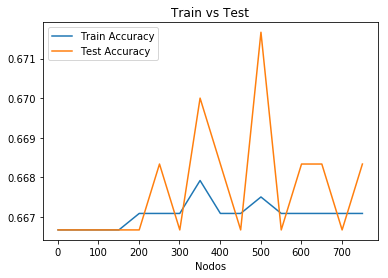

In [309]:
matriz_w2vtwit_cu = np.matrix(np.c_[list_nn_w2vtwit_cu, score_train_w2vtwit_cu, score_test_w2vtwit_cu])
models_w2vtwit_cu = pd.DataFrame(data = matriz_w2vtwit_cu, columns = 
             ['Nodos', 'Train Accuracy', 'Test Accuracy'])
plt.plot(models_w2vtwit_cu['Nodos'],models_w2vtwit_cu['Train Accuracy'])
plt.plot(models_w2vtwit_cu['Nodos'],models_w2vtwit_cu['Test Accuracy'])
plt.title('Train vs Test')
plt.xlabel('Nodos')
plt.legend()
plt.show()

In [310]:
models_w2vtwit_cu

,Nodos,Train Accuracy,Test Accuracy
0,1.0,0.666667,0.666667
1,51.0,0.666667,0.666667
2,101.0,0.666667,0.666667
3,151.0,0.666667,0.666667
4,201.0,0.667083,0.666667
5,251.0,0.667083,0.668333
6,301.0,0.667083,0.666667
7,351.0,0.667917,0.670000
8,401.0,0.667083,0.668333
9,451.0,0.667083,0.666667


In [289]:
#nodo_w2vtwit_mx = list_nn_w2vtwit_mx[np.argmax(np.array(models_w2vtwit_mx['Test Accuracy']))]
nodo_w2vtwit_cu=512 # selección del número de nodo

* Diseño Final

In [294]:
import time
tic=time.time()

np.random.seed(1)

batch_size = 100
epochs = 5

nn_w2vtwit_cu = Sequential()
nn_w2vtwit_cu.add(Dense(nodo_w2vtwit_cu, activation='relu'))
nn_w2vtwit_cu.add(Dropout(0.25))
nn_w2vtwit_cu.add(Dense(sz_cu, activation='softmax'))
nn_w2vtwit_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_w2vtwit_cu = nn_w2vtwit_cu.fit(mean_emb_train_w2vtwit_cu, 
              y_train_w2vtwit_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 1920 samples, validate on 480 samples
Epoch 1/5
 - 2s - loss: 0.6534 - acc: 0.6432 - val_loss: 0.5701 - val_acc: 0.7583
Epoch 2/5
 - 0s - loss: 0.6409 - acc: 0.6490 - val_loss: 0.5973 - val_acc: 0.7542
Epoch 3/5
 - 0s - loss: 0.6323 - acc: 0.6510 - val_loss: 0.5659 - val_acc: 0.7583
Epoch 4/5
 - 0s - loss: 0.6258 - acc: 0.6578 - val_loss: 0.6204 - val_acc: 0.6979
Epoch 5/5
 - 0s - loss: 0.6147 - acc: 0.6646 - val_loss: 0.7955 - val_acc: 0.3667
Tiempo de procesamiento (secs):  4.292276382446289


* Guardar modelo

In [300]:
from keras.models import load_model
#nn_w2vtwit_cu.save('nn_cuba_w2vtwit')  # Guardar modelo
nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


In [301]:
from keras.models import load_model
#nn_w2vtwit_cu.save('nn_cuba_w2vtwit')  # Guardar modelo
nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo

600/600 [==============================] - 1s 2ms/step
Test loss: 0.6970452682177226
Test accuracy: 0.531666667064031


In [302]:
y_pred_w2vtwit_cu = nn_w2vtwit_cu.predict(mean_emb_test_w2vtwit_cu).squeeze()

import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

y_test_label_w2vtwit_cu = np.argmax(y_test_w2vtwit_cu,1) 
y_pred_label_w2vtwit_cu = np.argmax(y_pred_w2vtwit_cu,1)

# Confusion matrix
C=confusion_matrix(y_test_label_w2vtwit_cu , y_pred_label_w2vtwit_cu)
print(C)

[[185 215]
 [ 66 134]]


### Resultados

In [135]:
print('Accuracy score:', results_w2vtwit_cu[1])  # nn evaluate keras
print("F1 score", f1_score(y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,  average='weighted'))
print("Recall score", recall_score(y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,   average='macro'))
print("Precision score", precision_score(y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,   average='macro'))

Accuracy score: 0.531666667064031
F1 score 0.5282583331234838
F1 weighted 0.5416243470183184
Recall score 0.56625
Precision score 0.5605029737782394


In [136]:
y_test_label_w2vtwit_cu.shape

(600,)

In [198]:
from sklearn.metrics import classification_report
print(classification_report(y_test_label_w2vtwit_cu, y_pred_label_w2vtwit_cu,target_names=['no-ironia','ironia']))

              precision    recall  f1-score   support

   no-ironia       0.74      0.46      0.57       400
      ironia       0.38      0.67      0.49       200

   micro avg       0.53      0.53      0.53       600
   macro avg       0.56      0.57      0.53       600
weighted avg       0.62      0.53      0.54       600



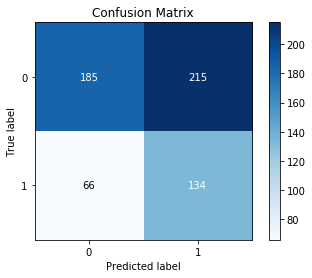

In [386]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_label_w2vtwit_cu, y_pred_label_w2vtwit_cu)

### Clasificador SVM

* Selección de modelo

In [387]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(1,10,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(mean_emb_train_w2vtwit_cu, y_train_cu.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_w2vtwit_cu = linearSVC.best_estimator_
svc_w2vtwit_cu.fit(mean_emb_train_w2vtwit_cu, y_train_cu.values)
svc_w2vtwit_cu.coef_ = svc_w2vtwit_cu.named_steps['SVC'].coef_
svc_w2vtwit_cu.score(mean_emb_train_w2vtwit_cu, y_train_cu.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)



{'SVC__C': 2.4000000000000012}
Tiempo de procesamiento (secs):  335.76003766059875


In [303]:
from joblib import dump, load
#dump(svc_w2vtwit_cu, 'svc_w2vtwit_cu.joblib') 
svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_w2vtwit_cu=svc_w2vtwit_cu.predict(mean_emb_test_w2vtwit_cu)
print("Acurracy Test",metrics.accuracy_score( y_test_cu.values, prediction_w2vtwit_cu,))

Acurracy Test 0.6366666666666667


In [304]:
print("Confusion Metrix:\n",metrics.confusion_matrix(y_test_cu.values, prediction_w2vtwit_cu))

Confusion Metrix:
 [[274 126]
 [ 92 108]]


### Resultados

In [305]:
print('Accuracy score:', metrics.accuracy_score(y_test_cu.values, prediction_w2vtwit_cu))  # nn evaluate keras
print("F1 score", f1_score(y_test_cu.values, prediction_w2vtwit_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_cu.values, prediction_w2vtwit_cu,  average='weighted'))
print("Recall score", recall_score(y_test_cu.values, prediction_w2vtwit_cu,  average='macro'))
print("Precision score", precision_score(y_test_cu.values, prediction_w2vtwit_cu,  average='macro'))

Accuracy score: 0.6366666666666667
F1 score 0.6065502761367327
F1 weighted 0.642835084004123
Recall score 0.6125
Precision score 0.6050861706599412


In [303]:
from sklearn.metrics import classification_report
print(classification_report( y_test_cu.values, prediction_w2vtwit_cu, target_names=['no-ironia','ironia']))


              precision    recall  f1-score   support

   no-ironia       0.75      0.69      0.72       400
      ironia       0.46      0.54      0.50       200

   micro avg       0.64      0.64      0.64       600
   macro avg       0.61      0.61      0.61       600
weighted avg       0.65      0.64      0.64       600



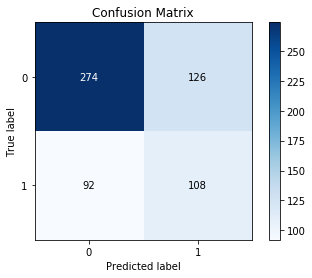

In [392]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_cu.values, prediction_w2vtwit_cu)


In [306]:
del modelo_twitter

# PARTE IV Desempeño

## Por representación

### Clasificador SVM

* Acurracy

In [213]:
# intialise data of lists.
accuracy_svm = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[metrics.accuracy_score(y_test.values,  prediction_mx, ), 
                      metrics.accuracy_score(y_test_es.values,  prediction_es, ), 
                      metrics.accuracy_score(y_test_cu.values,  prediction_cu, )],
        'W2Vec Google':[metrics.accuracy_score(y_test.values, prediction_w2vgoogle_mx ), 
                      metrics.accuracy_score(y_test_es.values, prediction_w2vgoogle_es ), 
                      metrics.accuracy_score(y_test_cu.values, prediction_w2vgoogle_cu )],
        'W2Vec Twitter':[metrics.accuracy_score(y_test.values, prediction_w2vtwit_mx ), 
                      metrics.accuracy_score(y_test_es.values, prediction_w2vtwit_es ), 
                      metrics.accuracy_score(y_test_cu.values, prediction_w2vtwit_cu )]}
 
# Create DataFrame
accuracy_svm  = pd.DataFrame(accuracy_svm )
accuracy_svm 



,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.663333,0.653333,0.653333
1,España,0.715000,0.691667,0.661667
2,Cuba,0.625000,0.626667,0.636667


* F1 Score macro

In [214]:
# intialise data of lists.
F1score_svm = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[f1_score( y_test.values,  prediction_mx,   average='macro'), 
                      f1_score( y_test_es.values,  prediction_es,   average='macro'), 
                      f1_score( y_test_cu.values,  prediction_cu,   average='macro')],
        'W2Vec Google':[f1_score( y_test.values, prediction_w2vgoogle_mx,   average='macro'), 
                      f1_score( y_test_es.values,  prediction_w2vgoogle_es,  average='macro'), 
                      f1_score( y_test_cu.values, prediction_w2vgoogle_cu,   average='macro')],
        'W2Vec Twitter':[f1_score( y_test.values, prediction_w2vtwit_mx,   average='macro'), 
                      f1_score( y_test_es.values,  prediction_w2vtwit_es,  average='macro'), 
                      f1_score( y_test_cu.values, prediction_w2vtwit_cu,   average='macro')]}
 
# Create DataFrame
F1score_svm = pd.DataFrame(F1score_svm)
F1score_svm

,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.642756,0.625342,0.626074
1,España,0.685059,0.660042,0.652587
2,Cuba,0.601053,0.606447,0.606550


In [204]:
F1score_svm['BoW TF-IDF'].values.mean()

0.6429560031401762

In [205]:
F1score_svm['W2Vec Google'].values.mean()

0.6306103644490654

In [207]:
F1score_svm['W2Vec Twitter'].values.mean()

0.628403682138794

* F1 Score weighted

In [208]:
# intialise data of lists.
F1w_svm = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[f1_score( y_test.values,  prediction_mx,   average='weighted'), 
                      f1_score( y_test_es.values,  prediction_es,   average='weighted'), 
                      f1_score( y_test_cu.values,  prediction_cu,   average='weighted')],
        'W2Vec Google':[f1_score( y_test.values, prediction_w2vgoogle_mx,   average='weighted'), 
                      f1_score( y_test_es.values,  prediction_w2vgoogle_es,  average='weighted'), 
                      f1_score( y_test_cu.values, prediction_w2vgoogle_cu,   average='weighted')],
        'W2Vec Twitter':[f1_score( y_test.values, prediction_w2vtwit_mx,   average='weighted'), 
                      f1_score( y_test_es.values,  prediction_w2vtwit_es,  average='weighted'), 
                      f1_score( y_test_cu.values, prediction_w2vtwit_cu,   average='weighted')]}
 
# Create DataFrame
F1w_svm = pd.DataFrame(F1w_svm)
F1w_svm

,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.671621,0.659819,0.660064
1,España,0.717428,0.694604,0.671308
2,Cuba,0.633634,0.636182,0.642835


* Recall score

In [310]:
# intialise data of lists.
recall_svm = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[recall_score( y_test.values,  prediction_mx,   average='macro'), 
                      recall_score( y_test_es.values,  prediction_es,   average='macro'), 
                      recall_score( y_test_cu.values,  prediction_cu,   average='macro')],
        'W2Vec Google':[recall_score( y_test.values, prediction_w2vgoogle_mx,   average='macro'), 
                      recall_score( y_test_es.values,  prediction_w2vgoogle_es,  average='macro'), 
                      recall_score( y_test_cu.values, prediction_w2vgoogle_cu,   average='macro')],
        'W2Vec Twitter':[recall_score( y_test.values, prediction_w2vtwit_mx,   average='macro'), 
                      recall_score( y_test_es.values,  prediction_w2vtwit_es,  average='macro'), 
                      recall_score( y_test_cu.values, prediction_w2vtwit_cu,   average='macro')]}
 
# Create DataFrame
recall_svm = pd.DataFrame(recall_svm)
recall_svm

,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.657001,0.633066,0.634331
1,España,0.688750,0.663750,0.683750
2,Cuba,0.611250,0.620000,0.612500


* Precision score

In [209]:
# intialise data of lists.
precision_svm = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[precision_score( y_test.values,  prediction_mx,   average='macro'), 
                      precision_score( y_test_es.values,  prediction_es,   average='macro'), 
                      precision_score( y_test_cu.values,  prediction_cu,   average='macro')],
        'W2Vec Google':[precision_score( y_test.values, prediction_w2vgoogle_mx,   average='macro'), 
                      precision_score( y_test_es.values,  prediction_w2vgoogle_es,  average='macro'), 
                      precision_score( y_test_cu.values, prediction_w2vgoogle_cu,   average='macro')],
        'W2Vec Twitter':[precision_score( y_test.values, prediction_w2vtwit_mx,   average='macro'), 
                      precision_score( y_test_es.values,  prediction_w2vtwit_es,  average='macro'), 
                      precision_score( y_test_cu.values, prediction_w2vtwit_cu,   average='macro')]}
# Create DataFrame
precision_svm = pd.DataFrame(precision_svm)
precision_svm

,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.642125,0.623426,0.624242
1,España,0.682422,0.657621,0.663350
2,Cuba,0.601377,0.608225,0.605086


### Clasificador NN

* Accuracy

In [312]:
# intialise data of lists.
accuracy_nn= {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[results_mx[1], 
                      results_es[1], 
                      results_cu[1]],
        'W2Vec Google':[results_w2vgoogle_mx[1], 
                      results_w2vgoogle_es[1], 
                      results_w2vgoogle_cu[1]],
        'W2Vec Twitter':[results_w2vtwit_mx[1], 
                      results_w2vtwit_es[1], 
                      results_w2vtwit_cu[1]]}
 
# Create DataFrame
accuracy_nn = pd.DataFrame(accuracy_nn)
accuracy_nn



,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.693333,0.676667,0.608333
1,España,0.725000,0.698333,0.673333
2,Cuba,0.611667,0.575000,0.531667


* F1 score

In [313]:
F1score_nn= {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[f1_score(y_test_label_mx,  y_pred_label_mx,  average='macro'), 
                     f1_score(y_test_label_es,  y_pred_label_es,  average='macro'), 
                      f1_score(y_test_label_cu,  y_pred_label_cu,  average='macro')],
        'W2Vec Google':[f1_score(y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,  average='macro'), 
                     f1_score(y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,  average='macro'), 
                      f1_score(y_test_label_w2vgoogle_cu,  y_pred_label_w2vgoogle_cu,  average='macro')] ,
        'W2Vec Twitter':[f1_score(y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,  average='macro'), 
                     f1_score(y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,  average='macro'), 
                      f1_score(y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,  average='macro')]}
 
# Create DataFrame
F1score_nn = pd.DataFrame(F1score_nn)
F1score_nn

,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.604788,0.597572,0.556569
1,España,0.673137,0.613577,0.623651
2,Cuba,0.579056,0.555717,0.528258


* F1 weighted

In [314]:
F1weighted_nn = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[f1_score(y_test_label_mx,  y_pred_label_mx,  average='weighted'), 
                     f1_score(y_test_label_es,  y_pred_label_es,   average='weighted'), 
                      f1_score(y_test_label_cu,  y_pred_label_cu,   average='weighted')],
        'W2Vec Google':[f1_score(y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx, average='weighted'), 
                     f1_score(y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,   average='weighted'), 
                      f1_score(y_test_label_w2vgoogle_cu,  y_pred_label_w2vgoogle_cu,   average='weighted')],
        'W2Vec Twitter':[f1_score(y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx, average='weighted'), 
                     f1_score(y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,   average='weighted'), 
                      f1_score(y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,   average='weighted')]}
 
# Create DataFrame
F1weighted_nn = pd.DataFrame(F1weighted_nn)
F1weighted_nn

,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.667768,0.657636,0.607576
1,España,0.716537,0.673902,0.669231
2,Cuba,0.618111,0.586570,0.541624


* Recall score

In [315]:
Recall_nn = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[recall_score( y_test_label_mx,  y_pred_label_mx,  average='macro'), 
                     recall_score( y_test_label_es,  y_pred_label_es,  average='macro'), 
                      recall_score( y_test_label_cu,  y_pred_label_cu,  average='macro')],
        'W2Vec Google':[recall_score( y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,  average='macro'), 
                     recall_score(y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,  average='macro'), 
                      recall_score( y_test_label_w2vgoogle_cu,  y_pred_label_w2vgoogle_cu, average='macro')],
        'W2Vec Twitter':[recall_score( y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,  average='macro'), 
                     recall_score(y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,  average='macro'), 
                      recall_score( y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu, average='macro')]}
 
# Create DataFrame
Recall_nn = pd.DataFrame(Recall_nn)
Recall_nn

,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.602238,0.594832,0.556367
1,España,0.666250,0.610000,0.621250
2,Cuba,0.583750,0.568750,0.566250


* Precisión score

In [316]:
precison_nn = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[precision_score( y_test_label_mx,  y_pred_label_mx,  average='macro'), 
                     precision_score( y_test_label_es,  y_pred_label_es,  average='macro'), 
                      precision_score( y_test_label_cu,  y_pred_label_cu,  average='macro')],
        'W2Vec Google':[precision_score(y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,  average='macro'), 
                     precision_score(y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,  average='macro'), 
                      precision_score(y_test_label_w2vgoogle_cu,  y_pred_label_w2vgoogle_cu,  average='macro')],
        'W2Vec Twitter':[precision_score(y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,  average='macro'), 
                     precision_score(y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,  average='macro'), 
                      precision_score(y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,  average='macro')]}
 
# Create DataFrame
precison_nn= pd.DataFrame(precison_nn)
precison_nn

,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.644370,0.620550,0.556804
1,España,0.688175,0.653741,0.627504
2,Cuba,0.578352,0.561538,0.560503


# Por metrica

* BoW TF-IDF

Clasificación NN

In [318]:
BoW_nn = {'País':['México', 'España', 'Cuba'],
        'Accuracy':[results_mx[1], 
                  results_es[1], 
                  results_cu[1]],
        'F1 score':[f1_score( y_test_label_mx,  y_pred_label_mx,  average='macro'), 
                  f1_score( y_test_label_es,  y_pred_label_es,  average='macro'), 
                  f1_score( y_test_label_cu,  y_pred_label_cu,  average='macro')],
        'F1 weighted':[f1_score( y_test_label_mx,  y_pred_label_mx,  average='weighted'), 
                  f1_score( y_test_label_es,  y_pred_label_es,  average='weighted'), 
                  f1_score( y_test_label_cu,  y_pred_label_cu,  average='weighted')],
      'Recall':[recall_score( y_test_label_mx,  y_pred_label_mx,  average='macro'), 
                  recall_score( y_test_label_es,  y_pred_label_es,  average='macro'), 
                  recall_score( y_test_label_cu,  y_pred_label_cu,  average='macro')],
      'Precision':[precision_score( y_test_label_mx,  y_pred_label_mx,  average='macro'), 
                  precision_score( y_test_label_es,  y_pred_label_es,  average='macro'), 
                  precision_score( y_test_label_cu,  y_pred_label_cu,  average='macro')]}
     
    
    
    
    
# Create DataFrame
BoW_nn= pd.DataFrame(BoW_nn)
BoW_nn

,País,Accuracy,F1 score,F1 weighted,Recall,Precision
0,México,0.693333,0.604788,0.667768,0.602238,0.644370
1,España,0.725000,0.673137,0.716537,0.666250,0.688175
2,Cuba,0.611667,0.579056,0.618111,0.583750,0.578352


Clasificación SVM

In [319]:
BoW_svm = {'País':['México', 'España', 'Cuba'],
        'Accuracy':[metrics.accuracy_score(y_test.values,  prediction_mx, ), 
                  metrics.accuracy_score(y_test_es.values,  prediction_es, ), 
                  metrics.accuracy_score(y_test_cu.values,  prediction_cu, )],
        'F1 score':[f1_score(y_test.values,  prediction_mx,  average='macro'), 
                  f1_score(y_test_es.values,  prediction_es,  average='macro'), 
                  f1_score(y_test_cu.values,  prediction_cu,  average='macro')],
        'F1 weighted':[f1_score(y_test.values,  prediction_mx,   average='weighted'), 
                  f1_score(y_test_es.values,  prediction_es,   average='weighted'), 
                  f1_score(y_test_cu.values,  prediction_cu,   average='weighted')],
      'Recall':[recall_score(y_test.values,  prediction_mx,   average='macro'), 
                  recall_score(y_test_es.values,  prediction_es,   average='macro'), 
                  recall_score(y_test_cu.values,  prediction_cu,   average='macro')],
      'Precision':[precision_score(y_test.values,  prediction_mx,  average='macro'), 
                  precision_score(y_test_es.values,  prediction_es,  average='macro'), 
                  precision_score(y_test_es.values,  prediction_cu,  average='macro')]}
     
    
    
    
    
# Create DataFrame
BoW_svm= pd.DataFrame(BoW_svm)
BoW_svm

,País,Accuracy,F1 score,F1 weighted,Recall,Precision
0,México,0.663333,0.642756,0.671621,0.657001,0.642125
1,España,0.715000,0.685059,0.717428,0.688750,0.682422
2,Cuba,0.625000,0.601053,0.633634,0.611250,0.474940


* W2Vec Google

Clasificación NN

In [320]:
w2vgoogle_nn = {'País':['México', 'España', 'Cuba'],
        'Accuracy':[results_w2vgoogle_mx[1], 
                  results_w2vgoogle_es[1], 
                  results_w2vgoogle_cu[1]],
        'F1 score':[f1_score(  y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,   average='macro'), 
                  f1_score( y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,   average='macro'), 
                  f1_score(  y_test_label_w2vgoogle_cu,  y_pred_label_w2vgoogle_cu,   average='macro')],
        'F1 weighted':[f1_score(y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,  average='weighted'), 
                  f1_score( y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,  average='weighted'), 
                  f1_score( y_test_label_w2vgoogle_cu,  y_pred_label_w2vgoogle_cu,  average='weighted')],
      'Recall':[recall_score(  y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,  average='macro'), 
                  recall_score(  y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,  average='macro'), 
                  recall_score(  y_test_label_w2vgoogle_cu,  y_pred_label_w2vgoogle_cu,  average='macro')],
      'Precision':[precision_score(  y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,  average='macro'), 
                  precision_score(  y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,  average='macro'), 
                  precision_score(  y_test_label_w2vgoogle_cu,  y_pred_label_w2vgoogle_cu,  average='macro')]}
     
    
    
    
    
# Create DataFrame
w2vgoogle_nn= pd.DataFrame(w2vgoogle_nn)
w2vgoogle_nn

,País,Accuracy,F1 score,F1 weighted,Recall,Precision
0,México,0.676667,0.597572,0.657636,0.594832,0.620550
1,España,0.698333,0.613577,0.673902,0.610000,0.653741
2,Cuba,0.575000,0.555717,0.586570,0.568750,0.561538


* Clasificador SVM

In [321]:
w2vgoogle_svm = {'País':['México', 'España', 'Cuba'],
        'Accuracy':[metrics.accuracy_score( y_test.values, prediction_w2vgoogle_mx), 
                  metrics.accuracy_score( y_test_es.values, prediction_w2vgoogle_es), 
                  metrics.accuracy_score( y_test_cu.values, prediction_w2vgoogle_cu)],
        'F1 score':[ f1_score(y_test.values, prediction_w2vgoogle_mx,  average='macro'), 
                   f1_score(y_test_es.values, prediction_w2vgoogle_es,  average='macro'), 
                   f1_score(y_test_cu.values, prediction_w2vgoogle_cu,  average='macro')],
        'F1 weighted':[ f1_score(y_test.values, prediction_w2vgoogle_mx, average='weighted'), 
                   f1_score(y_test_es.values, prediction_w2vgoogle_es, average='weighted'), 
                   f1_score(y_test_cu.values, prediction_w2vgoogle_cu, average='weighted')],
      'Recall':[recall_score(y_test.values, prediction_w2vgoogle_mx,  average='macro'), 
                  recall_score(y_test_es.values, prediction_w2vgoogle_es,  average='macro'), 
                  recall_score(y_test_cu.values, prediction_w2vgoogle_cu,  average='macro')],
      'Precision':[precision_score(y_test.values, prediction_w2vgoogle_mx, average='macro'), 
                  precision_score(y_test_es.values, prediction_w2vgoogle_es, average='macro'), 
                  precision_score(y_test_cu.values, prediction_w2vgoogle_cu, average='macro')]}
     
    
    
# Create DataFrame
w2vgoogle_svm= pd.DataFrame(w2vgoogle_svm)
w2vgoogle_svm

,País,Accuracy,F1 score,F1 weighted,Recall,Precision
0,México,0.653333,0.625342,0.659819,0.633066,0.623426
1,España,0.691667,0.660042,0.694604,0.663750,0.657621
2,Cuba,0.626667,0.606447,0.636182,0.620000,0.608225


* W2Vec Twitter

Clasificación NN

In [471]:
w2vtwit_nn = {'País':['México', 'España', 'Cuba'],
        'Accuracy':[results_w2vtwit_mx[1], 
                  results_w2vtwit_es[1], 
                  results_w2vtwit_cu[1]],
        'F1 score':[f1_score(  y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,   average='macro'), 
                  f1_score( y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,   average='macro'), 
                  f1_score(  y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,   average='macro')],
        'F1 weighted':[f1_score(y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,  average='weighted'), 
                  f1_score( y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,  average='weighted'), 
                  f1_score( y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,  average='weighted')],
      'Recall':[recall_score(  y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,  average='macro'), 
                  recall_score(  y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,  average='macro'), 
                  recall_score(  y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,  average='macro')],
      'Precision':[precision_score(  y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,  average='macro'), 
                  precision_score(  y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,  average='macro'), 
                  precision_score(  y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,  average='macro')]}
     
    
    
    
    
# Create DataFrame
w2vtwit_nn= pd.DataFrame(w2vtwit_nn)
w2vtwit_nn

,País,Accuracy,F1 score,F1 weighted,Recall,Precision
0,México,0.608333,0.556569,0.607576,0.556367,0.556804
1,España,0.673333,0.623651,0.669231,0.621250,0.627504
2,Cuba,0.531667,0.528258,0.541624,0.566250,0.560503


Clasificación SVM

In [323]:
w2vtwit_svm = {'País':['México', 'España', 'Cuba'],
        'Accuracy':[metrics.accuracy_score( y_test.values, prediction_w2vtwit_mx), 
                  metrics.accuracy_score( y_test_es.values, prediction_w2vtwit_es), 
                  metrics.accuracy_score( y_test_cu.values, prediction_w2vtwit_cu)],
        'F1 score':[ f1_score(y_test.values, prediction_w2vtwit_mx,  average='macro'), 
                   f1_score(y_test_es.values, prediction_w2vtwit_es,  average='macro'), 
                   f1_score(y_test_cu.values, prediction_w2vtwit_cu,  average='macro')],
        'F1 weighted':[ f1_score(y_test.values, prediction_w2vtwit_mx, average='weighted'), 
                   f1_score(y_test_es.values, prediction_w2vtwit_es, average='weighted'), 
                   f1_score(y_test_cu.values, prediction_w2vtwit_cu, average='weighted')],
      'Recall':[recall_score(y_test.values, prediction_w2vtwit_mx,  average='macro'), 
                  recall_score(y_test_es.values, prediction_w2vtwit_es,  average='macro'), 
                  recall_score(y_test_cu.values, prediction_w2vtwit_cu,  average='macro')],
      'Precision':[precision_score(y_test.values, prediction_w2vtwit_mx, average='macro'), 
                  precision_score(y_test_es.values, prediction_w2vtwit_es, average='macro'), 
                  precision_score(y_test_cu.values, prediction_w2vtwit_cu, average='macro')]}
     
    
    
# Create DataFrame
w2vtwit_svm= pd.DataFrame(w2vtwit_svm)
w2vtwit_svm

,País,Accuracy,F1 score,F1 weighted,Recall,Precision
0,México,0.653333,0.626074,0.660064,0.634331,0.624242
1,España,0.661667,0.652587,0.671308,0.683750,0.663350
2,Cuba,0.636667,0.606550,0.642835,0.612500,0.605086


In [352]:
# Liberando memoria

#del modelo_google
#del modelo_twitter

In [243]:
#import os

# introducit path
#os.chdir('C:\\Users\\h_air\\Documents\\Diplomado Deep Learning\\Estancia\\Datos\\Datos')

#import dill
#dill.dump_session('Estancia.db')
#dill.load_session('Estancia.db')

Páginas de referencia

https://www.kaggle.com/pankajb64/classification-using-bow-tf-idf-and-nb  

https://www.kaggle.com/nirajvermafcb/support-vector-machine-detail-analysis#Performing-K-fold-cross-validation-with-different-kernels  

https://www.kaggle.com/jinilcs/grid-search-to-find-best-tuning-parameters

https://www.kaggle.com/mayu0116/hyper-parameters-tuning-of-dtree-rf-svm-knn

# F1 score

In [307]:
# intialise data of lists.
F1score_svm = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[f1_score( y_test.values,  prediction_mx,   average='macro'), 
                      f1_score( y_test_es.values,  prediction_es,   average='macro'), 
                      f1_score( y_test_cu.values,  prediction_cu,   average='macro')],
        'W2Vec Google':[f1_score( y_test.values, prediction_w2vgoogle_mx,   average='macro'), 
                      f1_score( y_test_es.values,  prediction_w2vgoogle_es,  average='macro'), 
                      f1_score( y_test_cu.values, prediction_w2vgoogle_cu,   average='macro')],
        'W2Vec Twitter':[f1_score( y_test.values, prediction_w2vtwit_mx,   average='macro'), 
                      f1_score( y_test_es.values,  prediction_w2vtwit_es,  average='macro'), 
                      f1_score( y_test_cu.values, prediction_w2vtwit_cu,   average='macro')]}
 
# Create DataFrame
F1score_svm = pd.DataFrame(F1score_svm)
F1score_svm


,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.642756,0.625342,0.626074
1,España,0.685059,0.660042,0.652587
2,Cuba,0.601053,0.606447,0.606550


In [308]:
F1score_nn= {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF':[f1_score(y_test_label_mx,  y_pred_label_mx,  average='macro'), 
                     f1_score(y_test_label_es,  y_pred_label_es,  average='macro'), 
                      f1_score(y_test_label_cu,  y_pred_label_cu,  average='macro')],
        'W2Vec Google':[f1_score(y_test_label_w2vgoogle_mx,  y_pred_label_w2vgoogle_mx,  average='macro'), 
                     f1_score(y_test_label_w2vgoogle_es,  y_pred_label_w2vgoogle_es,  average='macro'), 
                      f1_score(y_test_label_w2vgoogle_cu,  y_pred_label_w2vgoogle_cu,  average='macro')] ,
        'W2Vec Twitter':[f1_score(y_test_label_w2vtwit_mx,  y_pred_label_w2vtwit_mx,  average='macro'), 
                     f1_score(y_test_label_w2vtwit_es,  y_pred_label_w2vtwit_es,  average='macro'), 
                      f1_score(y_test_label_w2vtwit_cu,  y_pred_label_w2vtwit_cu,  average='macro')]}
 
# Create DataFrame
F1score_nn = pd.DataFrame(F1score_nn)
F1score_nn

,País,BoW TF-IDF,W2Vec Google,W2Vec Twitter
0,México,0.604788,0.597572,0.556569
1,España,0.673137,0.613577,0.623651
2,Cuba,0.579056,0.555717,0.528258


# Representaciones Concatenadas

# Concatenar BoW TF-IDF + W2VGoogle

 # Clasificador SVM

### México

In [335]:
print(np.concatenate((x_train_tf_mx,mean_emb_train_w2vgoogle_mx),axis=1).shape)
BoW_W2VGoogle_mx_train = np.concatenate((x_train_tf_mx, mean_emb_train_w2vgoogle_mx),axis=1)

print(np.concatenate((x_test_tf_mx,mean_emb_test_w2vgoogle_mx),axis=1).shape)
BoW_W2VGoogle_mx_test= np.concatenate((x_test_tf_mx, mean_emb_test_w2vgoogle_mx),axis=1)

(2400, 486)
(600, 486)


In [336]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.1,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(BoW_W2VGoogle_mx_train, y_train.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_BoW_W2VGoogle_mx = linearSVC.best_estimator_
svc_BoW_W2VGoogle_mx.fit(BoW_W2VGoogle_mx_train, y_train.values)
svc_BoW_W2VGoogle_mx.coef_ = svc_BoW_W2VGoogle_mx.named_steps['SVC'].coef_
svc_BoW_W2VGoogle_mx.score(BoW_W2VGoogle_mx_train, y_train.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.2}
Tiempo de procesamiento (secs):  40.46106505393982


In [338]:
from joblib import dump, load
dump(svc_BoW_W2VGoogle_mx, 'svc_W2VGoogle_mx.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_BoW_W2VGoogle_mx=svc_BoW_W2VGoogle_mx.predict(BoW_W2VGoogle_mx_test)
print("Acurracy Test",metrics.accuracy_score( y_test.values, prediction_BoW_W2VGoogle_mx))

Acurracy Test 0.6783333333333333


Accuracy score: 0.6783333333333333
F1 score 0.6540381633549335
F1 weighted 0.6849037252142842
Recall score 0.6644256193686637
Precision score 0.6514497437554827
              precision    recall  f1-score   support

   no-ironia       0.79      0.71      0.75       401
      ironia       0.51      0.62      0.56       199

   micro avg       0.68      0.68      0.68       600
   macro avg       0.65      0.66      0.65       600
weighted avg       0.70      0.68      0.68       600



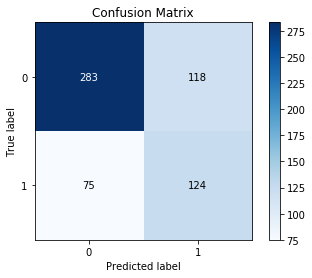

In [339]:
print('Accuracy score:', metrics.accuracy_score(y_test.values, prediction_BoW_W2VGoogle_mx))  # nn evaluate keras
print("F1 score", f1_score(y_test.values, prediction_BoW_W2VGoogle_mx,  average='macro'))
print("F1 weighted", f1_score(y_test.values, prediction_BoW_W2VGoogle_mx,  average='weighted'))
print("Recall score", recall_score(y_test.values, prediction_BoW_W2VGoogle_mx,  average='macro'))
print("Precision score", precision_score(y_test.values, prediction_BoW_W2VGoogle_mx,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test.values, prediction_BoW_W2VGoogle_mx, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test.values, prediction_BoW_W2VGoogle_mx)

### España

In [400]:
print(np.concatenate((x_train_tf_es,mean_emb_train_w2vgoogle_es),axis=1).shape)
BoW_W2VGoogle_es_train = np.concatenate((x_train_tf_es, mean_emb_train_w2vgoogle_es),axis=1)

print(np.concatenate((x_test_tf_es,mean_emb_test_w2vgoogle_es),axis=1).shape)
BoW_W2VGoogle_es_test= np.concatenate((x_test_tf_es, mean_emb_test_w2vgoogle_es),axis=1)

(2400, 7244)
(600, 7244)


In [401]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.1,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(BoW_W2VGoogle_es_train, y_train_es.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_BoW_W2VGoogle_es = linearSVC.best_estimator_
svc_BoW_W2VGoogle_es.fit(BoW_W2VGoogle_es_train, y_train_es.values)
svc_BoW_W2VGoogle_es.coef_ = svc_BoW_W2VGoogle_es.named_steps['SVC'].coef_
svc_BoW_W2VGoogle_es.score(BoW_W2VGoogle_es_train, y_train_es.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.5}
Tiempo de procesamiento (secs):  30.431158542633057


In [402]:
from joblib import dump, load
dump(svc_BoW_W2VGoogle_es, 'svc_W2VGoogle_es.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_BoW_W2VGoogle_es=svc_BoW_W2VGoogle_es.predict(BoW_W2VGoogle_es_test)
print("Acurracy Test",metrics.accuracy_score( y_test_es.values, prediction_BoW_W2VGoogle_es))

Acurracy Test 0.73


Accuracy score: 0.73
F1 score 0.6977461565252001
F1 weighted 0.7306582417035672
Recall score 0.69875
Precision score 0.6968211527035056
              precision    recall  f1-score   support

   no-ironia       0.80      0.79      0.80       400
      ironia       0.59      0.60      0.60       200

   micro avg       0.73      0.73      0.73       600
   macro avg       0.70      0.70      0.70       600
weighted avg       0.73      0.73      0.73       600



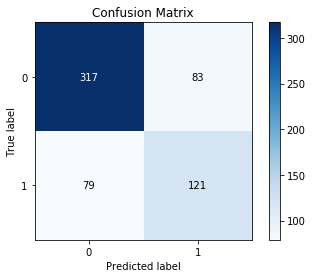

In [403]:
print('Accuracy score:', metrics.accuracy_score(y_test_es.values, prediction_BoW_W2VGoogle_es))  # nn evaluate keras
print("F1 score", f1_score(y_test_es.values, prediction_BoW_W2VGoogle_es,  average='macro'))
print("F1 weighted", f1_score(y_test_es.values, prediction_BoW_W2VGoogle_es,  average='weighted'))
print("Recall score", recall_score(y_test_es.values, prediction_BoW_W2VGoogle_es,  average='macro'))
print("Precision score", precision_score(y_test_es.values, prediction_BoW_W2VGoogle_es,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test_es.values, prediction_BoW_W2VGoogle_es, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_es.values, prediction_BoW_W2VGoogle_es)

### Cuba

In [404]:
print(np.concatenate((x_train_tf_cu,mean_emb_train_w2vgoogle_cu),axis=1).shape)
BoW_W2VGoogle_cu_train = np.concatenate((x_train_tf_cu, mean_emb_train_w2vgoogle_cu),axis=1)

print(np.concatenate((x_test_tf_cu,mean_emb_test_w2vgoogle_cu),axis=1).shape)
BoW_W2VGoogle_cu_test= np.concatenate((x_test_tf_cu, mean_emb_test_w2vgoogle_cu),axis=1)

(2400, 591)
(600, 591)


In [408]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.001,.1,.01)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(BoW_W2VGoogle_cu_train, y_train_cu.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_BoW_W2VGoogle_cu = linearSVC.best_estimator_
svc_BoW_W2VGoogle_cu.fit(BoW_W2VGoogle_cu_train, y_train_cu.values)
svc_BoW_W2VGoogle_cu.coef_ = svc_BoW_W2VGoogle_cu.named_steps['SVC'].coef_
svc_BoW_W2VGoogle_cu.score(BoW_W2VGoogle_cu_train, y_train_cu.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.040999999999999995}
Tiempo de procesamiento (secs):  2.283169746398926


In [409]:
from joblib import dump, load
dump(svc_BoW_W2VGoogle_cu, 'svc_W2VGoogle_cu.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_BoW_W2VGoogle_cu=svc_BoW_W2VGoogle_cu.predict(BoW_W2VGoogle_cu_test)
print("Acurracy Test",metrics.accuracy_score( y_test_cu.values, prediction_BoW_W2VGoogle_cu))

Acurracy Test 0.6433333333333333


Accuracy score: 0.6433333333333333
F1 score 0.6188734802431611
F1 weighted 0.651057497467072
Recall score 0.6287499999999999
Precision score 0.6179893695014662
              precision    recall  f1-score   support

   no-ironia       0.76      0.67      0.72       400
      ironia       0.47      0.58      0.52       200

   micro avg       0.64      0.64      0.64       600
   macro avg       0.62      0.63      0.62       600
weighted avg       0.67      0.64      0.65       600



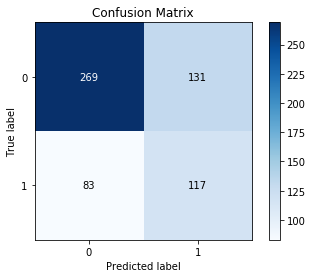

In [410]:
print('Accuracy score:', metrics.accuracy_score(y_test_cu.values, prediction_BoW_W2VGoogle_cu))  # nn evaluate keras
print("F1 score", f1_score(y_test_cu.values, prediction_BoW_W2VGoogle_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_cu.values, prediction_BoW_W2VGoogle_cu,  average='weighted'))
print("Recall score", recall_score(y_test_cu.values, prediction_BoW_W2VGoogle_cu,  average='macro'))
print("Precision score", precision_score(y_test_cu.values, prediction_BoW_W2VGoogle_cu,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test_cu.values, prediction_BoW_W2VGoogle_cu, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_cu.values, prediction_BoW_W2VGoogle_cu)

 # Clasificador NN

### México

In [ ]:
del nn_BoW_W2VGoogle_mx

In [479]:
from keras.utils import to_categorical

y_train_BoW_W2VGoogle_mx = to_categorical(y_train)
y_test_BoW_W2VGoogle_mx  = to_categorical(y_test)

num_mx, sz_mx = y_train_BoW_W2VGoogle_mx.shape

print(num_mx)
print(sz_mx)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_BoW_W2VGoogle_mx = Sequential()
nn_BoW_W2VGoogle_mx.add(Dense(512, activation='relu'))
nn_BoW_W2VGoogle_mx.add(Dropout(0.25))
nn_BoW_W2VGoogle_mx.add(Dense(sz_mx, activation='softmax'))
nn_BoW_W2VGoogle_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VGoogle_mx = nn_BoW_W2VGoogle_mx.fit(BoW_W2VGoogle_mx_train, 
              y_train_BoW_W2VGoogle_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 3s - loss: 0.6639 - acc: 0.6083 - val_loss: 0.4478 - val_acc: 0.8875
Epoch 2/20
 - 0s - loss: 0.5946 - acc: 0.6833 - val_loss: 0.4331 - val_acc: 0.8729
Epoch 3/20
 - 0s - loss: 0.5563 - acc: 0.7182 - val_loss: 0.4648 - val_acc: 0.8333
Epoch 4/20
 - 0s - loss: 0.5165 - acc: 0.7391 - val_loss: 0.4434 - val_acc: 0.8271
Epoch 5/20
 - 0s - loss: 0.4582 - acc: 0.7927 - val_loss: 0.5770 - val_acc: 0.6896
Epoch 6/20
 - 0s - loss: 0.4157 - acc: 0.8151 - val_loss: 0.5166 - val_acc: 0.7667
Epoch 7/20
 - 0s - loss: 0.3735 - acc: 0.8458 - val_loss: 0.4891 - val_acc: 0.7938
Epoch 8/20
 - 0s - loss: 0.3096 - acc: 0.8792 - val_loss: 0.5257 - val_acc: 0.7813
Epoch 9/20
 - 0s - loss: 0.2599 - acc: 0.9130 - val_loss: 0.5489 - val_acc: 0.7729
Epoch 10/20
 - 0s - loss: 0.2157 - acc: 0.9323 - val_loss: 0.6520 - val_acc: 0.7292
Epoch 11/20
 - 0s - loss: 0.1909 - acc: 0.9516 - val_loss: 0.5817 - val_acc: 0.7854
Epoch 12/20
 - 0s - loss: 0.164

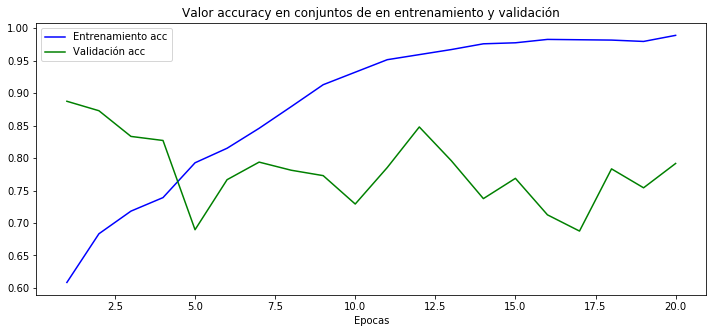

In [480]:
history_dict_BoW_W2VGoogle_mx = history_BoW_W2VGoogle_mx.history
dictkeys_BoW_W2VGoogle_mx=list(history_dict_BoW_W2VGoogle_mx.keys())
loss_values_BoW_W2VGoogle_mx = history_BoW_W2VGoogle_mx.history['acc']
val_loss_values_BoW_W2VGoogle_mx = history_BoW_W2VGoogle_mx.history['val_acc']
epochs_BoW_W2VGoogle_mx = range(1, len(loss_values_BoW_W2VGoogle_mx) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs_BoW_W2VGoogle_mx, loss_values_BoW_W2VGoogle_mx, 'b', label='Entrenamiento acc')
plt.plot(epochs_BoW_W2VGoogle_mx, val_loss_values_BoW_W2VGoogle_mx, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

In [481]:
del nn_BoW_W2VGoogle_mx

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 5

nn_BoW_W2VGoogle_mx = Sequential()
nn_BoW_W2VGoogle_mx.add(Dense(512, activation='relu'))
nn_BoW_W2VGoogle_mx.add(Dropout(0.25))
nn_BoW_W2VGoogle_mx.add(Dense(sz_es, activation='softmax'))
nn_BoW_W2VGoogle_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VGoogle_mx= nn_BoW_W2VGoogle_mx.fit(BoW_W2VGoogle_mx_train, 
              y_train_BoW_W2VGoogle_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Tiempo de procesamiento (secs):  3.8729870319366455


In [482]:
from keras.models import load_model
nn_BoW_W2VGoogle_mx.save('nn_BoW_W2VGoogle_mx')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_BoW_W2VGoogle_mx= nn_BoW_W2VGoogle_mx.predict(BoW_W2VGoogle_mx_test).squeeze()
y_test_label_BoW_W2VGoogle_mx = np.argmax(y_test_BoW_W2VGoogle_mx,1) 
y_pred_label_BoW_W2VGoogle_mx = np.argmax(y_pred_BoW_W2VGoogle_mx,1)


print("F1 score", f1_score(y_test_label_BoW_W2VGoogle_mx,  y_pred_label_BoW_W2VGoogle_mx,  average='macro'))
print("F1 weighted", f1_score(y_test_label_BoW_W2VGoogle_mx,  y_pred_label_BoW_W2VGoogle_mx,  average='weighted'))
print("Recall score", recall_score(y_test_label_BoW_W2VGoogle_mx,  y_pred_label_BoW_W2VGoogle_mx,   average='macro'))
print("Precision score", precision_score(y_test_label_BoW_W2VGoogle_mx,  y_pred_label_BoW_W2VGoogle_mx,   average='macro'))

F1 score 0.6253422354579952
F1 weighted 0.6598190755239606
Recall score 0.633065577262873
Precision score 0.6234264393067614


### España

In [ ]:
del nn_BoW_W2VGoogle_es

In [484]:
from keras.utils import to_categorical

y_train_BoW_W2VGoogle_es = to_categorical(y_train_es)
y_test_BoW_W2VGoogle_es  = to_categorical(y_test_es)

num_es, sz_es = y_train_BoW_W2VGoogle_es.shape

print(num_es)
print(sz_es)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_BoW_W2VGoogle_es = Sequential()
nn_BoW_W2VGoogle_es.add(Dense(512, activation='relu'))
nn_BoW_W2VGoogle_es.add(Dropout(0.25))
nn_BoW_W2VGoogle_es.add(Dense(sz_es, activation='softmax'))
nn_BoW_W2VGoogle_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VGoogle_es = nn_BoW_W2VGoogle_es.fit(BoW_W2VGoogle_es_train, 
              y_train_BoW_W2VGoogle_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 4s - loss: 0.5507 - acc: 0.7224 - val_loss: 0.6960 - val_acc: 0.5646
Epoch 2/20
 - 1s - loss: 0.3935 - acc: 0.8229 - val_loss: 0.7426 - val_acc: 0.5667
Epoch 3/20
 - 1s - loss: 0.2504 - acc: 0.9000 - val_loss: 1.0953 - val_acc: 0.4854
Epoch 4/20
 - 1s - loss: 0.1390 - acc: 0.9573 - val_loss: 0.8452 - val_acc: 0.5896
Epoch 5/20
 - 1s - loss: 0.0701 - acc: 0.9823 - val_loss: 0.9203 - val_acc: 0.6000
Epoch 6/20
 - 1s - loss: 0.0354 - acc: 0.9953 - val_loss: 1.2213 - val_acc: 0.5417
Epoch 7/20
 - 1s - loss: 0.0214 - acc: 0.9974 - val_loss: 1.1342 - val_acc: 0.5688
Epoch 8/20
 - 1s - loss: 0.0141 - acc: 0.9974 - val_loss: 1.0863 - val_acc: 0.5625
Epoch 9/20
 - 1s - loss: 0.0096 - acc: 0.9995 - val_loss: 1.1577 - val_acc: 0.5687
Epoch 10/20
 - 1s - loss: 0.0079 - acc: 0.9995 - val_loss: 1.2370 - val_acc: 0.5646
Epoch 11/20
 - 1s - loss: 0.0078 - acc: 0.9984 - val_loss: 1.1980 - val_acc: 0.5688
Epoch 12/20
 - 1s - loss: 0.005

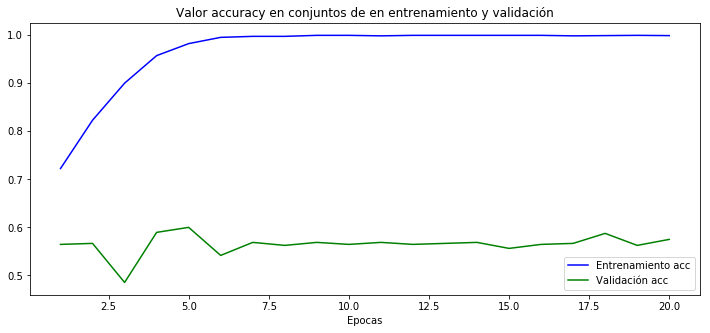

In [485]:
history_dict_BoW_W2VGoogle_es = history_BoW_W2VGoogle_es.history
dictkeys_BoW_W2VGoogle_es=list(history_dict_BoW_W2VGoogle_es.keys())
loss_values_BoW_W2VGoogle_es = history_BoW_W2VGoogle_es.history['acc']
val_loss_values_BoW_W2VGoogle_es = history_BoW_W2VGoogle_es.history['val_acc']
epochs_BoW_W2VGoogle_es = range(1, len(loss_values_BoW_W2VGoogle_es) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs_BoW_W2VGoogle_es, loss_values_BoW_W2VGoogle_es, 'b', label='Entrenamiento acc')
plt.plot(epochs_BoW_W2VGoogle_es, val_loss_values_BoW_W2VGoogle_es, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

In [486]:
del nn_BoW_W2VGoogle_es

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 5

nn_BoW_W2VGoogle_es = Sequential()
nn_BoW_W2VGoogle_es.add(Dense(512, activation='relu'))
nn_BoW_W2VGoogle_es.add(Dropout(0.25))
nn_BoW_W2VGoogle_es.add(Dense(sz_es, activation='softmax'))
nn_BoW_W2VGoogle_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VGoogle_es= nn_BoW_W2VGoogle_es.fit(BoW_W2VGoogle_es_train, 
              y_train_BoW_W2VGoogle_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Tiempo de procesamiento (secs):  9.44196629524231


In [487]:
from keras.models import load_model
nn_BoW_W2VGoogle_es.save('nn_BoW_W2VGoogle_es')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_BoW_W2VGoogle_es= nn_BoW_W2VGoogle_es.predict(BoW_W2VGoogle_es_test).squeeze()
y_test_label_BoW_W2VGoogle_es = np.argmax(y_test_BoW_W2VGoogle_es,1) 
y_pred_label_BoW_W2VGoogle_es = np.argmax(y_pred_BoW_W2VGoogle_es,1)


print("F1 score", f1_score(y_test_label_BoW_W2VGoogle_es,  y_pred_label_BoW_W2VGoogle_es,  average='macro'))
print("F1 weighted", f1_score(y_test_label_BoW_W2VGoogle_es,  y_pred_label_BoW_W2VGoogle_es,  average='weighted'))
print("Recall score", recall_score(y_test_label_BoW_W2VGoogle_es,  y_pred_label_BoW_W2VGoogle_es,   average='macro'))
print("Precision score", precision_score(y_test_label_BoW_W2VGoogle_es,  y_pred_label_BoW_W2VGoogle_es,   average='macro'))

F1 score 0.6332452012630254
F1 weighted 0.6921297217269062
Recall score 0.6275
Precision score 0.6879179793290222


### Cuba

In [ ]:
del nn_BoW_W2VGoogle_cu

In [490]:
from keras.utils import to_categorical

y_train_BoW_W2VGoogle_cu = to_categorical(y_train_cu)
y_test_BoW_W2VGoogle_cu  = to_categorical(y_test_cu)

num_cu, sz_cu = y_train_BoW_W2VGoogle_cu.shape

print(num_cu)
print(sz_cu)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_BoW_W2VGoogle_cu = Sequential()
nn_BoW_W2VGoogle_cu.add(Dense(512, activation='relu'))
nn_BoW_W2VGoogle_cu.add(Dropout(0.25))
nn_BoW_W2VGoogle_cu.add(Dense(sz_cu, activation='softmax'))
nn_BoW_W2VGoogle_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VGoogle_cu = nn_BoW_W2VGoogle_cu.fit(BoW_W2VGoogle_cu_train, 
              y_train_BoW_W2VGoogle_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 3s - loss: 0.6317 - acc: 0.6651 - val_loss: 0.8530 - val_acc: 0.4688
Epoch 2/20
 - 0s - loss: 0.5725 - acc: 0.7026 - val_loss: 1.2477 - val_acc: 0.4625
Epoch 3/20
 - 0s - loss: 0.5433 - acc: 0.7276 - val_loss: 1.1943 - val_acc: 0.4771
Epoch 4/20
 - 0s - loss: 0.5034 - acc: 0.7620 - val_loss: 1.9831 - val_acc: 0.3979
Epoch 5/20
 - 0s - loss: 0.4899 - acc: 0.7547 - val_loss: 2.0068 - val_acc: 0.4000
Epoch 6/20
 - 0s - loss: 0.4602 - acc: 0.7797 - val_loss: 2.0704 - val_acc: 0.3875
Epoch 7/20
 - 0s - loss: 0.4161 - acc: 0.8172 - val_loss: 2.5075 - val_acc: 0.3958
Epoch 8/20
 - 0s - loss: 0.3983 - acc: 0.8318 - val_loss: 2.7877 - val_acc: 0.3604
Epoch 9/20
 - 0s - loss: 0.3510 - acc: 0.8536 - val_loss: 3.4628 - val_acc: 0.3250
Epoch 10/20
 - 0s - loss: 0.3214 - acc: 0.8698 - val_loss: 2.8765 - val_acc: 0.4229
Epoch 11/20
 - 0s - loss: 0.2929 - acc: 0.8844 - val_loss: 3.0240 - val_acc: 0.4250
Epoch 12/20
 - 0s - loss: 0.262

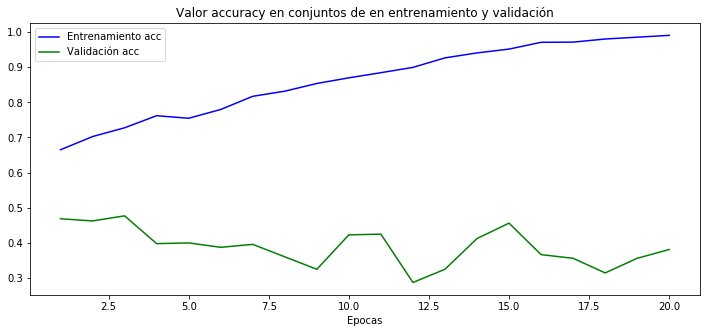

In [491]:
history_dict_BoW_W2VGoogle_cu = history_BoW_W2VGoogle_cu.history
dictkeys_BoW_W2VGoogle_cu=list(history_dict_BoW_W2VGoogle_cu.keys())
loss_values_BoW_W2VGoogle_cu = history_BoW_W2VGoogle_cu.history['acc']
val_loss_values_BoW_W2VGoogle_cu = history_BoW_W2VGoogle_cu.history['val_acc']
epochs_BoW_W2VGoogle_cu = range(1, len(loss_values_BoW_W2VGoogle_cu) + 1)


plt.figure(figsize=(12,5))
plt.plot(epochs_BoW_W2VGoogle_cu, loss_values_BoW_W2VGoogle_cu, 'b', label='Entrenamiento acc')
plt.plot(epochs_BoW_W2VGoogle_cu, val_loss_values_BoW_W2VGoogle_cu, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()

In [498]:
del nn_BoW_W2VGoogle_cu

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 10

nn_BoW_W2VGoogle_cu = Sequential()
nn_BoW_W2VGoogle_cu.add(Dense(512, activation='relu'))
nn_BoW_W2VGoogle_cu.add(Dropout(0.25))
nn_BoW_W2VGoogle_cu.add(Dense(sz_cu, activation='softmax'))
nn_BoW_W2VGoogle_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VGoogle_cu= nn_BoW_W2VGoogle_cu.fit(BoW_W2VGoogle_cu_train, 
              y_train_BoW_W2VGoogle_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Tiempo de procesamiento (secs):  5.439519166946411


In [499]:
from keras.models import load_model
nn_BoW_W2VGoogle_cu.save('nn_BoW_W2VGoogle_cu')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_BoW_W2VGoogle_cu= nn_BoW_W2VGoogle_cu.predict(BoW_W2VGoogle_cu_test).squeeze()
y_test_label_BoW_W2VGoogle_cu = np.argmax(y_test_BoW_W2VGoogle_cu,1) 
y_pred_label_BoW_W2VGoogle_cu = np.argmax(y_pred_BoW_W2VGoogle_cu,1)


print("F1 score", f1_score(y_test_label_BoW_W2VGoogle_cu,  y_pred_label_BoW_W2VGoogle_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_label_BoW_W2VGoogle_cu,  y_pred_label_BoW_W2VGoogle_cu,  average='weighted'))
print("Recall score", recall_score(y_test_label_BoW_W2VGoogle_cu,  y_pred_label_BoW_W2VGoogle_cu,   average='macro'))
print("Precision score", precision_score(y_test_label_BoW_W2VGoogle_cu,  y_pred_label_BoW_W2VGoogle_cu,   average='macro'))

F1 score 0.5453595317725752
F1 weighted 0.6039576365663322
Recall score 0.545
Precision score 0.5496031746031746


# Concatenar BoW TF-IDF + W2VTwitter

## Clasificador SVM 

### México

In [329]:
print(np.concatenate((x_train_tf_mx,mean_emb_train_w2vtwit_mx),axis=1).shape)
BoW_W2VTwitter_mx_train = np.concatenate((x_train_tf_mx, mean_emb_train_w2vtwit_mx),axis=1)

print(np.concatenate((x_test_tf_mx,mean_emb_test_w2vtwit_mx),axis=1).shape)
BoW_W2VTwitter_mx_test = np.concatenate((x_test_tf_mx, mean_emb_test_w2vtwit_mx),axis=1)

(2400, 586)
(600, 586)


In [427]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.001,.1,.001)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(BoW_W2VTwitter_mx_train, y_train.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_BoW_W2VTwit_mx = linearSVC.best_estimator_
svc_BoW_W2VTwit_mx.fit(BoW_W2VTwitter_mx_train, y_train.values)
svc_BoW_W2VTwit_mx.coef_ = svc_BoW_W2VTwit_mx.named_steps['SVC'].coef_
svc_BoW_W2VTwit_mx.score(BoW_W2VTwitter_mx_train, y_train.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)


{'SVC__C': 0.098}
Tiempo de procesamiento (secs):  16.694931507110596


In [428]:
from joblib import dump, load
dump(svc_BoW_W2VTwit_mx, 'svc_BoW_W2VTwit_mx.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_BoW_W2VTwitter_mx=svc_BoW_W2VTwit_mx.predict(BoW_W2VTwitter_mx_test)
print("Acurracy Test",metrics.accuracy_score( y_test.values, prediction_BoW_W2VTwitter_mx))


Acurracy Test 0.6583333333333333


Accuracy score: 0.6583333333333333
F1 score 0.6358781405510379
F1 weighted 0.6663207509001903
Recall score 0.6481973458314014
Precision score 0.6348522167487685
              precision    recall  f1-score   support

   no-ironia       0.78      0.68      0.73       401
      ironia       0.49      0.62      0.55       199

   micro avg       0.66      0.66      0.66       600
   macro avg       0.63      0.65      0.64       600
weighted avg       0.68      0.66      0.67       600



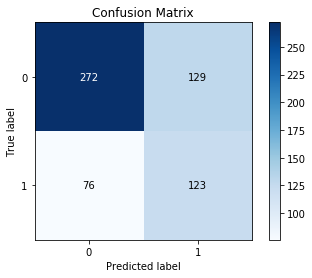

In [429]:

print('Accuracy score:', metrics.accuracy_score(y_test.values, prediction_BoW_W2VTwitter_mx))  # nn evaluate keras
print("F1 score", f1_score(y_test.values, prediction_BoW_W2VTwitter_mx,  average='macro'))
print("F1 weighted", f1_score(y_test.values, prediction_BoW_W2VTwitter_mx,  average='weighted'))
print("Recall score", recall_score(y_test.values, prediction_BoW_W2VTwitter_mx,  average='macro'))
print("Precision score", precision_score(y_test.values, prediction_BoW_W2VTwitter_mx,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test.values, prediction_BoW_W2VTwitter_mx, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test.values, prediction_BoW_W2VTwitter_mx)

### España

In [411]:
print(np.concatenate((x_train_tf_es,mean_emb_train_w2vtwit_es),axis=1).shape)
BoW_W2VTwitter_es_train = np.concatenate((x_train_tf_es, mean_emb_train_w2vtwit_es),axis=1)

print(np.concatenate((x_test_tf_es,mean_emb_test_w2vtwit_es),axis=1).shape)
BoW_W2VTwitter_es_test = np.concatenate((x_test_tf_es, mean_emb_test_w2vtwit_es),axis=1)

(2400, 7344)
(600, 7344)


In [421]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.01,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(BoW_W2VTwitter_es_train, y_train_es.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_BoW_W2VTwit_es = linearSVC.best_estimator_
svc_BoW_W2VTwit_es.fit(BoW_W2VTwitter_es_train, y_train_es.values)
svc_BoW_W2VTwit_es.coef_ = svc_BoW_W2VTwit_es.named_steps['SVC'].coef_
svc_BoW_W2VTwit_es.score(BoW_W2VTwitter_es_train, y_train_es.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.01}
Tiempo de procesamiento (secs):  20.656206130981445


In [422]:
from joblib import dump, load
dump(svc_BoW_W2VTwit_es, 'svc_BoW_W2VTwit_es.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_BoW_W2VTwitter_es=svc_BoW_W2VTwit_es.predict(BoW_W2VTwitter_es_test)
print("Acurracy Test",metrics.accuracy_score( y_test_es.values, prediction_BoW_W2VTwitter_es))


Acurracy Test 0.6883333333333334


Accuracy score: 0.6883333333333334
F1 score 0.676872168671576
F1 weighted 0.697157415860527
Recall score 0.70375
Precision score 0.6814518373390033
              precision    recall  f1-score   support

   no-ironia       0.84      0.66      0.74       400
      ironia       0.52      0.75      0.62       200

   micro avg       0.69      0.69      0.69       600
   macro avg       0.68      0.70      0.68       600
weighted avg       0.73      0.69      0.70       600



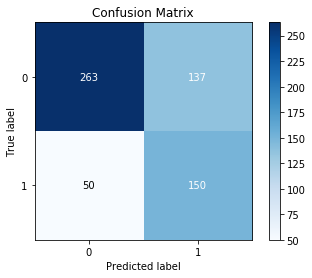

In [423]:

print('Accuracy score:', metrics.accuracy_score(y_test_es.values, prediction_BoW_W2VTwitter_es))  # nn evaluate keras
print("F1 score", f1_score(y_test_es.values, prediction_BoW_W2VTwitter_es,  average='macro'))
print("F1 weighted", f1_score(y_test_es.values, prediction_BoW_W2VTwitter_es,  average='weighted'))
print("Recall score", recall_score(y_test_es.values, prediction_BoW_W2VTwitter_es,  average='macro'))
print("Precision score", precision_score(y_test_es.values, prediction_BoW_W2VTwitter_es,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test_es.values, prediction_BoW_W2VTwitter_es, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_es.values, prediction_BoW_W2VTwitter_es)

### Cuba

In [430]:
print(np.concatenate((x_train_tf_cu,mean_emb_train_w2vtwit_cu),axis=1).shape)
BoW_W2VTwitter_cu_train = np.concatenate((x_train_tf_cu, mean_emb_train_w2vtwit_cu),axis=1)

print(np.concatenate((x_test_tf_cu,mean_emb_test_w2vtwit_cu),axis=1).shape)
BoW_W2VTwitter_cu_test = np.concatenate((x_test_tf_cu, mean_emb_test_w2vtwit_cu),axis=1)

(2400, 691)
(600, 691)


In [434]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.001,.1,.01)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(BoW_W2VTwitter_cu_train, y_train_cu.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_BoW_W2VTwit_cu = linearSVC.best_estimator_
svc_BoW_W2VTwit_cu.fit(BoW_W2VTwitter_cu_train, y_train_cu.values)
svc_BoW_W2VTwit_cu.coef_ = svc_BoW_W2VTwit_cu.named_steps['SVC'].coef_
svc_BoW_W2VTwit_cu.score(BoW_W2VTwitter_cu_train, y_train_cu.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.001}
Tiempo de procesamiento (secs):  1.751384973526001


In [435]:
from joblib import dump, load
dump(svc_BoW_W2VTwit_cu, 'svc_BoW_W2VTwit_cu.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_BoW_W2VTwitter_cu=svc_BoW_W2VTwit_cu.predict(BoW_W2VTwitter_cu_test)
print("Acurracy Test",metrics.accuracy_score( y_test_cu.values, prediction_BoW_W2VTwitter_cu))

Acurracy Test 0.6533333333333333


In [ ]:
print('Accuracy score:', metrics.accuracy_score(y_test_cu.values, prediction_BoW_W2VTwitter_cu))  # nn evaluate keras
print("F1 score", f1_score(y_test_cu.values, prediction_BoW_W2VTwitter_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_cu.values, prediction_BoW_W2VTwitter_cu,  average='weighted'))
print("Recall score", recall_score(y_test_cu.values, prediction_BoW_W2VTwitter_cu,  average='macro'))
print("Precision score", precision_score(y_test_cu.values, prediction_BoW_W2VTwitter_cu,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test_cu.values, prediction_BoW_W2VTwitter_cu, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_cu.values, prediction_BoW_W2VTwitter_cu)

## Clasificador NN

### México

In [ ]:
del nn_BoW_W2VTwitter_mx

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 2s - loss: 0.6588 - acc: 0.6156 - val_loss: 0.4527 - val_acc: 0.8854
Epoch 2/20
 - 0s - loss: 0.6104 - acc: 0.6500 - val_loss: 0.4557 - val_acc: 0.8687
Epoch 3/20
 - 0s - loss: 0.5795 - acc: 0.6870 - val_loss: 0.5236 - val_acc: 0.7708
Epoch 4/20
 - 0s - loss: 0.5489 - acc: 0.7172 - val_loss: 0.4350 - val_acc: 0.8458
Epoch 5/20
 - 0s - loss: 0.5129 - acc: 0.7422 - val_loss: 0.5643 - val_acc: 0.7292
Epoch 6/20
 - 0s - loss: 0.4752 - acc: 0.7693 - val_loss: 0.6684 - val_acc: 0.5667
Epoch 7/20
 - 0s - loss: 0.4381 - acc: 0.8016 - val_loss: 0.5588 - val_acc: 0.7354
Epoch 8/20
 - 0s - loss: 0.3689 - acc: 0.8578 - val_loss: 0.5127 - val_acc: 0.7896
Epoch 9/20
 - 0s - loss: 0.3187 - acc: 0.8844 - val_loss: 0.4727 - val_acc: 0.8375
Epoch 10/20
 - 0s - loss: 0.2619 - acc: 0.9115 - val_loss: 0.5675 - val_acc: 0.7604
Epoch 11/20
 - 0s - loss: 0.2028 - acc: 0.9531 - val_loss: 0.5557 - val_acc: 0.7750
Epoch 12/20
 - 0s - loss: 0.173

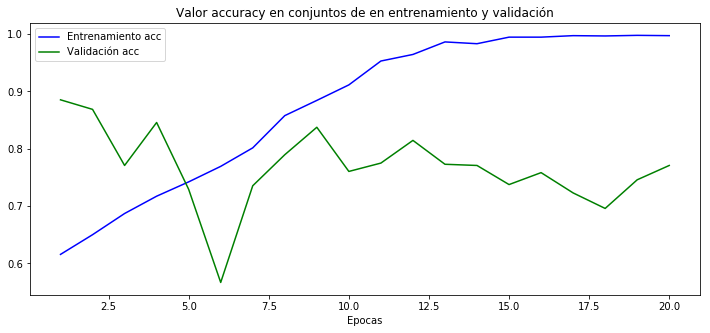

In [500]:
from keras.utils import to_categorical

y_train_BoW_W2VTwitter_mx = to_categorical(y_train)
y_test_BoW_W2VTwitter_mx  = to_categorical(y_test)

num_mx, sz_mx = y_train_BoW_W2VTwitter_mx.shape

print(num_mx)
print(sz_mx)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_BoW_W2VTwitter_mx = Sequential()
nn_BoW_W2VTwitter_mx.add(Dense(512, activation='relu'))
nn_BoW_W2VTwitter_mx.add(Dropout(0.25))
nn_BoW_W2VTwitter_mx.add(Dense(sz_mx, activation='softmax'))
nn_BoW_W2VTwitter_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VTwitter_mx = nn_BoW_W2VTwitter_mx.fit(BoW_W2VTwitter_mx_train, 
              y_train_BoW_W2VTwitter_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic) 

history_dict_BoW_W2VTwitter_mx = history_BoW_W2VTwitter_mx.history
dictkeys_BoW_W2VTwitter_mx=list(history_dict_BoW_W2VTwitter_mx.keys())
loss_values_BoW_W2VTwitter_mx = history_BoW_W2VTwitter_mx.history['acc']
val_loss_values_BoW_W2VTwitter_mx = history_BoW_W2VTwitter_mx.history['val_acc']
epochs_BoW_W2VTwitter_mx = range(1, len(loss_values_BoW_W2VTwitter_mx) + 1)



plt.figure(figsize=(12,5))
plt.plot(epochs_BoW_W2VTwitter_mx, loss_values_BoW_W2VTwitter_mx, 'b', label='Entrenamiento acc')
plt.plot(epochs_BoW_W2VTwitter_mx, val_loss_values_BoW_W2VTwitter_mx, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()


In [503]:
del nn_BoW_W2VTwitter_mx

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 5

nn_BoW_W2VTwitter_mx = Sequential()
nn_BoW_W2VTwitter_mx.add(Dense(512, activation='relu'))
nn_BoW_W2VTwitter_mx.add(Dropout(0.25))
nn_BoW_W2VTwitter_mx.add(Dense(sz_mx, activation='softmax'))
nn_BoW_W2VTwitter_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VTwitter_mx= nn_BoW_W2VTwitter_mx.fit(BoW_W2VTwitter_mx_train, 
              y_train_BoW_W2VTwitter_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


from keras.models import load_model
nn_BoW_W2VTwitter_mx.save('nn_BoW_W2VTwitter_mx')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_BoW_W2VTwitter_mx= nn_BoW_W2VTwitter_mx.predict(BoW_W2VTwitter_mx_test).squeeze()
y_test_label_BoW_W2VTwitter_mx = np.argmax(y_test_BoW_W2VTwitter_mx,1) 
y_pred_label_BoW_W2VTwitter_mx = np.argmax(y_pred_BoW_W2VTwitter_mx,1)


print("F1 score", f1_score(y_test_label_BoW_W2VTwitter_mx,  y_pred_label_BoW_W2VTwitter_mx,  average='macro'))
print("F1 weighted", f1_score(y_test_label_BoW_W2VTwitter_mx,  y_pred_label_BoW_W2VTwitter_mx,  average='weighted'))
print("Recall score", recall_score(y_test_label_BoW_W2VTwitter_mx,  y_pred_label_BoW_W2VTwitter_mx,   average='macro'))
print("Precision score", precision_score(y_test_label_BoW_W2VTwitter_mx,  y_pred_label_BoW_W2VTwitter_mx,   average='macro'))

Tiempo de procesamiento (secs):  3.215589761734009
F1 score 0.6225329493327938
F1 weighted 0.6667993491802051
Recall score 0.621505282021078
Precision score 0.6237745098039216


### España

In [ ]:
del nn_BoW_W2VTwitter_es

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/10
 - 3s - loss: 0.5433 - acc: 0.7146 - val_loss: 0.7139 - val_acc: 0.5479
Epoch 2/10
 - 1s - loss: 0.3371 - acc: 0.8578 - val_loss: 0.7635 - val_acc: 0.5542
Epoch 3/10
 - 1s - loss: 0.1715 - acc: 0.9380 - val_loss: 1.1933 - val_acc: 0.4771
Epoch 4/10
 - 1s - loss: 0.0734 - acc: 0.9833 - val_loss: 1.1235 - val_acc: 0.5104
Epoch 5/10
 - 1s - loss: 0.0325 - acc: 0.9958 - val_loss: 0.9634 - val_acc: 0.5875
Epoch 6/10
 - 1s - loss: 0.0177 - acc: 0.9979 - val_loss: 1.2088 - val_acc: 0.5563
Epoch 7/10
 - 1s - loss: 0.0113 - acc: 0.9984 - val_loss: 1.1642 - val_acc: 0.5687
Epoch 8/10
 - 1s - loss: 0.0076 - acc: 0.9990 - val_loss: 1.1494 - val_acc: 0.5937
Epoch 9/10
 - 1s - loss: 0.0054 - acc: 0.9995 - val_loss: 1.1794 - val_acc: 0.5938
Epoch 10/10
 - 1s - loss: 0.0049 - acc: 0.9995 - val_loss: 1.2465 - val_acc: 0.5833
Tiempo de procesamiento (secs):  8.65994381904602


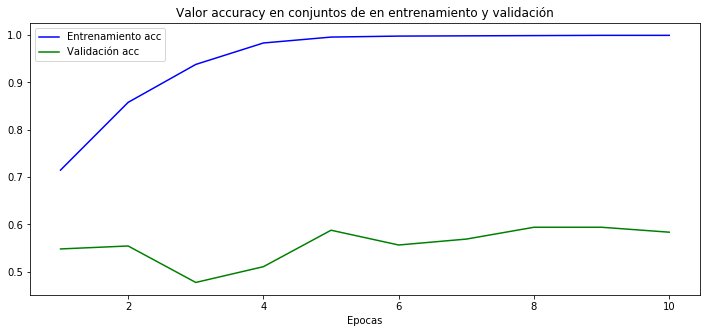

In [504]:
from keras.utils import to_categorical

y_train_BoW_W2VTwitter_es = to_categorical(y_train_es)
y_test_BoW_W2VTwitter_es  = to_categorical(y_test_es)

num_es, sz_es = y_train_BoW_W2VTwitter_es.shape

print(num_es)
print(sz_es)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 10

nn_BoW_W2VTwitter_es = Sequential()
nn_BoW_W2VTwitter_es.add(Dense(512, activation='relu'))
nn_BoW_W2VTwitter_es.add(Dropout(0.25))
nn_BoW_W2VTwitter_es.add(Dense(sz_es, activation='softmax'))
nn_BoW_W2VTwitter_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VTwitter_es = nn_BoW_W2VTwitter_es.fit(BoW_W2VTwitter_es_train, 
              y_train_BoW_W2VTwitter_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic) 

history_dict_BoW_W2VTwitter_es = history_BoW_W2VTwitter_es.history
dictkeys_BoW_W2VTwitter_es=list(history_dict_BoW_W2VTwitter_es.keys())
loss_values_BoW_W2VTwitter_es = history_BoW_W2VTwitter_es.history['acc']
val_loss_values_BoW_W2VTwitter_es = history_BoW_W2VTwitter_es.history['val_acc']
epochs_BoW_W2VTwitter_es = range(1, len(loss_values_BoW_W2VTwitter_es) + 1)



plt.figure(figsize=(12,5))
plt.plot(epochs_BoW_W2VTwitter_es, loss_values_BoW_W2VTwitter_es, 'b', label='Entrenamiento acc')
plt.plot(epochs_BoW_W2VTwitter_es, val_loss_values_BoW_W2VTwitter_es, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()


In [505]:
del nn_BoW_W2VTwitter_es

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 3

nn_BoW_W2VTwitter_es = Sequential()
nn_BoW_W2VTwitter_es.add(Dense(512, activation='relu'))
nn_BoW_W2VTwitter_es.add(Dropout(0.25))
nn_BoW_W2VTwitter_es.add(Dense(sz_es, activation='softmax'))
nn_BoW_W2VTwitter_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VTwitter_es= nn_BoW_W2VTwitter_es.fit(BoW_W2VTwitter_es_train, 
              y_train_BoW_W2VTwitter_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


from keras.models import load_model
nn_BoW_W2VTwitter_es.save('nn_BoW_W2VTwitter_es')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_BoW_W2VTwitter_es= nn_BoW_W2VTwitter_es.predict(BoW_W2VTwitter_es_test).squeeze()
y_test_label_BoW_W2VTwitter_es = np.argmax(y_test_BoW_W2VTwitter_es,1) 
y_pred_label_BoW_W2VTwitter_es = np.argmax(y_pred_BoW_W2VTwitter_es,1)


print("F1 score", f1_score(y_test_label_BoW_W2VTwitter_es,  y_pred_label_BoW_W2VTwitter_es,  average='macro'))
print("F1 weighted", f1_score(y_test_label_BoW_W2VTwitter_es,  y_pred_label_BoW_W2VTwitter_es,  average='weighted'))
print("Recall score", recall_score(y_test_label_BoW_W2VTwitter_es,  y_pred_label_BoW_W2VTwitter_es,   average='macro'))
print("Precision score", precision_score(y_test_label_BoW_W2VTwitter_es,  y_pred_label_BoW_W2VTwitter_es,   average='macro'))

Tiempo de procesamiento (secs):  4.407065153121948
F1 score 0.6536495695839312
F1 weighted 0.6644249163079866
Recall score 0.70375
Precision score 0.6850926598837209


### Cuba

In [512]:
del nn_BoW_W2VTwitter_cu

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 3s - loss: 0.6261 - acc: 0.6682 - val_loss: 0.8988 - val_acc: 0.4896
Epoch 2/20
 - 0s - loss: 0.5626 - acc: 0.7052 - val_loss: 1.2769 - val_acc: 0.4750
Epoch 3/20
 - 0s - loss: 0.5247 - acc: 0.7323 - val_loss: 1.3855 - val_acc: 0.5021
Epoch 4/20
 - 0s - loss: 0.4921 - acc: 0.7583 - val_loss: 2.0695 - val_acc: 0.4208
Epoch 5/20
 - 0s - loss: 0.4637 - acc: 0.7839 - val_loss: 2.3767 - val_acc: 0.3979
Epoch 6/20
 - 0s - loss: 0.4451 - acc: 0.7953 - val_loss: 2.3426 - val_acc: 0.4354
Epoch 7/20
 - 0s - loss: 0.3950 - acc: 0.8198 - val_loss: 2.9434 - val_acc: 0.4083
Epoch 8/20
 - 0s - loss: 0.3654 - acc: 0.8495 - val_loss: 3.2471 - val_acc: 0.4042
Epoch 9/20
 - 0s - loss: 0.3186 - acc: 0.8729 - val_loss: 3.9460 - val_acc: 0.3792
Epoch 10/20
 - 0s - loss: 0.2778 - acc: 0.8990 - val_loss: 3.4026 - val_acc: 0.4875
Epoch 11/20
 - 0s - loss: 0.2456 - acc: 0.9141 - val_loss: 3.7999 - val_acc: 0.4792
Epoch 12/20
 - 0s - loss: 0.201

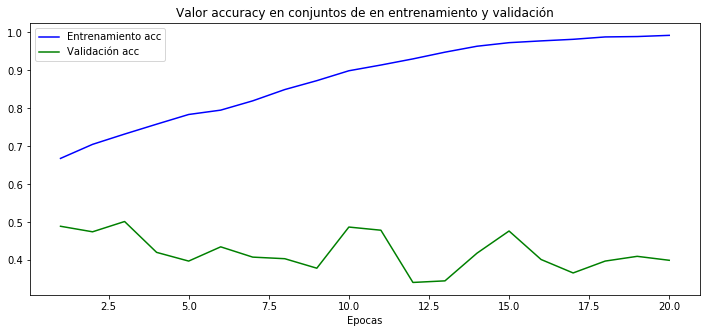

In [513]:
from keras.utils import to_categorical

y_train_BoW_W2VTwitter_cu = to_categorical(y_train_cu)
y_test_BoW_W2VTwitter_cu  = to_categorical(y_test_cu)

num_cu, sz_cu = y_train_BoW_W2VTwitter_cu.shape

print(num_cu)
print(sz_cu)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_BoW_W2VTwitter_cu = Sequential()
nn_BoW_W2VTwitter_cu.add(Dense(512, activation='relu'))
nn_BoW_W2VTwitter_cu.add(Dropout(0.25))
nn_BoW_W2VTwitter_cu.add(Dense(sz_cu, activation='softmax'))
nn_BoW_W2VTwitter_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VTwitter_cu = nn_BoW_W2VTwitter_cu.fit(BoW_W2VTwitter_cu_train, 
              y_train_BoW_W2VTwitter_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic) 

history_dict_BoW_W2VTwitter_cu = history_BoW_W2VTwitter_cu.history
dictkeys_BoW_W2VTwitter_cu=list(history_dict_BoW_W2VTwitter_cu.keys())
loss_values_BoW_W2VTwitter_cu = history_BoW_W2VTwitter_cu.history['acc']
val_loss_values_BoW_W2VTwitter_cu = history_BoW_W2VTwitter_cu.history['val_acc']
epochs_BoW_W2VTwitter_cu = range(1, len(loss_values_BoW_W2VTwitter_cu) + 1)



plt.figure(figsize=(12,5))
plt.plot(epochs_BoW_W2VTwitter_cu, loss_values_BoW_W2VTwitter_cu, 'b', label='Entrenamiento acc')
plt.plot(epochs_BoW_W2VTwitter_cu, val_loss_values_BoW_W2VTwitter_cu, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()


In [518]:
del nn_BoW_W2VTwitter_cu

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 6

nn_BoW_W2VTwitter_cu = Sequential()
nn_BoW_W2VTwitter_cu.add(Dense(512, activation='relu'))
nn_BoW_W2VTwitter_cu.add(Dropout(0.25))
nn_BoW_W2VTwitter_cu.add(Dense(sz_cu, activation='softmax'))
nn_BoW_W2VTwitter_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_BoW_W2VTwitter_cu= nn_BoW_W2VTwitter_cu.fit(BoW_W2VTwitter_cu_train, 
              y_train_BoW_W2VTwitter_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


from keras.models import load_model
nn_BoW_W2VTwitter_cu.save('nn_BoW_W2VTwitter_cu')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_BoW_W2VTwitter_cu= nn_BoW_W2VTwitter_cu.predict(BoW_W2VTwitter_cu_test).squeeze()
y_test_label_BoW_W2VTwitter_cu = np.argmax(y_test_BoW_W2VTwitter_cu,1) 
y_pred_label_BoW_W2VTwitter_cu = np.argmax(y_pred_BoW_W2VTwitter_cu,1)


print("F1 score", f1_score(y_test_label_BoW_W2VTwitter_cu,  y_pred_label_BoW_W2VTwitter_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_label_BoW_W2VTwitter_cu,  y_pred_label_BoW_W2VTwitter_cu,  average='weighted'))
print("Recall score", recall_score(y_test_label_BoW_W2VTwitter_cu,  y_pred_label_BoW_W2VTwitter_cu,   average='macro'))
print("Precision score", precision_score(y_test_label_BoW_W2VTwitter_cu,  y_pred_label_BoW_W2VTwitter_cu,   average='macro'))

Tiempo de procesamiento (secs):  4.555535554885864
F1 score 0.5816979962817599
F1 weighted 0.6337533567444742
Recall score 0.5800000000000001
Precision score 0.5857632933104631


# Concatenar BoW TF-IDF + W2VGoogle + W2VTwitter

## Clasificador SVM

### México

In [342]:
print(np.concatenate((x_train_tf_mx, mean_emb_train_w2vgoogle_mx,  mean_emb_train_w2vtwit_mx),axis=1).shape)
BoW_W2V_Twitter_Google_mx_train = np.concatenate((x_train_tf_mx, mean_emb_train_w2vgoogle_mx,  mean_emb_train_w2vtwit_mx),axis=1)

print(np.concatenate((x_test_tf_mx, mean_emb_test_w2vgoogle_mx,  mean_emb_test_w2vtwit_mx),axis=1).shape)
BoW_W2V_Twitter_Google_mx_test = np.concatenate((x_test_tf_mx, mean_emb_test_w2vgoogle_mx,  mean_emb_test_w2vtwit_mx),axis=1)

(2400, 886)
(600, 886)


In [350]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.01,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(BoW_W2V_Twitter_Google_mx_train, y_train.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_BoW_W2V_Twitter_Google_mx = linearSVC.best_estimator_
svc_BoW_W2V_Twitter_Google_mx.fit(BoW_W2V_Twitter_Google_mx_train, y_train.values)
svc_BoW_W2V_Twitter_Google_mx.coef_ = svc_BoW_W2V_Twitter_Google_mx.named_steps['SVC'].coef_
svc_BoW_W2V_Twitter_Google_mx.score(BoW_W2V_Twitter_Google_mx_train, y_train.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)


{'SVC__C': 0.21000000000000002}
Tiempo de procesamiento (secs):  75.92161464691162


In [355]:
from joblib import dump, load
dump(svc_BoW_W2V_Twitter_Google_mx, 'svc_BoW_W2V_Twitter_Google_mx.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_BoW_W2V_Twitter_Google_mx=svc_BoW_W2V_Twitter_Google_mx.predict(BoW_W2V_Twitter_Google_mx_test)
print("Acurracy Test",metrics.accuracy_score( y_test.values, prediction_BoW_W2V_Twitter_Google_mx))


Acurracy Test 0.67


Accuracy score: 0.67
F1 score 0.6447368421052632
F1 weighted 0.6766315789473684
Recall score 0.6543941653404177
Precision score 0.642402246905304
              precision    recall  f1-score   support

   no-ironia       0.78      0.70      0.74       401
      ironia       0.50      0.61      0.55       199

   micro avg       0.67      0.67      0.67       600
   macro avg       0.64      0.65      0.64       600
weighted avg       0.69      0.67      0.68       600



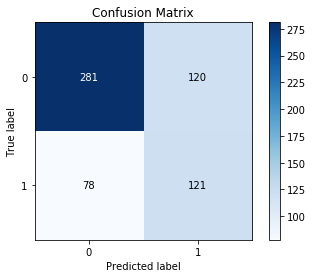

In [356]:
print('Accuracy score:', metrics.accuracy_score(y_test.values, prediction_BoW_W2V_Twitter_Google_mx))  # nn evaluate keras
print("F1 score", f1_score(y_test.values, prediction_BoW_W2V_Twitter_Google_mx,  average='macro'))
print("F1 weighted", f1_score(y_test.values, prediction_BoW_W2V_Twitter_Google_mx,  average='weighted'))
print("Recall score", recall_score(y_test.values, prediction_BoW_W2V_Twitter_Google_mx,  average='macro'))
print("Precision score", precision_score(y_test.values, prediction_BoW_W2V_Twitter_Google_mx,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test.values, prediction_BoW_W2V_Twitter_Google_mx, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test.values, prediction_BoW_W2V_Twitter_Google_mx)

### España

In [365]:
print(np.concatenate((x_train_tf_es, mean_emb_train_w2vgoogle_es,  mean_emb_train_w2vtwit_es),axis=1).shape)
BoW_W2V_Twitter_Google_es_train = np.concatenate((x_train_tf_es, mean_emb_train_w2vgoogle_es,  mean_emb_train_w2vtwit_es),axis=1)

print(np.concatenate((x_test_tf_es, mean_emb_test_w2vgoogle_es,  mean_emb_test_w2vtwit_es),axis=1).shape)
BoW_W2V_Twitter_Google_es_test = np.concatenate((x_test_tf_es, mean_emb_test_w2vgoogle_es,  mean_emb_test_w2vtwit_es),axis=1)

(2400, 7644)
(600, 7644)


In [372]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.01,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(BoW_W2V_Twitter_Google_es_train, y_train_es.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_BoW_W2V_Twitter_Google_es = linearSVC.best_estimator_
svc_BoW_W2V_Twitter_Google_es.fit(BoW_W2V_Twitter_Google_es_train, y_train_es.values)
svc_BoW_W2V_Twitter_Google_es.coef_ = svc_BoW_W2V_Twitter_Google_es.named_steps['SVC'].coef_
svc_BoW_W2V_Twitter_Google_es.score(BoW_W2V_Twitter_Google_es_train, y_train_es.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.01}
Tiempo de procesamiento (secs):  44.04638862609863


In [373]:
from joblib import dump, load
dump(svc_BoW_W2V_Twitter_Google_es, 'svc_BoW_W2V_Twitter_Google_es.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_BoW_W2V_Twitter_Google_es=svc_BoW_W2V_Twitter_Google_es.predict(BoW_W2V_Twitter_Google_es_test)
print("Acurracy Test",metrics.accuracy_score( y_test_es.values, prediction_BoW_W2V_Twitter_Google_es))

Acurracy Test 0.6983333333333334


Accuracy score: 0.6983333333333334
F1 score 0.6827446386473119
F1 weighted 0.706186284791705
Recall score 0.7024999999999999
Precision score 0.682204676586699
              precision    recall  f1-score   support

   no-ironia       0.83      0.69      0.75       400
      ironia       0.54      0.71      0.61       200

   micro avg       0.70      0.70      0.70       600
   macro avg       0.68      0.70      0.68       600
weighted avg       0.73      0.70      0.71       600



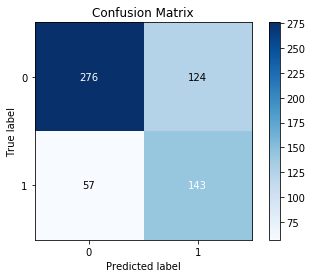

In [374]:
print('Accuracy score:', metrics.accuracy_score(y_test_es.values, prediction_BoW_W2V_Twitter_Google_es))  # nn evaluate keras
print("F1 score", f1_score(y_test_es.values, prediction_BoW_W2V_Twitter_Google_es,  average='macro'))
print("F1 weighted", f1_score(y_test_es.values, prediction_BoW_W2V_Twitter_Google_es,  average='weighted'))
print("Recall score", recall_score(y_test_es.values, prediction_BoW_W2V_Twitter_Google_es,  average='macro'))
print("Precision score", precision_score(y_test_es.values, prediction_BoW_W2V_Twitter_Google_es,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test_es.values, prediction_BoW_W2V_Twitter_Google_es, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot
#0.6827446386473119
scikitplot.metrics.plot_confusion_matrix(y_test_es.values, prediction_BoW_W2V_Twitter_Google_es)

### Cuba

In [375]:
print(np.concatenate((x_train_tf_cu, mean_emb_train_w2vgoogle_cu,  mean_emb_train_w2vtwit_cu),axis=1).shape)
BoW_W2V_Twitter_Google_cu_train = np.concatenate((x_train_tf_cu, mean_emb_train_w2vgoogle_cu,  mean_emb_train_w2vtwit_cu),axis=1)

print(np.concatenate((x_test_tf_cu, mean_emb_test_w2vgoogle_cu,  mean_emb_test_w2vtwit_cu),axis=1).shape)
BoW_W2V_Twitter_Google_cu_test = np.concatenate((x_test_tf_cu, mean_emb_test_w2vgoogle_cu,  mean_emb_test_w2vtwit_cu),axis=1)

(2400, 991)
(600, 991)


In [380]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.001,1,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(BoW_W2V_Twitter_Google_cu_train, y_train_cu.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_BoW_W2V_Twitter_Google_cu = linearSVC.best_estimator_
svc_BoW_W2V_Twitter_Google_cu.fit(BoW_W2V_Twitter_Google_cu_train, y_train_cu.values)
svc_BoW_W2V_Twitter_Google_cu.coef_ = svc_BoW_W2V_Twitter_Google_cu.named_steps['SVC'].coef_
svc_BoW_W2V_Twitter_Google_cu.score(BoW_W2V_Twitter_Google_cu_train, y_train_cu.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.001}
Tiempo de procesamiento (secs):  22.981482982635498


In [381]:
from joblib import dump, load
dump(svc_BoW_W2V_Twitter_Google_cu, 'svc_BoW_W2V_Twitter_Google_cu.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_BoW_W2V_Twitter_Google_cu=svc_BoW_W2V_Twitter_Google_cu.predict(BoW_W2V_Twitter_Google_cu_test)
print("Acurracy Test",metrics.accuracy_score( y_test_cu.values, prediction_BoW_W2V_Twitter_Google_cu))

Acurracy Test 0.63


Accuracy score: 0.63
F1 score 0.6123579810020487
F1 weighted 0.6399236356863476
Recall score 0.6287499999999999
Precision score 0.615450143472023
              precision    recall  f1-score   support

   no-ironia       0.77      0.63      0.70       400
      ironia       0.46      0.62      0.53       200

   micro avg       0.63      0.63      0.63       600
   macro avg       0.62      0.63      0.61       600
weighted avg       0.67      0.63      0.64       600



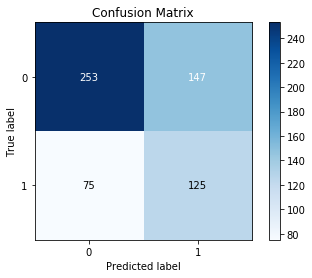

In [382]:
print('Accuracy score:', metrics.accuracy_score(y_test_cu.values, prediction_BoW_W2V_Twitter_Google_cu))  # nn evaluate keras
print("F1 score", f1_score(y_test_cu.values, prediction_BoW_W2V_Twitter_Google_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_cu.values, prediction_BoW_W2V_Twitter_Google_cu,  average='weighted'))
print("Recall score", recall_score(y_test_cu.values, prediction_BoW_W2V_Twitter_Google_cu,  average='macro'))
print("Precision score", precision_score(y_test_cu.values, prediction_BoW_W2V_Twitter_Google_cu,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test_cu.values, prediction_BoW_W2V_Twitter_Google_cu, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot
#0.6827446386473119
scikitplot.metrics.plot_confusion_matrix(y_test_cu.values, prediction_BoW_W2V_Twitter_Google_cu)

## Clasificador NN

### México

In [522]:
del nn_Bow_W2V_Twitter_Google_mx
# BoW_W2V_Twitter_Google_mx_train

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 3s - loss: 0.6636 - acc: 0.6146 - val_loss: 0.4435 - val_acc: 0.8875
Epoch 2/20
 - 0s - loss: 0.5993 - acc: 0.6745 - val_loss: 0.4519 - val_acc: 0.8688
Epoch 3/20
 - 0s - loss: 0.5663 - acc: 0.7031 - val_loss: 0.4795 - val_acc: 0.8292
Epoch 4/20
 - 0s - loss: 0.5281 - acc: 0.7359 - val_loss: 0.4383 - val_acc: 0.8458
Epoch 5/20
 - 0s - loss: 0.4740 - acc: 0.7766 - val_loss: 0.5911 - val_acc: 0.6938
Epoch 6/20
 - 0s - loss: 0.4401 - acc: 0.7906 - val_loss: 0.5508 - val_acc: 0.7312
Epoch 7/20
 - 0s - loss: 0.3918 - acc: 0.8276 - val_loss: 0.4506 - val_acc: 0.8250
Epoch 8/20
 - 0s - loss: 0.3282 - acc: 0.8719 - val_loss: 0.5047 - val_acc: 0.7812
Epoch 9/20
 - 0s - loss: 0.2740 - acc: 0.8979 - val_loss: 0.4732 - val_acc: 0.8167
Epoch 10/20
 - 0s - loss: 0.2214 - acc: 0.9297 - val_loss: 0.6359 - val_acc: 0.7083
Epoch 11/20
 - 0s - loss: 0.1840 - acc: 0.9510 - val_loss: 0.5283 - val_acc: 0.8042
Epoch 12/20
 - 0s - loss: 0.147

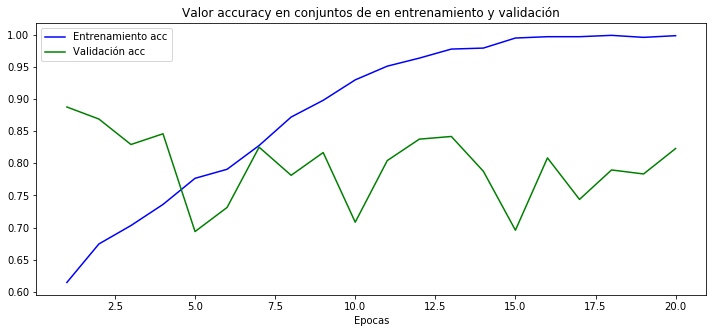

In [523]:
from keras.utils import to_categorical

y_train_Bow_W2V_Twitter_Google_mx = to_categorical(y_train)
y_test_Bow_W2V_Twitter_Google_mx  = to_categorical(y_test)

num_mx, sz_mx = y_train_Bow_W2V_Twitter_Google_mx.shape

print(num_mx)
print(sz_mx)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_Bow_W2V_Twitter_Google_mx = Sequential()
nn_Bow_W2V_Twitter_Google_mx.add(Dense(512, activation='relu'))
nn_Bow_W2V_Twitter_Google_mx.add(Dropout(0.25))
nn_Bow_W2V_Twitter_Google_mx.add(Dense(sz_mx, activation='softmax'))
nn_Bow_W2V_Twitter_Google_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_Bow_W2V_Twitter_Google_mx = nn_Bow_W2V_Twitter_Google_mx.fit(BoW_W2V_Twitter_Google_mx_train, 
              y_train_Bow_W2V_Twitter_Google_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic) 

history_dict_Bow_W2V_Twitter_Google_mx = history_Bow_W2V_Twitter_Google_mx.history
dictkeys_Bow_W2V_Twitter_Google_mx=list(history_dict_Bow_W2V_Twitter_Google_mx.keys())
loss_values_Bow_W2V_Twitter_Google_mx = history_Bow_W2V_Twitter_Google_mx.history['acc']
val_loss_values_Bow_W2V_Twitter_Google_mx = history_Bow_W2V_Twitter_Google_mx.history['val_acc']
epochs_Bow_W2V_Twitter_Google_mx = range(1, len(loss_values_Bow_W2V_Twitter_Google_mx) + 1)



plt.figure(figsize=(12,5))
plt.plot(epochs_Bow_W2V_Twitter_Google_mx, loss_values_Bow_W2V_Twitter_Google_mx, 'b', label='Entrenamiento acc')
plt.plot(epochs_Bow_W2V_Twitter_Google_mx, val_loss_values_Bow_W2V_Twitter_Google_mx, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()


In [536]:
del nn_Bow_W2V_Twitter_Google_mx

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 6

nn_Bow_W2V_Twitter_Google_mx = Sequential()
nn_Bow_W2V_Twitter_Google_mx.add(Dense(512, activation='relu'))
nn_Bow_W2V_Twitter_Google_mx.add(Dropout(0.25))
nn_Bow_W2V_Twitter_Google_mx.add(Dense(sz_mx, activation='softmax'))
nn_Bow_W2V_Twitter_Google_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_Bow_W2V_Twitter_Google_mx= nn_Bow_W2V_Twitter_Google_mx.fit(BoW_W2V_Twitter_Google_mx_train, 
              y_train_Bow_W2V_Twitter_Google_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


from keras.models import load_model
nn_Bow_W2V_Twitter_Google_mx.save('nn_Bow_W2V_Twitter_Google_mx')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_Bow_W2V_Twitter_Google_mx= nn_Bow_W2V_Twitter_Google_mx.predict(BoW_W2V_Twitter_Google_mx_test).squeeze()
y_test_label_Bow_W2V_Twitter_Google_mx = np.argmax(y_test_Bow_W2V_Twitter_Google_mx,1) 
y_pred_label_Bow_W2V_Twitter_Google_mx = np.argmax(y_pred_Bow_W2V_Twitter_Google_mx,1)


print("F1 score", f1_score(y_test_label_Bow_W2V_Twitter_Google_mx,  y_pred_label_Bow_W2V_Twitter_Google_mx,  average='macro'))
print("F1 weighted", f1_score(y_test_label_Bow_W2V_Twitter_Google_mx,  y_pred_label_Bow_W2V_Twitter_Google_mx,  average='weighted'))
print("Recall score", recall_score(y_test_label_Bow_W2V_Twitter_Google_mx,  y_pred_label_Bow_W2V_Twitter_Google_mx,   average='macro'))
print("Precision score", precision_score(y_test_label_Bow_W2V_Twitter_Google_mx,  y_pred_label_Bow_W2V_Twitter_Google_mx,   average='macro'))

Tiempo de procesamiento (secs):  4.4209911823272705
F1 score 0.6125683792443866
F1 weighted 0.6512641885663
Recall score 0.616686925901327
Precision score 0.6107575739553472


### España

In [ ]:
del nn_Bow_W2V_Twitter_Google_es

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 4s - loss: 0.5543 - acc: 0.7099 - val_loss: 0.6864 - val_acc: 0.5771
Epoch 2/20
 - 1s - loss: 0.4190 - acc: 0.8073 - val_loss: 0.7314 - val_acc: 0.5646
Epoch 3/20
 - 1s - loss: 0.3025 - acc: 0.8703 - val_loss: 1.0707 - val_acc: 0.4667
Epoch 4/20
 - 1s - loss: 0.1830 - acc: 0.9411 - val_loss: 0.8777 - val_acc: 0.5792
Epoch 5/20
 - 1s - loss: 0.1062 - acc: 0.9719 - val_loss: 0.9175 - val_acc: 0.5917
Epoch 6/20
 - 1s - loss: 0.0556 - acc: 0.9906 - val_loss: 1.1645 - val_acc: 0.5438
Epoch 7/20
 - 1s - loss: 0.0325 - acc: 0.9953 - val_loss: 1.0694 - val_acc: 0.5708
Epoch 8/20
 - 1s - loss: 0.0212 - acc: 0.9969 - val_loss: 1.0469 - val_acc: 0.5750
Epoch 9/20
 - 1s - loss: 0.0134 - acc: 0.9995 - val_loss: 1.1023 - val_acc: 0.5729
Epoch 10/20
 - 1s - loss: 0.0111 - acc: 0.9990 - val_loss: 1.2673 - val_acc: 0.5583
Epoch 11/20
 - 1s - loss: 0.0103 - acc: 0.9984 - val_loss: 1.1845 - val_acc: 0.5688
Epoch 12/20
 - 1s - loss: 0.006

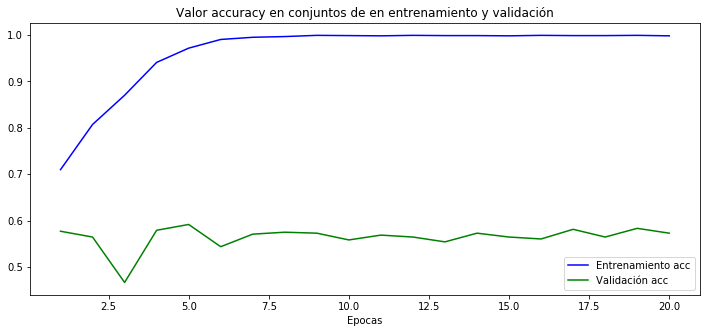

In [528]:
from keras.utils import to_categorical

y_train_Bow_W2V_Twitter_Google_es = to_categorical(y_train_es)
y_test_Bow_W2V_Twitter_Google_es  = to_categorical(y_test_es)

num_es, sz_es = y_train_Bow_W2V_Twitter_Google_es.shape

print(num_es)
print(sz_es)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_Bow_W2V_Twitter_Google_es = Sequential()
nn_Bow_W2V_Twitter_Google_es.add(Dense(512, activation='relu'))
nn_Bow_W2V_Twitter_Google_es.add(Dropout(0.25))
nn_Bow_W2V_Twitter_Google_es.add(Dense(sz_es, activation='softmax'))
nn_Bow_W2V_Twitter_Google_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_Bow_W2V_Twitter_Google_es = nn_Bow_W2V_Twitter_Google_es.fit(BoW_W2V_Twitter_Google_es_train, 
              y_train_Bow_W2V_Twitter_Google_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic) 

history_dict_Bow_W2V_Twitter_Google_es = history_Bow_W2V_Twitter_Google_es.history
dictkeys_Bow_W2V_Twitter_Google_es=list(history_dict_Bow_W2V_Twitter_Google_es.keys())
loss_values_Bow_W2V_Twitter_Google_es = history_Bow_W2V_Twitter_Google_es.history['acc']
val_loss_values_Bow_W2V_Twitter_Google_es = history_Bow_W2V_Twitter_Google_es.history['val_acc']
epochs_Bow_W2V_Twitter_Google_es = range(1, len(loss_values_Bow_W2V_Twitter_Google_es) + 1)



plt.figure(figsize=(12,5))
plt.plot(epochs_Bow_W2V_Twitter_Google_es, loss_values_Bow_W2V_Twitter_Google_es, 'b', label='Entrenamiento acc')
plt.plot(epochs_Bow_W2V_Twitter_Google_es, val_loss_values_Bow_W2V_Twitter_Google_es, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()


In [534]:
del nn_Bow_W2V_Twitter_Google_es

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 7

nn_Bow_W2V_Twitter_Google_es = Sequential()
nn_Bow_W2V_Twitter_Google_es.add(Dense(512, activation='relu'))
nn_Bow_W2V_Twitter_Google_es.add(Dropout(0.25))
nn_Bow_W2V_Twitter_Google_es.add(Dense(sz_es, activation='softmax'))
nn_Bow_W2V_Twitter_Google_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_Bow_W2V_Twitter_Google_es= nn_Bow_W2V_Twitter_Google_es.fit(BoW_W2V_Twitter_Google_es_train, 
              y_train_Bow_W2V_Twitter_Google_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


from keras.models import load_model
nn_Bow_W2V_Twitter_Google_es.save('nn_Bow_W2V_Twitter_Google_es')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_Bow_W2V_Twitter_Google_es= nn_Bow_W2V_Twitter_Google_es.predict(BoW_W2V_Twitter_Google_es_test).squeeze()
y_test_label_Bow_W2V_Twitter_Google_es = np.argmax(y_test_Bow_W2V_Twitter_Google_es,1) 
y_pred_label_Bow_W2V_Twitter_Google_es = np.argmax(y_pred_Bow_W2V_Twitter_Google_es,1)


print("F1 score", f1_score(y_test_label_Bow_W2V_Twitter_Google_es,  y_pred_label_Bow_W2V_Twitter_Google_es,  average='macro'))
print("F1 weighted", f1_score(y_test_label_Bow_W2V_Twitter_Google_es,  y_pred_label_Bow_W2V_Twitter_Google_es,  average='weighted'))
print("Recall score", recall_score(y_test_label_Bow_W2V_Twitter_Google_es,  y_pred_label_Bow_W2V_Twitter_Google_es,   average='macro'))
print("Precision score", precision_score(y_test_label_Bow_W2V_Twitter_Google_es,  y_pred_label_Bow_W2V_Twitter_Google_es,   average='macro'))

Tiempo de procesamiento (secs):  7.712883710861206
F1 score 0.6703246105440872
F1 weighted 0.7042079144603893
Recall score 0.67375
Precision score 0.6679250981576563


### Cuba

In [ ]:
del nn_Bow_W2V_Twitter_Google_cu

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 4s - loss: 0.6351 - acc: 0.6536 - val_loss: 0.7986 - val_acc: 0.4708
Epoch 2/20
 - 0s - loss: 0.5793 - acc: 0.6943 - val_loss: 1.1715 - val_acc: 0.4667
Epoch 3/20
 - 0s - loss: 0.5557 - acc: 0.7130 - val_loss: 1.0885 - val_acc: 0.4687
Epoch 4/20
 - 0s - loss: 0.5173 - acc: 0.7500 - val_loss: 1.8124 - val_acc: 0.3854
Epoch 5/20
 - 0s - loss: 0.5074 - acc: 0.7406 - val_loss: 1.8658 - val_acc: 0.3833
Epoch 6/20
 - 0s - loss: 0.4862 - acc: 0.7635 - val_loss: 1.7185 - val_acc: 0.4417
Epoch 7/20
 - 0s - loss: 0.4468 - acc: 0.7948 - val_loss: 2.2587 - val_acc: 0.4125
Epoch 8/20
 - 0s - loss: 0.4397 - acc: 0.8026 - val_loss: 2.1612 - val_acc: 0.4312
Epoch 9/20
 - 0s - loss: 0.3995 - acc: 0.8208 - val_loss: 2.9903 - val_acc: 0.3250
Epoch 10/20
 - 0s - loss: 0.3814 - acc: 0.8260 - val_loss: 2.3818 - val_acc: 0.4563
Epoch 11/20
 - 0s - loss: 0.3648 - acc: 0.8474 - val_loss: 2.4952 - val_acc: 0.4896
Epoch 12/20
 - 0s - loss: 0.335

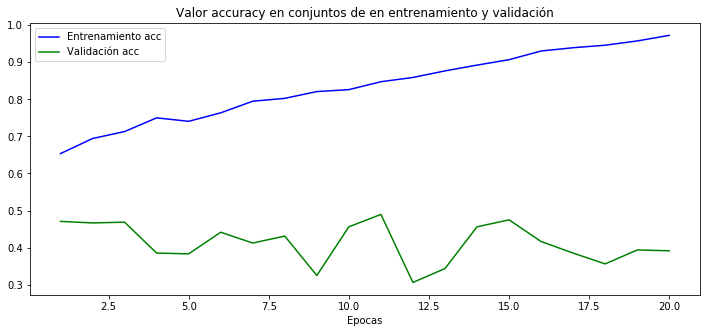

In [537]:
from keras.utils import to_categorical

y_train_Bow_W2V_Twitter_Google_cu = to_categorical(y_train_cu)
y_test_Bow_W2V_Twitter_Google_cu  = to_categorical(y_test_cu)

num_cu, sz_cu = y_train_Bow_W2V_Twitter_Google_cu.shape

print(num_cu)
print(sz_cu)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_Bow_W2V_Twitter_Google_cu = Sequential()
nn_Bow_W2V_Twitter_Google_cu.add(Dense(512, activation='relu'))
nn_Bow_W2V_Twitter_Google_cu.add(Dropout(0.25))
nn_Bow_W2V_Twitter_Google_cu.add(Dense(sz_cu, activation='softmax'))
nn_Bow_W2V_Twitter_Google_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_Bow_W2V_Twitter_Google_cu = nn_Bow_W2V_Twitter_Google_cu.fit(BoW_W2V_Twitter_Google_cu_train, 
              y_train_Bow_W2V_Twitter_Google_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic) 

history_dict_Bow_W2V_Twitter_Google_cu = history_Bow_W2V_Twitter_Google_cu.history
dictkeys_Bow_W2V_Twitter_Google_cu=list(history_dict_Bow_W2V_Twitter_Google_cu.keys())
loss_values_Bow_W2V_Twitter_Google_cu = history_Bow_W2V_Twitter_Google_cu.history['acc']
val_loss_values_Bow_W2V_Twitter_Google_cu = history_Bow_W2V_Twitter_Google_cu.history['val_acc']
epochs_Bow_W2V_Twitter_Google_cu = range(1, len(loss_values_Bow_W2V_Twitter_Google_cu) + 1)



plt.figure(figsize=(12,5))
plt.plot(epochs_Bow_W2V_Twitter_Google_cu, loss_values_Bow_W2V_Twitter_Google_cu, 'b', label='Entrenamiento acc')
plt.plot(epochs_Bow_W2V_Twitter_Google_cu, val_loss_values_Bow_W2V_Twitter_Google_cu, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()


In [543]:
del nn_Bow_W2V_Twitter_Google_cu

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 6

nn_Bow_W2V_Twitter_Google_cu = Sequential()
nn_Bow_W2V_Twitter_Google_cu.add(Dense(512, activation='relu'))
nn_Bow_W2V_Twitter_Google_cu.add(Dropout(0.25))
nn_Bow_W2V_Twitter_Google_cu.add(Dense(sz_cu, activation='softmax'))
nn_Bow_W2V_Twitter_Google_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_Bow_W2V_Twitter_Google_cu= nn_Bow_W2V_Twitter_Google_cu.fit(BoW_W2V_Twitter_Google_cu_train, 
              y_train_Bow_W2V_Twitter_Google_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


from keras.models import load_model
nn_Bow_W2V_Twitter_Google_cu.save('nn_Bow_W2V_Twitter_Google_cu')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_Bow_W2V_Twitter_Google_cu= nn_Bow_W2V_Twitter_Google_cu.predict(BoW_W2V_Twitter_Google_cu_test).squeeze()
y_test_label_Bow_W2V_Twitter_Google_cu = np.argmax(y_test_Bow_W2V_Twitter_Google_cu,1) 
y_pred_label_Bow_W2V_Twitter_Google_cu = np.argmax(y_pred_Bow_W2V_Twitter_Google_cu,1)


print("F1 score", f1_score(y_test_label_Bow_W2V_Twitter_Google_cu,  y_pred_label_Bow_W2V_Twitter_Google_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_label_Bow_W2V_Twitter_Google_cu,  y_pred_label_Bow_W2V_Twitter_Google_cu,  average='weighted'))
print("Recall score", recall_score(y_test_label_Bow_W2V_Twitter_Google_cu,  y_pred_label_Bow_W2V_Twitter_Google_cu,   average='macro'))
print("Precision score", precision_score(y_test_label_Bow_W2V_Twitter_Google_cu,  y_pred_label_Bow_W2V_Twitter_Google_cu,   average='macro'))

Tiempo de procesamiento (secs):  4.980557918548584
F1 score 0.5946150737522732
F1 weighted 0.6414595541186773
Recall score 0.59375
Precision score 0.5957414215686274


# Concatenar W2VGoogle + W2VTwitter

### México

In [360]:
print(np.concatenate((mean_emb_train_w2vgoogle_mx,  mean_emb_train_w2vtwit_mx),axis=1).shape)
Twitter_Google_mx_train = np.concatenate((mean_emb_train_w2vgoogle_mx,  mean_emb_train_w2vtwit_mx),axis=1)


print(np.concatenate((mean_emb_test_w2vgoogle_mx,  mean_emb_test_w2vtwit_mx),axis=1).shape)
Twitter_Google_mx_test = np.concatenate((mean_emb_test_w2vgoogle_mx,  mean_emb_test_w2vtwit_mx),axis=1)

(2400, 700)
(600, 700)


In [362]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.01,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(Twitter_Google_mx_train, y_train.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_W2V_Twitter_Google_mx = linearSVC.best_estimator_
svc_W2V_Twitter_Google_mx.fit(Twitter_Google_mx_train, y_train.values)
svc_W2V_Twitter_Google_mx.coef_ = svc_W2V_Twitter_Google_mx.named_steps['SVC'].coef_
svc_W2V_Twitter_Google_mx.score(Twitter_Google_mx_train, y_train.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 1.9100000000000001}
Tiempo de procesamiento (secs):  100.54076671600342


In [363]:
from joblib import dump, load
dump(svc_W2V_Twitter_Google_mx, 'svc_W2V_Twitter_Google_mx.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_Twitter_Google_mx=svc_W2V_Twitter_Google_mx.predict(Twitter_Google_mx_test)
print("Acurracy Test",metrics.accuracy_score( y_test.values, prediction_Twitter_Google_mx))


Acurracy Test 0.6516666666666666


Accuracy score: 0.6516666666666666
F1 score 0.6132959581101459
F1 weighted 0.654305921752565
Recall score 0.6153648541961678
Precision score 0.6119188873759969
              precision    recall  f1-score   support

   no-ironia       0.75      0.72      0.74       401
      ironia       0.48      0.51      0.49       199

   micro avg       0.65      0.65      0.65       600
   macro avg       0.61      0.62      0.61       600
weighted avg       0.66      0.65      0.65       600



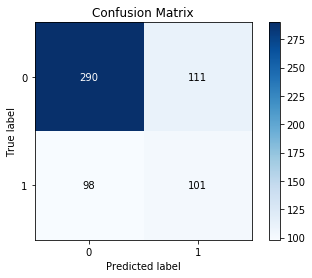

In [364]:
print('Accuracy score:', metrics.accuracy_score(y_test.values, prediction_Twitter_Google_mx))  # nn evaluate keras
print("F1 score", f1_score(y_test.values, prediction_Twitter_Google_mx,  average='macro'))
print("F1 weighted", f1_score(y_test.values, prediction_Twitter_Google_mx,  average='weighted'))
print("Recall score", recall_score(y_test.values, prediction_Twitter_Google_mx,  average='macro'))
print("Precision score", precision_score(y_test.values, prediction_Twitter_Google_mx,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test.values, prediction_Twitter_Google_mx, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test.values, prediction_Twitter_Google_mx)

### España

In [383]:
print(np.concatenate((mean_emb_train_w2vgoogle_es,  mean_emb_train_w2vtwit_es),axis=1).shape)
Twitter_Google_es_train = np.concatenate((mean_emb_train_w2vgoogle_es,  mean_emb_train_w2vtwit_es),axis=1)


print(np.concatenate((mean_emb_test_w2vgoogle_es,  mean_emb_test_w2vtwit_es),axis=1).shape)
Twitter_Google_es_test = np.concatenate((mean_emb_test_w2vgoogle_es,  mean_emb_test_w2vtwit_es),axis=1)

(2400, 700)
(600, 700)


In [390]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.01,2,.1)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(Twitter_Google_es_train, y_train_es.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_W2V_Twitter_Google_es = linearSVC.best_estimator_
svc_W2V_Twitter_Google_es.fit(Twitter_Google_es_train, y_train_es.values)
svc_W2V_Twitter_Google_es.coef_ = svc_W2V_Twitter_Google_es.named_steps['SVC'].coef_
svc_W2V_Twitter_Google_es.score(Twitter_Google_es_train, y_train_es.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.01}
Tiempo de procesamiento (secs):  57.703532695770264


In [391]:
from joblib import dump, load
dump(svc_W2V_Twitter_Google_es, 'svc_W2V_Twitter_Google_es.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_Twitter_Google_es=svc_W2V_Twitter_Google_es.predict(Twitter_Google_es_test)
print("Acurracy Test",metrics.accuracy_score( y_test_es.values, prediction_Twitter_Google_es))

Acurracy Test 0.66


Accuracy score: 0.66
F1 score 0.6463204614015419
F1 weighted 0.6695061200429964
Recall score 0.66875
Precision score 0.6505419510236853
              precision    recall  f1-score   support

   no-ironia       0.81      0.64      0.72       400
      ironia       0.49      0.69      0.58       200

   micro avg       0.66      0.66      0.66       600
   macro avg       0.65      0.67      0.65       600
weighted avg       0.70      0.66      0.67       600



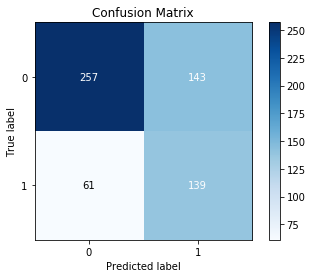

In [392]:
print('Accuracy score:', metrics.accuracy_score(y_test_es.values, prediction_Twitter_Google_es))  # nn evaluate keras
print("F1 score", f1_score(y_test_es.values, prediction_Twitter_Google_es,  average='macro'))
print("F1 weighted", f1_score(y_test_es.values, prediction_Twitter_Google_es,  average='weighted'))
print("Recall score", recall_score(y_test_es.values, prediction_Twitter_Google_es,  average='macro'))
print("Precision score", precision_score(y_test_es.values, prediction_Twitter_Google_es,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test_es.values, prediction_Twitter_Google_es, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_es.values, prediction_Twitter_Google_es)

### Cuba

In [393]:
print(np.concatenate((mean_emb_train_w2vgoogle_cu,  mean_emb_train_w2vtwit_cu),axis=1).shape)
Twitter_Google_cu_train = np.concatenate((mean_emb_train_w2vgoogle_cu,  mean_emb_train_w2vtwit_cu),axis=1)


print(np.concatenate((mean_emb_test_w2vgoogle_cu,  mean_emb_test_w2vtwit_cu),axis=1).shape)
Twitter_Google_cu_test = np.concatenate((mean_emb_test_w2vgoogle_cu,  mean_emb_test_w2vtwit_cu),axis=1)

(2400, 700)
(600, 700)


In [397]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
tic=time.time()

SVCpipe = Pipeline([('SVC',LinearSVC(class_weight="balanced", random_state=1,verbose=0, max_iter=2000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(.001,1,.01)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True, verbose=0)
linearSVC.fit(Twitter_Google_cu_train, y_train_cu.values)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

svc_W2V_Twitter_Google_cu = linearSVC.best_estimator_
svc_W2V_Twitter_Google_cu.fit(Twitter_Google_cu_train, y_train_cu.values)
svc_W2V_Twitter_Google_cu.coef_ = svc_W2V_Twitter_Google_cu.named_steps['SVC'].coef_
svc_W2V_Twitter_Google_cu.score(Twitter_Google_cu_train, y_train_cu.values)
    
print('Tiempo de procesamiento (secs): ', time.time()-tic)

{'SVC__C': 0.001}
Tiempo de procesamiento (secs):  251.3999924659729


In [398]:
from joblib import dump, load
dump(svc_W2V_Twitter_Google_cu, 'svc_W2V_Twitter_Google_cu.joblib') 
#svc_w2vtwit_cu = load('svc_w2vtwit_cu.joblib')
prediction_Twitter_Google_cu=svc_W2V_Twitter_Google_cu.predict(Twitter_Google_cu_test)
print("Acurracy Test",metrics.accuracy_score( y_test_cu.values, prediction_Twitter_Google_cu))

Acurracy Test 0.6233333333333333


Accuracy score: 0.6233333333333333
F1 score 0.6059559926073159
F1 weighted 0.6335390731248038
Recall score 0.6225
Precision score 0.6097129550848597
              precision    recall  f1-score   support

   no-ironia       0.77      0.62      0.69       400
      ironia       0.45      0.62      0.52       200

   micro avg       0.62      0.62      0.62       600
   macro avg       0.61      0.62      0.61       600
weighted avg       0.66      0.62      0.63       600



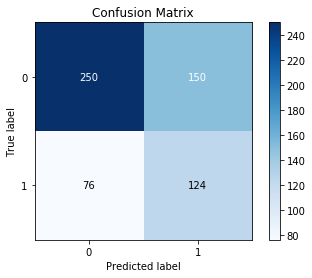

In [399]:
print('Accuracy score:', metrics.accuracy_score(y_test_cu.values, prediction_Twitter_Google_cu))  # nn evaluate keras
print("F1 score", f1_score(y_test_cu.values, prediction_Twitter_Google_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_cu.values, prediction_Twitter_Google_cu,  average='weighted'))
print("Recall score", recall_score(y_test_cu.values, prediction_Twitter_Google_cu,  average='macro'))
print("Precision score", precision_score(y_test_cu.values, prediction_Twitter_Google_cu,  average='macro'))


from sklearn.metrics import classification_report
print(classification_report( y_test_cu.values, prediction_Twitter_Google_cu, target_names=['no-ironia','ironia']))

%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test_cu.values, prediction_Twitter_Google_cu)

## Clasificador NN

### México

In [ ]:
del nn_W2V_Twitter_Google_mx
# Twitter_Google_mx_train

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 4s - loss: 0.6724 - acc: 0.6073 - val_loss: 0.4581 - val_acc: 0.8875
Epoch 2/20
 - 0s - loss: 0.6282 - acc: 0.6573 - val_loss: 0.4813 - val_acc: 0.8188
Epoch 3/20
 - 0s - loss: 0.6075 - acc: 0.6750 - val_loss: 0.4875 - val_acc: 0.8625
Epoch 4/20
 - 0s - loss: 0.5788 - acc: 0.6917 - val_loss: 0.4307 - val_acc: 0.8813
Epoch 5/20
 - 0s - loss: 0.5411 - acc: 0.7266 - val_loss: 0.6587 - val_acc: 0.6042
Epoch 6/20
 - 0s - loss: 0.5301 - acc: 0.7333 - val_loss: 0.4989 - val_acc: 0.8167
Epoch 7/20
 - 0s - loss: 0.5097 - acc: 0.7536 - val_loss: 0.4821 - val_acc: 0.8250
Epoch 8/20
 - 0s - loss: 0.4622 - acc: 0.7792 - val_loss: 0.3873 - val_acc: 0.8667
Epoch 9/20
 - 0s - loss: 0.4409 - acc: 0.7812 - val_loss: 0.4385 - val_acc: 0.8458
Epoch 10/20
 - 0s - loss: 0.4088 - acc: 0.8198 - val_loss: 0.4515 - val_acc: 0.8396
Epoch 11/20
 - 0s - loss: 0.3731 - acc: 0.8396 - val_loss: 0.5093 - val_acc: 0.7500
Epoch 12/20
 - 0s - loss: 0.349

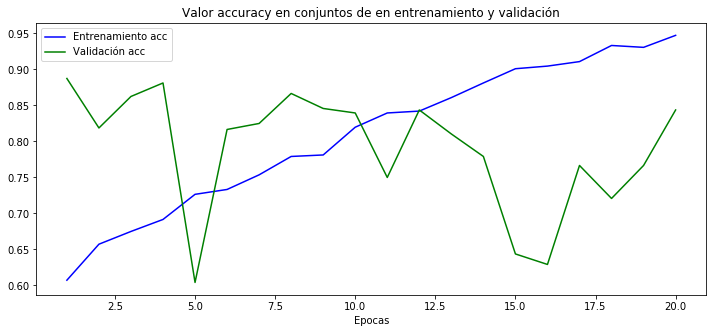

In [544]:
from keras.utils import to_categorical

y_train_W2V_Twitter_Google_mx = to_categorical(y_train)
y_test_W2V_Twitter_Google_mx  = to_categorical(y_test)

num_mx, sz_mx = y_train_W2V_Twitter_Google_mx.shape

print(num_mx)
print(sz_mx)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_W2V_Twitter_Google_mx = Sequential()
nn_W2V_Twitter_Google_mx.add(Dense(512, activation='relu'))
nn_W2V_Twitter_Google_mx.add(Dropout(0.25))
nn_W2V_Twitter_Google_mx.add(Dense(sz_mx, activation='softmax'))
nn_W2V_Twitter_Google_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_W2V_Twitter_Google_mx = nn_W2V_Twitter_Google_mx.fit(Twitter_Google_mx_train, 
              y_train_W2V_Twitter_Google_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic) 

history_dict_W2V_Twitter_Google_mx = history_W2V_Twitter_Google_mx.history
dictkeys_W2V_Twitter_Google_mx=list(history_dict_W2V_Twitter_Google_mx.keys())
loss_values_W2V_Twitter_Google_mx = history_W2V_Twitter_Google_mx.history['acc']
val_loss_values_W2V_Twitter_Google_mx = history_W2V_Twitter_Google_mx.history['val_acc']
epochs_W2V_Twitter_Google_mx = range(1, len(loss_values_W2V_Twitter_Google_mx) + 1)



plt.figure(figsize=(12,5))
plt.plot(epochs_W2V_Twitter_Google_mx, loss_values_W2V_Twitter_Google_mx, 'b', label='Entrenamiento acc')
plt.plot(epochs_W2V_Twitter_Google_mx, val_loss_values_W2V_Twitter_Google_mx, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()


In [550]:
del nn_W2V_Twitter_Google_mx

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 7

nn_W2V_Twitter_Google_mx = Sequential()
nn_W2V_Twitter_Google_mx.add(Dense(512, activation='relu'))
nn_W2V_Twitter_Google_mx.add(Dropout(0.25))
nn_W2V_Twitter_Google_mx.add(Dense(sz_mx, activation='softmax'))
nn_W2V_Twitter_Google_mx.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_W2V_Twitter_Google_mx= nn_W2V_Twitter_Google_mx.fit(Twitter_Google_mx_train, 
              y_train_W2V_Twitter_Google_mx, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


from keras.models import load_model
nn_W2V_Twitter_Google_mx.save('nn_W2V_Twitter_Google_mx')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_W2V_Twitter_Google_mx= nn_W2V_Twitter_Google_mx.predict(Twitter_Google_mx_test).squeeze()
y_test_label_W2V_Twitter_Google_mx = np.argmax(y_test_W2V_Twitter_Google_mx,1) 
y_pred_label_W2V_Twitter_Google_mx = np.argmax(y_pred_W2V_Twitter_Google_mx,1)


print("F1 score", f1_score(y_test_label_W2V_Twitter_Google_mx,  y_pred_label_W2V_Twitter_Google_mx,  average='macro'))
print("F1 weighted", f1_score(y_test_label_W2V_Twitter_Google_mx,  y_pred_label_W2V_Twitter_Google_mx,  average='weighted'))
print("Recall score", recall_score(y_test_label_W2V_Twitter_Google_mx,  y_pred_label_W2V_Twitter_Google_mx,   average='macro'))
print("Precision score", precision_score(y_test_label_W2V_Twitter_Google_mx,  y_pred_label_W2V_Twitter_Google_mx,   average='macro'))

Tiempo de procesamiento (secs):  8.264517784118652
F1 score 0.6182031774446184
F1 weighted 0.6764738569404042
Recall score 0.6135916490181581
Precision score 0.649187774650669


### España

In [ ]:
del nn_W2V_Twitter_Google_es

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 8s - loss: 0.5788 - acc: 0.6969 - val_loss: 0.6795 - val_acc: 0.6250
Epoch 2/20
 - 0s - loss: 0.5477 - acc: 0.7375 - val_loss: 0.6837 - val_acc: 0.6021
Epoch 3/20
 - 0s - loss: 0.5214 - acc: 0.7500 - val_loss: 0.7942 - val_acc: 0.5437
Epoch 4/20
 - 0s - loss: 0.5080 - acc: 0.7589 - val_loss: 0.7110 - val_acc: 0.6250
Epoch 5/20
 - 0s - loss: 0.4946 - acc: 0.7635 - val_loss: 0.8013 - val_acc: 0.6458
Epoch 6/20
 - 0s - loss: 0.4800 - acc: 0.7807 - val_loss: 0.8210 - val_acc: 0.4917
Epoch 7/20
 - 0s - loss: 0.4641 - acc: 0.7859 - val_loss: 0.7942 - val_acc: 0.5125
Epoch 8/20
 - 0s - loss: 0.4688 - acc: 0.7729 - val_loss: 0.7372 - val_acc: 0.6333
Epoch 9/20
 - 0s - loss: 0.4549 - acc: 0.7812 - val_loss: 1.0074 - val_acc: 0.4813
Epoch 10/20
 - 0s - loss: 0.4417 - acc: 0.7891 - val_loss: 0.7719 - val_acc: 0.6312
Epoch 11/20
 - 0s - loss: 0.4287 - acc: 0.8010 - val_loss: 0.7563 - val_acc: 0.6333
Epoch 12/20
 - 0s - loss: 0.415

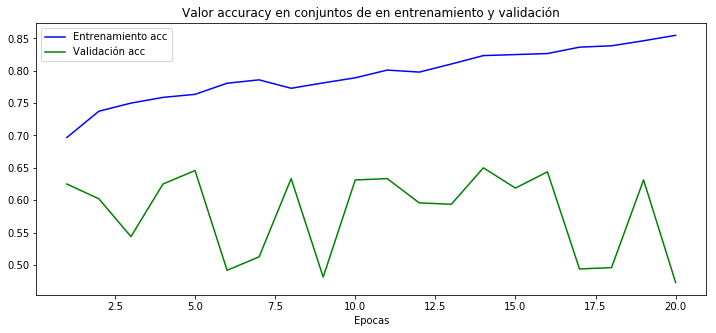

In [551]:
from keras.utils import to_categorical

y_train_W2V_Twitter_Google_es = to_categorical(y_train_es)
y_test_W2V_Twitter_Google_es  = to_categorical(y_test_es)

num_es, sz_es = y_train_W2V_Twitter_Google_es.shape

print(num_es)
print(sz_es)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_W2V_Twitter_Google_es = Sequential()
nn_W2V_Twitter_Google_es.add(Dense(512, activation='relu'))
nn_W2V_Twitter_Google_es.add(Dropout(0.25))
nn_W2V_Twitter_Google_es.add(Dense(sz_es, activation='softmax'))
nn_W2V_Twitter_Google_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_W2V_Twitter_Google_es = nn_W2V_Twitter_Google_es.fit(Twitter_Google_es_train, 
              y_train_W2V_Twitter_Google_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic) 

history_dict_W2V_Twitter_Google_es = history_W2V_Twitter_Google_es.history
dictkeys_W2V_Twitter_Google_es=list(history_dict_W2V_Twitter_Google_es.keys())
loss_values_W2V_Twitter_Google_es = history_W2V_Twitter_Google_es.history['acc']
val_loss_values_W2V_Twitter_Google_es = history_W2V_Twitter_Google_es.history['val_acc']
epochs_W2V_Twitter_Google_es = range(1, len(loss_values_W2V_Twitter_Google_es) + 1)



plt.figure(figsize=(12,5))
plt.plot(epochs_W2V_Twitter_Google_es, loss_values_W2V_Twitter_Google_es, 'b', label='Entrenamiento acc')
plt.plot(epochs_W2V_Twitter_Google_es, val_loss_values_W2V_Twitter_Google_es, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()


In [555]:
del nn_W2V_Twitter_Google_es

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 7


nn_W2V_Twitter_Google_es = Sequential()
nn_W2V_Twitter_Google_es.add(Dense(512, activation='relu'))
nn_W2V_Twitter_Google_es.add(Dropout(0.25))
nn_W2V_Twitter_Google_es.add(Dense(sz_es, activation='softmax'))
nn_W2V_Twitter_Google_es.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_W2V_Twitter_Google_es= nn_W2V_Twitter_Google_es.fit(Twitter_Google_es_train, 
              y_train_W2V_Twitter_Google_es, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


from keras.models import load_model
nn_W2V_Twitter_Google_es.save('nn_W2V_Twitter_Google_es')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_W2V_Twitter_Google_es= nn_W2V_Twitter_Google_es.predict(Twitter_Google_es_test).squeeze()
y_test_label_W2V_Twitter_Google_es = np.argmax(y_test_W2V_Twitter_Google_es,1) 
y_pred_label_W2V_Twitter_Google_es = np.argmax(y_pred_W2V_Twitter_Google_es,1)


print("F1 score", f1_score(y_test_label_W2V_Twitter_Google_es,  y_pred_label_W2V_Twitter_Google_es,  average='macro'))
print("F1 weighted", f1_score(y_test_label_W2V_Twitter_Google_es,  y_pred_label_W2V_Twitter_Google_es,  average='weighted'))
print("Recall score", recall_score(y_test_label_W2V_Twitter_Google_es,  y_pred_label_W2V_Twitter_Google_es,   average='macro'))
print("Precision score", precision_score(y_test_label_W2V_Twitter_Google_es,  y_pred_label_W2V_Twitter_Google_es,   average='macro'))

Tiempo de procesamiento (secs):  8.27528977394104
F1 score 0.6574389400690286
F1 weighted 0.6778022919649253
Recall score 0.685
Precision score 0.6645340240797768


### Cuba

In [ ]:
del nn_W2V_Twitter_Google_cu

2400
2
Train on 1920 samples, validate on 480 samples
Epoch 1/20
 - 6s - loss: 0.6484 - acc: 0.6385 - val_loss: 0.6211 - val_acc: 0.7083
Epoch 2/20
 - 0s - loss: 0.6235 - acc: 0.6688 - val_loss: 0.7267 - val_acc: 0.5458
Epoch 3/20
 - 0s - loss: 0.6188 - acc: 0.6625 - val_loss: 0.6797 - val_acc: 0.6479
Epoch 4/20
 - 0s - loss: 0.5939 - acc: 0.6969 - val_loss: 0.8582 - val_acc: 0.4604
Epoch 5/20
 - 0s - loss: 0.5946 - acc: 0.6896 - val_loss: 1.0079 - val_acc: 0.4167
Epoch 6/20
 - 0s - loss: 0.5805 - acc: 0.7068 - val_loss: 0.9797 - val_acc: 0.4646
Epoch 7/20
 - 0s - loss: 0.5601 - acc: 0.7167 - val_loss: 1.1870 - val_acc: 0.4167
Epoch 8/20
 - 0s - loss: 0.5591 - acc: 0.7151 - val_loss: 1.2351 - val_acc: 0.3958
Epoch 9/20
 - 0s - loss: 0.5429 - acc: 0.7250 - val_loss: 1.4618 - val_acc: 0.3687
Epoch 10/20
 - 0s - loss: 0.5425 - acc: 0.7198 - val_loss: 1.2641 - val_acc: 0.4500
Epoch 11/20
 - 0s - loss: 0.5347 - acc: 0.7339 - val_loss: 1.1154 - val_acc: 0.5062
Epoch 12/20
 - 0s - loss: 0.512

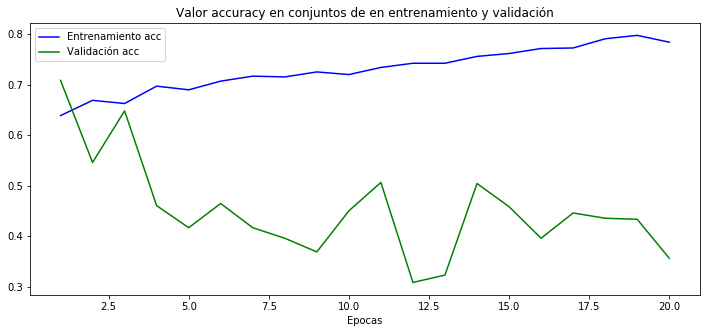

In [556]:
from keras.utils import to_categorical

y_train_W2V_Twitter_Google_cu = to_categorical(y_train_cu)
y_test_W2V_Twitter_Google_cu  = to_categorical(y_test_cu)

num_cu, sz_cu = y_train_W2V_Twitter_Google_cu.shape

print(num_cu)
print(sz_cu)


import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 20

nn_W2V_Twitter_Google_cu = Sequential()
nn_W2V_Twitter_Google_cu.add(Dense(512, activation='relu'))
nn_W2V_Twitter_Google_cu.add(Dropout(0.25))
nn_W2V_Twitter_Google_cu.add(Dense(sz_cu, activation='softmax'))
nn_W2V_Twitter_Google_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_W2V_Twitter_Google_cu = nn_W2V_Twitter_Google_cu.fit(Twitter_Google_cu_train, 
              y_train_W2V_Twitter_Google_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=2)

print('Tiempo de procesamiento (secs): ', time.time()-tic) 

history_dict_W2V_Twitter_Google_cu = history_W2V_Twitter_Google_cu.history
dictkeys_W2V_Twitter_Google_cu=list(history_dict_W2V_Twitter_Google_cu.keys())
loss_values_W2V_Twitter_Google_cu = history_W2V_Twitter_Google_cu.history['acc']
val_loss_values_W2V_Twitter_Google_cu = history_W2V_Twitter_Google_cu.history['val_acc']
epochs_W2V_Twitter_Google_cu = range(1, len(loss_values_W2V_Twitter_Google_cu) + 1)



plt.figure(figsize=(12,5))
plt.plot(epochs_W2V_Twitter_Google_cu, loss_values_W2V_Twitter_Google_cu, 'b', label='Entrenamiento acc')
plt.plot(epochs_W2V_Twitter_Google_cu, val_loss_values_W2V_Twitter_Google_cu, 'g', label='Validación acc')
plt.title('Valor accuracy en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.legend()

plt.show()


In [559]:
del nn_W2V_Twitter_Google_cu

import time
tic=time.time()

np.random.seed(1)

batch_size = 50
epochs = 7


nn_W2V_Twitter_Google_cu = Sequential()
nn_W2V_Twitter_Google_cu.add(Dense(512, activation='relu'))
nn_W2V_Twitter_Google_cu.add(Dropout(0.25))
nn_W2V_Twitter_Google_cu.add(Dense(sz_cu, activation='softmax'))
nn_W2V_Twitter_Google_cu.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
    
history_W2V_Twitter_Google_cu= nn_W2V_Twitter_Google_cu.fit(Twitter_Google_cu_train, 
              y_train_W2V_Twitter_Google_cu, 
              validation_split=.2,
              batch_size= batch_size,
              shuffle   =True,
              epochs=epochs,
              verbose=0)

print('Tiempo de procesamiento (secs): ', time.time()-tic)


from keras.models import load_model
nn_W2V_Twitter_Google_cu.save('nn_W2V_Twitter_Google_cu')  # Guardar modelo
#nn_w2vtwit_cu = load_model('nn_cuba_w2vtwit') # Cargar modelo


y_pred_W2V_Twitter_Google_cu= nn_W2V_Twitter_Google_cu.predict(Twitter_Google_cu_test).squeeze()
y_test_label_W2V_Twitter_Google_cu = np.argmax(y_test_W2V_Twitter_Google_cu,1) 
y_pred_label_W2V_Twitter_Google_cu = np.argmax(y_pred_W2V_Twitter_Google_cu,1)


print("F1 score", f1_score(y_test_label_W2V_Twitter_Google_cu,  y_pred_label_W2V_Twitter_Google_cu,  average='macro'))
print("F1 weighted", f1_score(y_test_label_W2V_Twitter_Google_cu,  y_pred_label_W2V_Twitter_Google_cu,  average='weighted'))
print("Recall score", recall_score(y_test_label_W2V_Twitter_Google_cu,  y_pred_label_W2V_Twitter_Google_cu,   average='macro'))
print("Precision score", precision_score(y_test_label_W2V_Twitter_Google_cu,  y_pred_label_W2V_Twitter_Google_cu,   average='macro'))

Tiempo de procesamiento (secs):  8.909281492233276
F1 score 0.5376496867267744
F1 weighted 0.5964709210265347
Recall score 0.5375
Precision score 0.540894777736883


# F1 SCORE

### SVM

In [562]:
# SVM
Tabla = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF + W2V Google':[f1_score(y_test.values, prediction_BoW_W2VGoogle_mx,  average='macro'), 
                      f1_score(y_test_es.values, prediction_BoW_W2VGoogle_es,  average='macro'), 
                      f1_score(y_test_cu.values, prediction_BoW_W2VGoogle_cu,  average='macro')],
        'BoW TF-IDF + W2V Twitter':[f1_score(y_test.values, prediction_BoW_W2VTwitter_mx,  average='macro'), 
                      f1_score(y_test_es.values, prediction_BoW_W2VTwitter_es,  average='macro'), 
                      f1_score(y_test_cu.values, prediction_BoW_W2VTwitter_cu,  average='macro')],
        'BoW TF-IDF + W2V Google + W2V Twitter':[f1_score(y_test.values, prediction_BoW_W2V_Twitter_Google_mx,  average='macro'), 
                     f1_score(y_test_es.values, prediction_BoW_W2V_Twitter_Google_es,  average='macro'), 
                      f1_score(y_test_cu.values, prediction_BoW_W2V_Twitter_Google_cu,  average='macro')],
        'W2V Google + W2V Twitter':[f1_score(y_test.values, prediction_Twitter_Google_mx,  average='macro'), 
                     f1_score(y_test_es.values, prediction_Twitter_Google_es,  average='macro'), 
                     f1_score(y_test_cu.values, prediction_Twitter_Google_cu,  average='macro')]}
 
# Create DataFrame
Tabla = pd.DataFrame(Tabla)
Tabla

,País,BoW TF-IDF + W2V Google,BoW TF-IDF + W2V Twitter,BoW TF-IDF + W2V Google + W2V Twitter,W2V Google + W2V Twitter
0,México,0.654038,0.635878,0.644737,0.613296
1,España,0.697746,0.676872,0.682745,0.646320
2,Cuba,0.618873,0.621502,0.612358,0.605956


### NN

In [572]:
# SVM
Tabla2 = {'País':['México', 'España', 'Cuba'],
        'BoW TF-IDF + W2V Google':[f1_score(y_test_label_BoW_W2VGoogle_mx,  y_pred_label_BoW_W2VGoogle_mx,  average='macro'), 
                      f1_score(y_test_label_BoW_W2VGoogle_es,  y_pred_label_BoW_W2VGoogle_es,  average='macro'), 
                     f1_score(y_test_label_BoW_W2VGoogle_cu,  y_pred_label_BoW_W2VGoogle_cu,  average='macro')],
        'BoW TF-IDF + W2V Twitter':[f1_score(y_test_label_BoW_W2VTwitter_mx,  y_pred_label_BoW_W2VTwitter_mx,  average='macro'), 
                      f1_score(y_test_label_BoW_W2VTwitter_es,  y_pred_label_BoW_W2VTwitter_es,  average='macro'), 
                      f1_score(y_test_label_BoW_W2VTwitter_cu,  y_pred_label_BoW_W2VTwitter_cu,  average='macro')],
        'BoW TF-IDF + W2V Google + W2V Twitter':[f1_score(y_test_label_Bow_W2V_Twitter_Google_mx,  y_pred_label_Bow_W2V_Twitter_Google_mx,  average='macro'), 
                     f1_score(y_test_label_Bow_W2V_Twitter_Google_es,  y_pred_label_Bow_W2V_Twitter_Google_es,  average='macro'), 
                     f1_score(y_test_label_Bow_W2V_Twitter_Google_cu,  y_pred_label_Bow_W2V_Twitter_Google_cu,  average='macro')],
        'W2V Google + W2V Twitter':[f1_score(y_test_label_W2V_Twitter_Google_mx,  y_pred_label_W2V_Twitter_Google_mx,  average='macro'), 
                     f1_score(y_test_label_W2V_Twitter_Google_es,  y_pred_label_W2V_Twitter_Google_es,  average='macro'), 
                     f1_score(y_test_label_W2V_Twitter_Google_cu,  y_pred_label_W2V_Twitter_Google_cu,  average='macro')]}
 
# Create DataFrame
Tabla2 = pd.DataFrame(Tabla2)
Tabla2

,País,BoW TF-IDF + W2V Google,BoW TF-IDF + W2V Twitter,BoW TF-IDF + W2V Google + W2V Twitter,W2V Google + W2V Twitter
0,México,0.625342,0.622533,0.612568,0.618203
1,España,0.633245,0.653650,0.670325,0.657439
2,Cuba,0.545360,0.581698,0.594615,0.537650
